# Continous Observation Space
## Part 1:  Q-learning with Binarized state spaces

This notebook will guide you through implementation of vanilla Q-learning algorithm... not again! just kidding this will be given.
You will get `QlearningAgent` class and `play_and_train` fundtion. see below

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [0]:
from collections import defaultdict
import random, math
import numpy as np

class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on http://inst.eecs.berkeley.edu/~cs188/sp09/pacman.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value

        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self,state,action,value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        #<YOUR CODE HERE>
        value = max(self.get_qvalue(state,action) for action in possible_actions)
        
        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        #agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        #<YOUR CODE HERE>
        value = (1-learning_rate) * self.get_qvalue(state,action) + learning_rate * (reward + gamma * self.get_value(next_state))
        
        self.set_qvalue(state, action, value)

    
    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #<YOUR CODE HERE>
        best_acton = None
        best_q = float("-inf")
        for action in possible_actions:
            cur_q = self.get_qvalue(state,action)
            if cur_q > best_q:
                best_q = cur_q
                best_action  = action

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.getPolicy).
        
        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = random.choice(possible_actions)

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #agent parameters:
        epsilon = self.epsilon

        #<YOUR CODE HERE>
        if random.random() > epsilon:
            chosen_action = self.get_best_action(state)
        else:
            chosen_action = action
        
        return chosen_action

In [0]:
def play_and_train(env,agent,t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)#<YOUR CODE>
        
        next_s, r, done, _ = env.step(a)
        
        # train (update) agent for state s
        #<YOUR CODE HERE>
        agent.update(s, a, r, next_s)
        
        s = next_s
        total_reward +=r
        if done: break
        
    return total_reward
    
        
    

In [0]:
# fix no screen problem in collab (https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab?rq=1)
!apt-get install -y xvfb python-opengl
!pip install gym pyvirtualdisplay 

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

## Cartpole
Use agent to train efficiently on ***CartPole-v0***.

This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x,n_digits)` (or numpy round) to round real number to a given amount of digits.

The tricky part is to get the n_digits right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

let's first have a look at the environment...

In [0]:

import gym
env = gym.make("CartPole-v0")
n_actions = env.action_space.n
env.reset()
print("first state:%s" % (env.reset()))
m = env.render(mode='rgb_array')
plt.imshow(m)

now let's look at the environment documentation to understand what does the state 4-tuple mean:

In [0]:
print(env.unwrapped.__doc__)

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

In [0]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done: break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()

## Binarize environment

In [0]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper): # notice the usage of wrapper
    
    def _observation(self, state):    
        
        #state = <round state to some amount digits.>
        #hint: you can do that with round(x,n_digits)
        #you will need to pick a different n_digits for each dimension
        
        state = <YOUR CODE> # n_digits can be any integer but we recommend between 0 and 2 and can (should) be different between state dimension>
      
        return tuple(state)

In [0]:
env = Binarizer(gym.make("CartPole-v0"))

In [0]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done: break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    
    plt.hist(all_states[:,obs_i],bins=20)
    plt.show()

## Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__ 
* If your binarization is too coarse, your agent may fail to find optimal policy. In that case, change binarization. 
* If your binarization is too fine-grained, your agent will take much longer than 1000 steps to converge. You can either increase number of iterations and decrease epsilon decay or change binarization.
* Having 10^3 ~ 10^4 distinct states is recommended (`len(QLearningAgent._qvalues)`), but not required.
* Feel free to change what ever you want (eps # steps etc)


In [0]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions= lambda s: range(n_actions))

In [0]:
from IPython.display import clear_output
rewards = []
for i in range(3000):
    rewards.append(play_and_train(env,agent))   
    
    #OPTIONAL YOUR CODE: adjust epsilon
    
    if i %20 ==0:
        agent.epsilon *= 0.99
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()
        

### Check Solution

In [0]:
assert np.mean(rewards[:-100])>70 # good enough
print('good enough')

## Part 2:  Q-learning with Function Approximation

Consider asking colab for a gpu enabled kernel

In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# fix no screen problem in collab (https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab?rq=1)
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


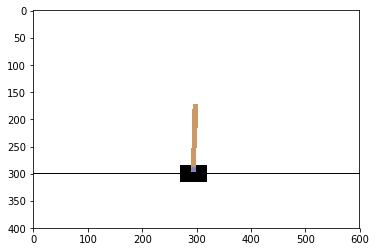

In [0]:
#make sure we got everything in place
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

### Approximate (deep) Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (L.Dense) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: agent's observations are not normalized so sigmoids may become saturated from init.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [0]:
import tensorflow as tf
import keras
import keras.layers as L
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

Using TensorFlow backend.


In [0]:
with tf.device('/gpu:0'):
  network = keras.models.Sequential()
  network.add(L.InputLayer(state_dim))
  # let's create a network for approximate q-learning following guidelines above
  #<YOUR CODE: stack more layers!!!1 >
  network.add(L.Dense(n_actions))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
import random

In [0]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = network.predict(state[None])[0]
    
    ###YOUR CODE
    if random.random() < epsilon:
      #?
    else:
      #?


    #return <epsilon-greedily selected action>


In [0]:
# checking you are good:
assert network.output_shape == (None, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert network.layers[-1].activation == keras.activations.linear, "please make sure you predict q-values without nonlinearity"

# test epsilon-greedy exploration
s = env.reset()
assert np.shape(get_action(s)) == (), "please return just one action (integer)"
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed'%eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `tf.stop_gradient` function which basically says "consider this thing constant when doingbackprop".

In [0]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
with tf.device('/gpu:0'):
  states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
  actions_ph = tf.placeholder('int32', shape=[None])
  rewards_ph = tf.placeholder('float32', shape=[None])
  next_states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
  is_done_ph = tf.placeholder('bool', shape=[None])

In [0]:
with tf.device('/gpu:0'):

  #get q-values for all actions in current states
  predicted_qvalues = network(states_ph)

  #select q-values for chosen actions
  predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, n_actions), axis=1) #notice the selection trick using one hot coding

In [0]:
gamma = 0.99
with tf.device('/gpu:0'):

  # compute q-values for all actions in next states
  predicted_next_qvalues = #<YOUR CODE - apply network to get q-values for next_states_ph>

  # compute V*(next_states) using predicted next q-values
  next_state_values =#<YOUR CODE> hint:  tf.reduce_max

  # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
  target_qvalues_for_actions = rewards_ph + gamma * next_state_values

  # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
  target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)

In [0]:
with tf.device('/gpu:0'):

  #mean squared error loss to minimize
  loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2
  loss = tf.reduce_mean(loss)

  # training function that resembles agent.update(state, action, reward, next_state) from tabular agent
  train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

Instructions for updating:
Use tf.cast instead.


In [0]:
#checking you are on the right path
assert tf.gradients(loss, [predicted_qvalues_for_actions])[0] is not None, "make sure you update q-values for chosen actions and not just all actions"
assert tf.gradients(loss, [predicted_next_qvalues])[0] is None, "make sure you don't propagate gradient w.r.t. Q_(s',a')"
assert predicted_next_qvalues.shape.ndims == 2, "make sure you predicted q-values for all actions in next state"
assert next_state_values.shape.ndims == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
assert target_qvalues_for_actions.shape.ndims == 1, "there's something wrong with target q-values, they must be a vector"
print('good job')

good job


In [0]:
# Playing
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            sess.run(train_step,{
                states_ph: [s], actions_ph: [a], rewards_ph: [r], 
                next_states_ph: [next_s], is_done_ph: [done]
            })

        total_reward += r
        s = next_s
        if done: break
    #print(t)
    return total_reward

![alt text](https://cdn-images-1.medium.com/max/1600/1*LqQEd7iO2ECwEzW2vG0OBw.png)

In [0]:
epsilon = 0.5
for i in range(1000):
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 300:
        print ("You Win!")
        break


epoch #0	mean reward = 13.280	epsilon = 0.500
epoch #1	mean reward = 13.180	epsilon = 0.495
epoch #2	mean reward = 13.660	epsilon = 0.490
epoch #3	mean reward = 13.300	epsilon = 0.485
epoch #4	mean reward = 13.530	epsilon = 0.480
epoch #5	mean reward = 12.970	epsilon = 0.475
epoch #6	mean reward = 13.650	epsilon = 0.471
epoch #7	mean reward = 13.350	epsilon = 0.466
epoch #8	mean reward = 13.650	epsilon = 0.461
epoch #9	mean reward = 14.080	epsilon = 0.457
epoch #10	mean reward = 12.980	epsilon = 0.452
epoch #11	mean reward = 14.450	epsilon = 0.448
epoch #12	mean reward = 14.890	epsilon = 0.443
epoch #13	mean reward = 16.600	epsilon = 0.439
epoch #14	mean reward = 22.440	epsilon = 0.434
epoch #15	mean reward = 26.840	epsilon = 0.430
epoch #16	mean reward = 40.390	epsilon = 0.426
epoch #17	mean reward = 27.460	epsilon = 0.421
epoch #18	mean reward = 49.320	epsilon = 0.417
epoch #19	mean reward = 55.980	epsilon = 0.413
epoch #20	mean reward = 57.700	epsilon = 0.409
epoch #21	mean reward =

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

In [0]:
!pip install JSAnimation
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))


  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation


999



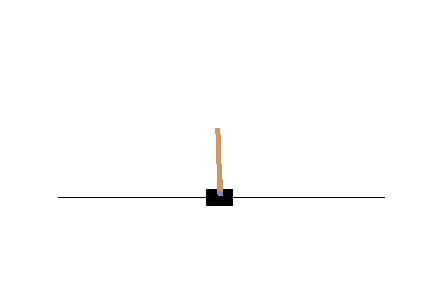
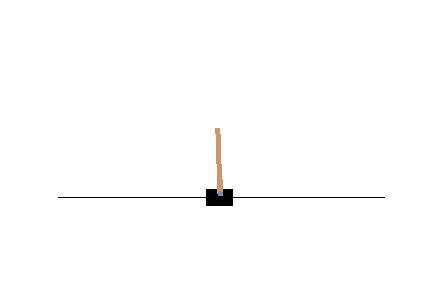
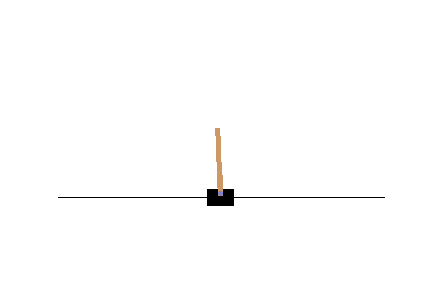
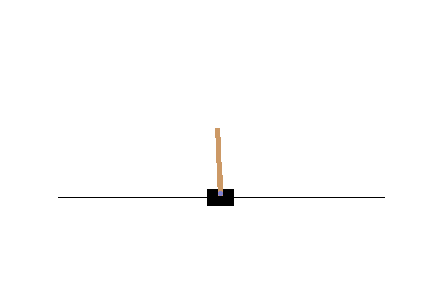
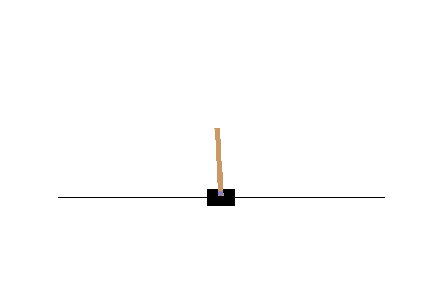
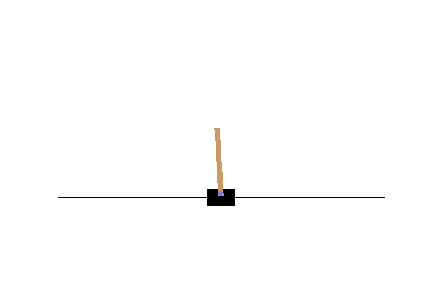
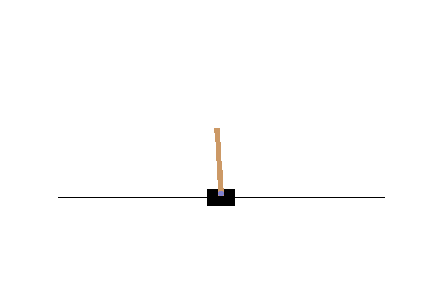
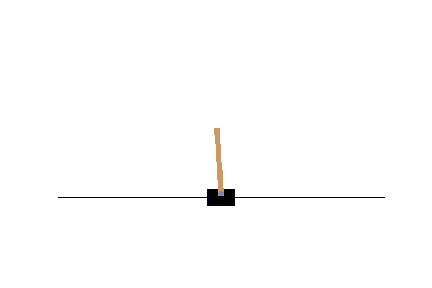
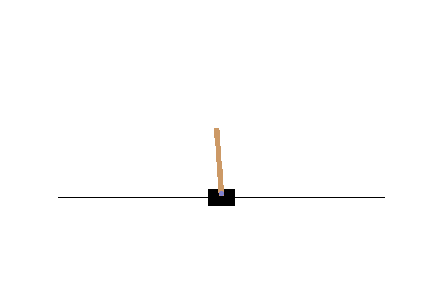
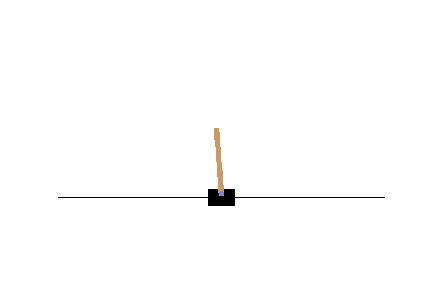
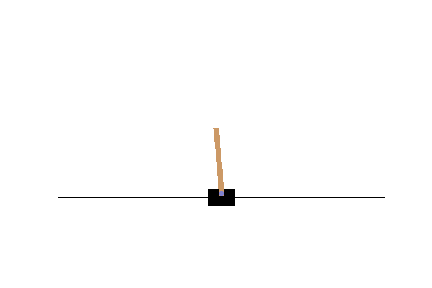
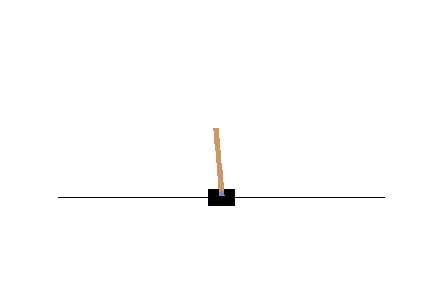
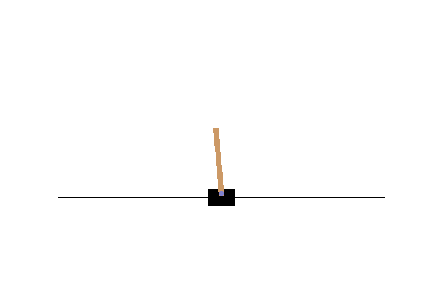
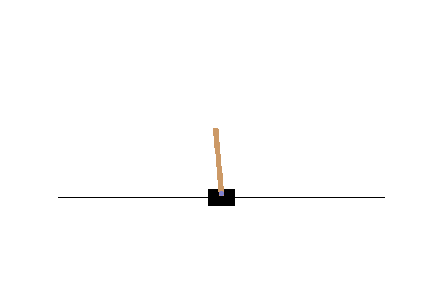
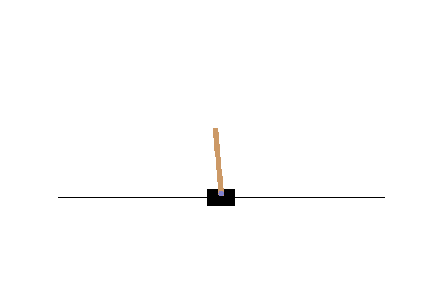
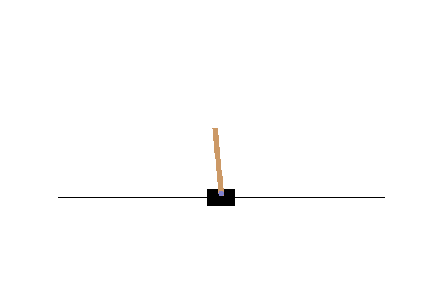
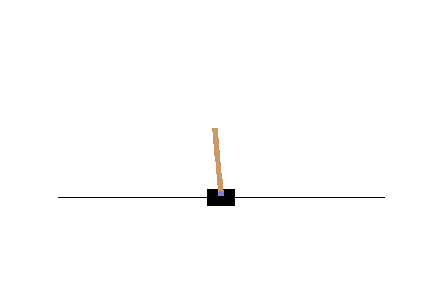
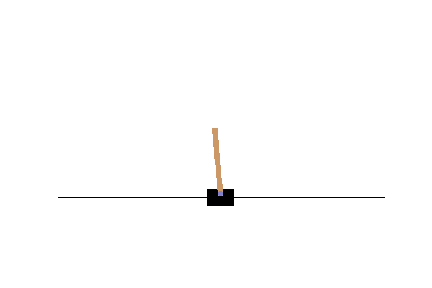
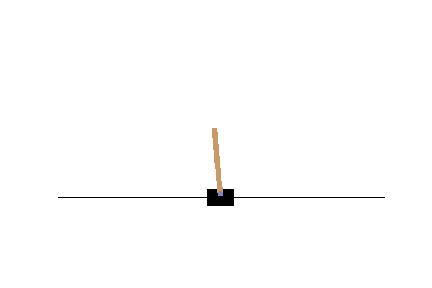
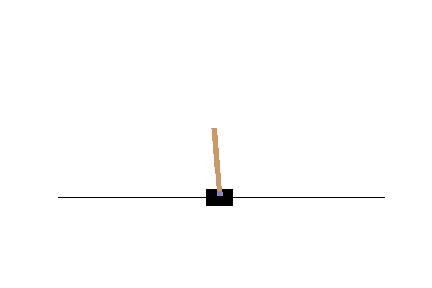
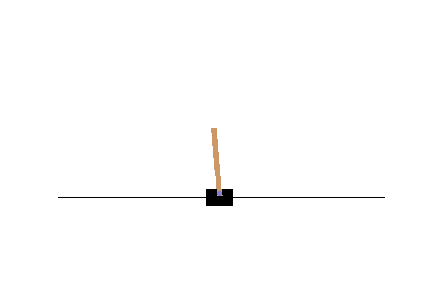
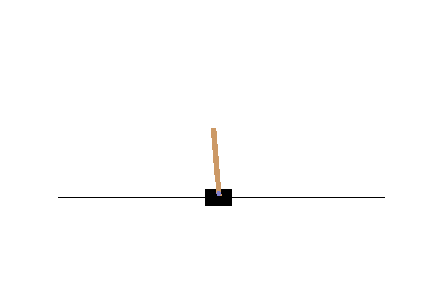
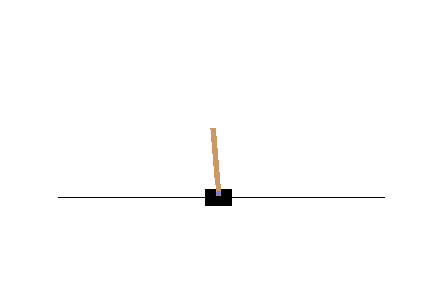
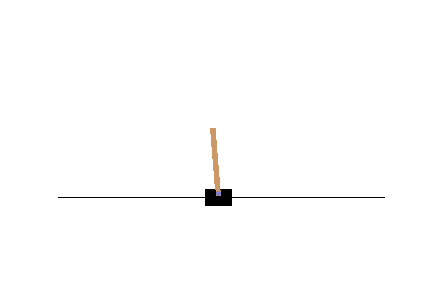
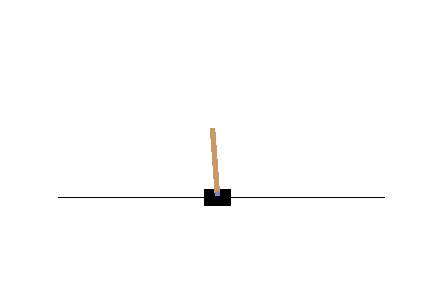
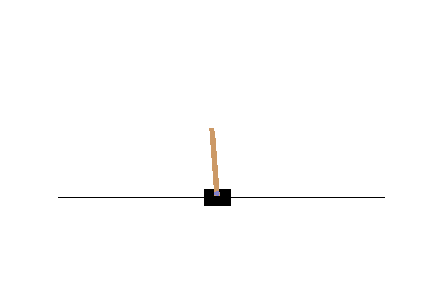
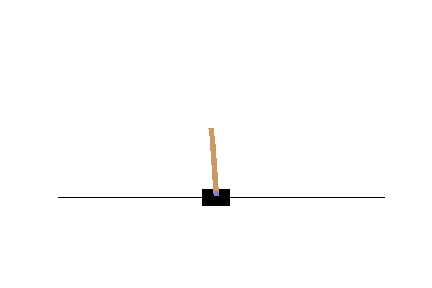
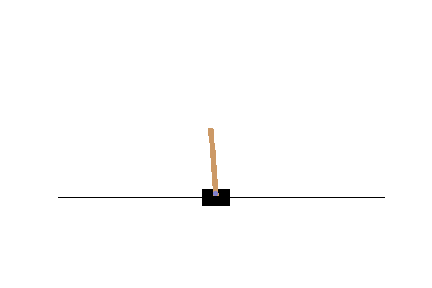
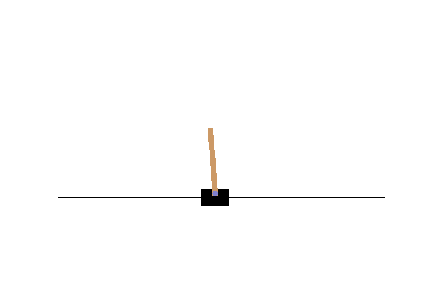
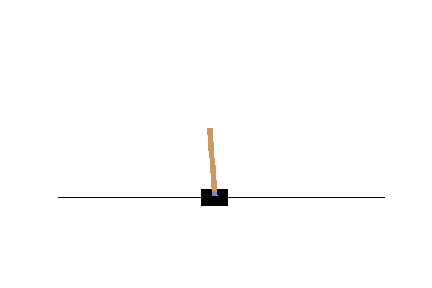
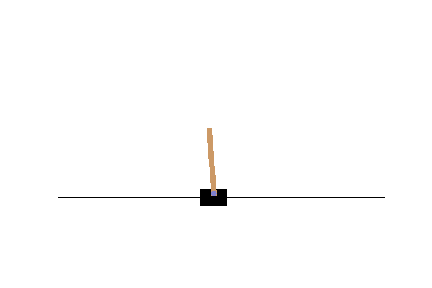
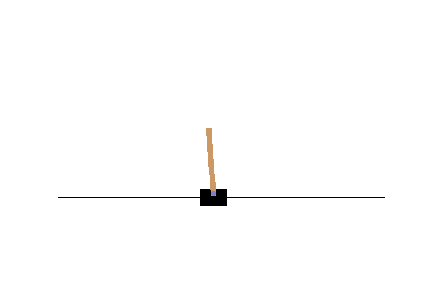
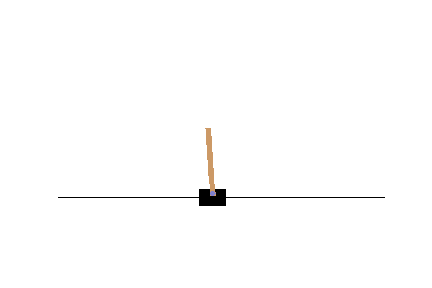
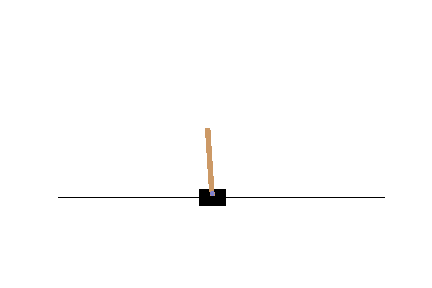
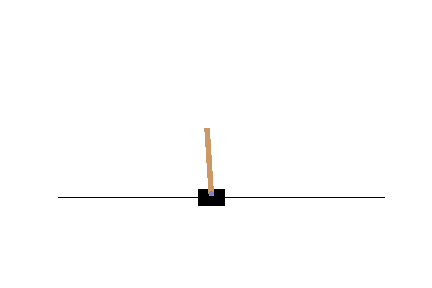
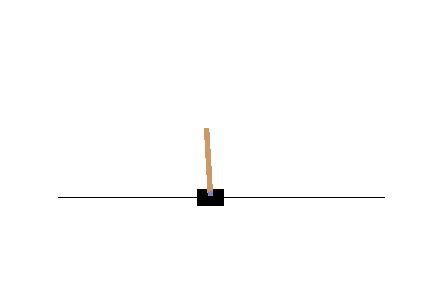
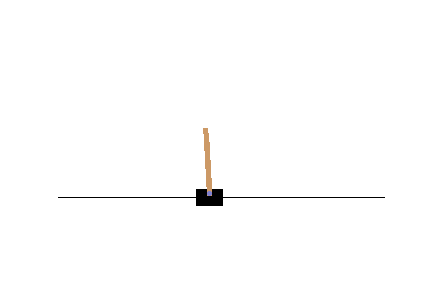
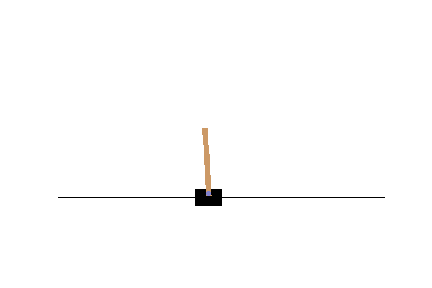
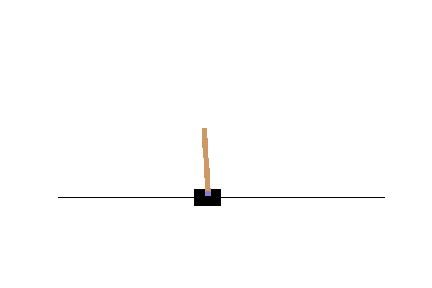
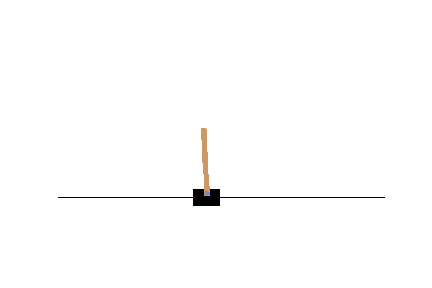
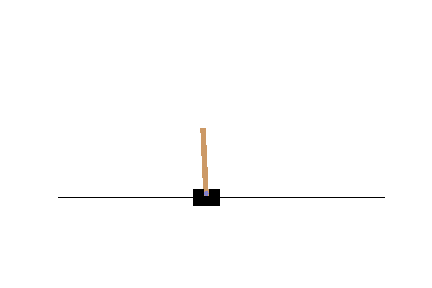
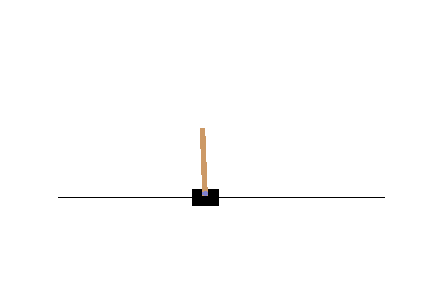
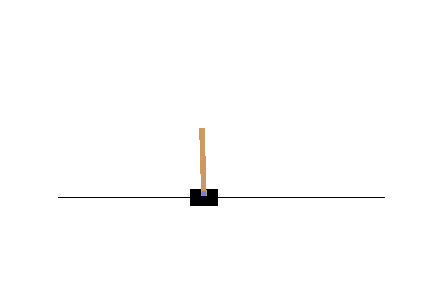
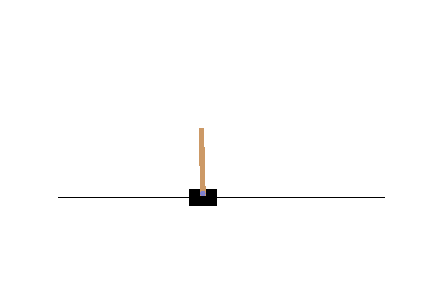
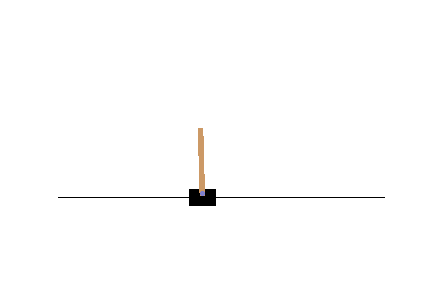
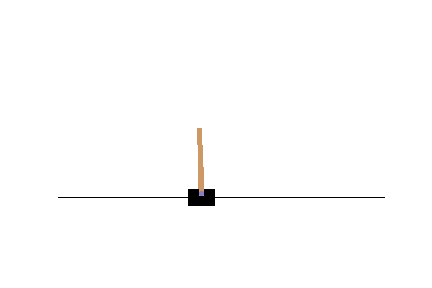
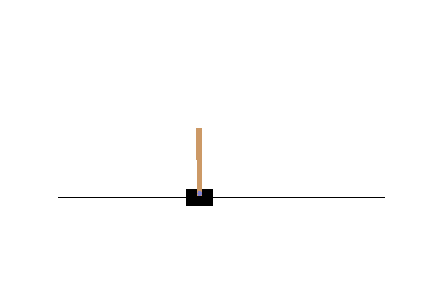
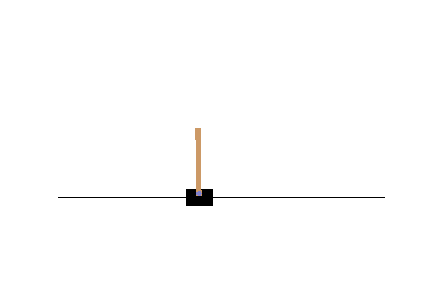
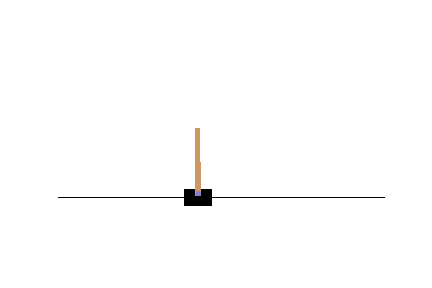
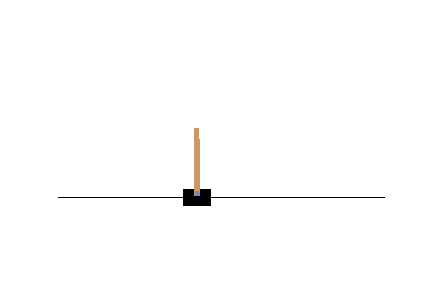
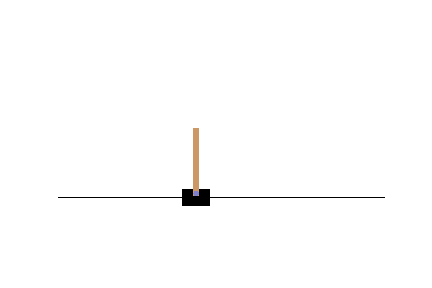
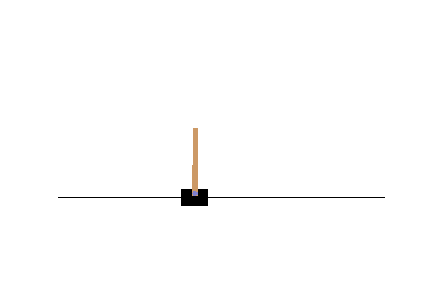
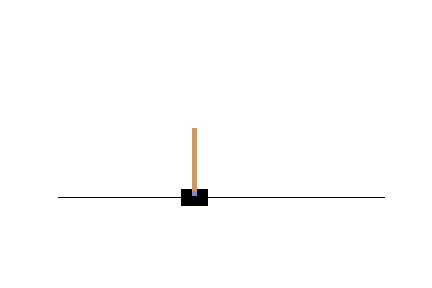
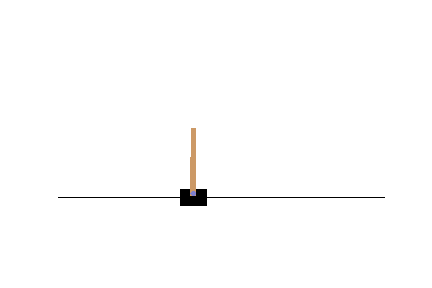
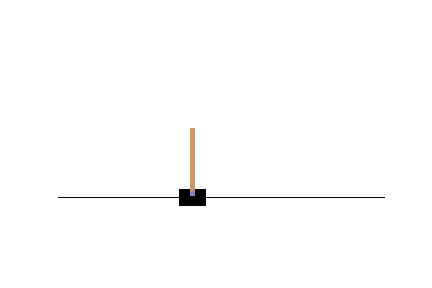
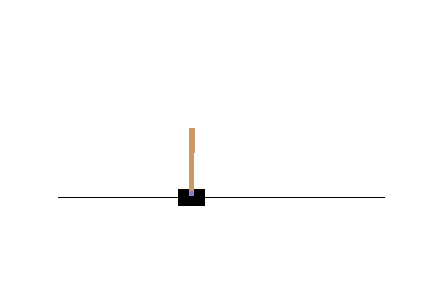
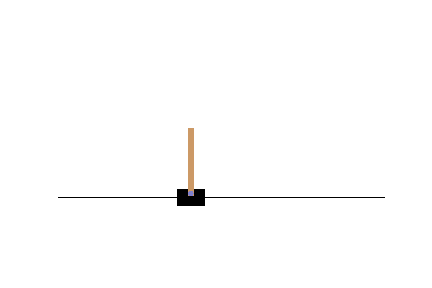
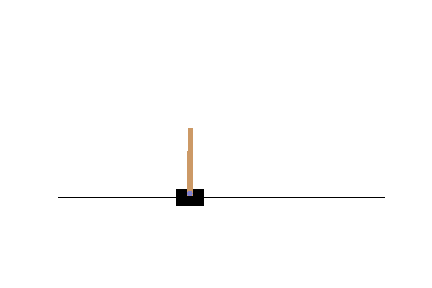
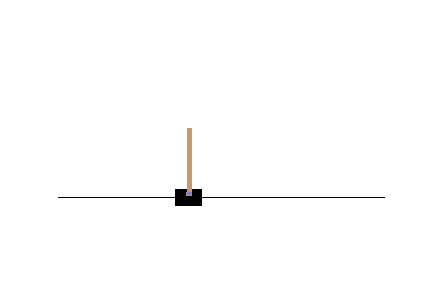
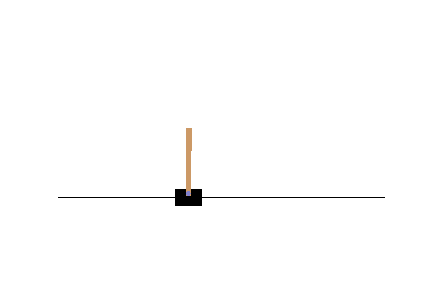
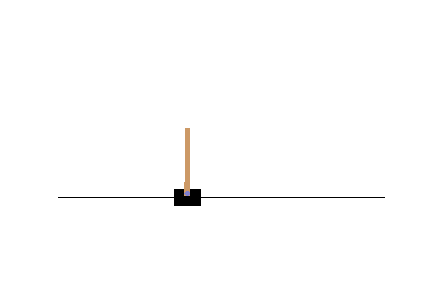
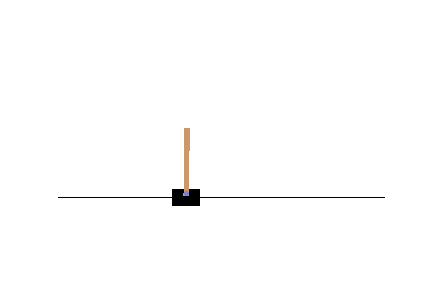
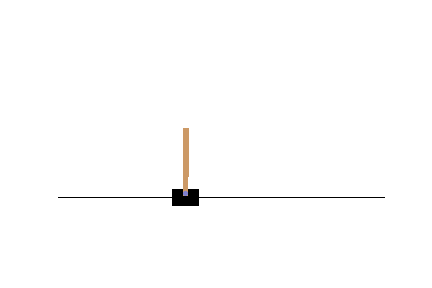
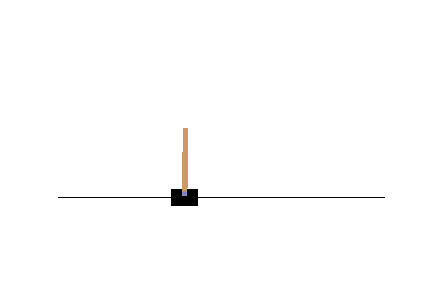
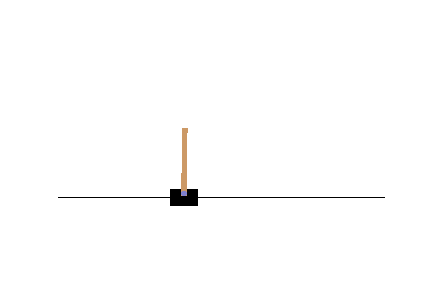
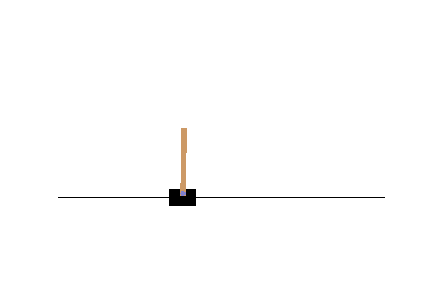
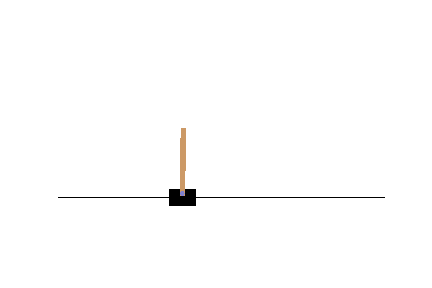
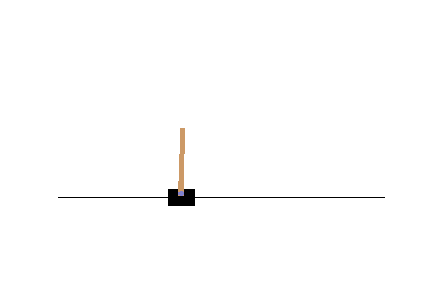
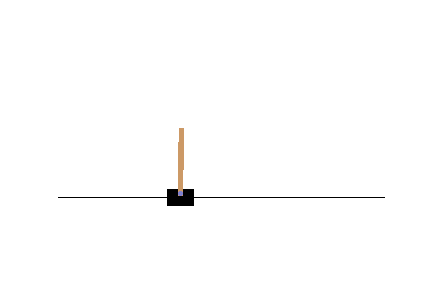
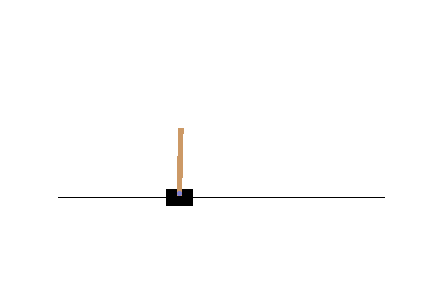
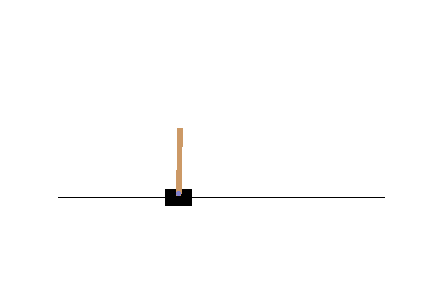
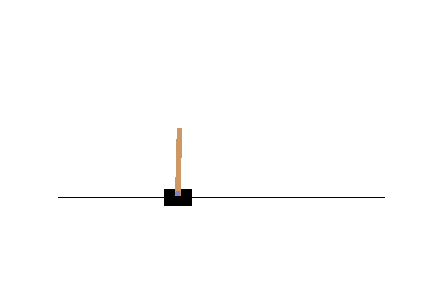
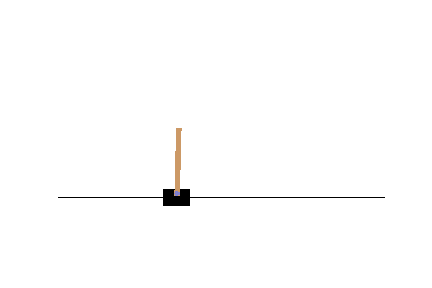
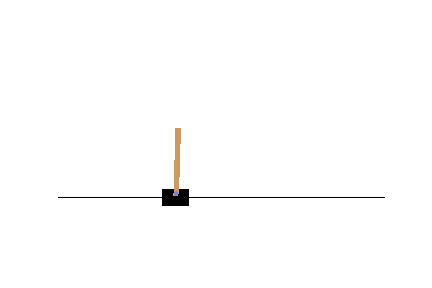
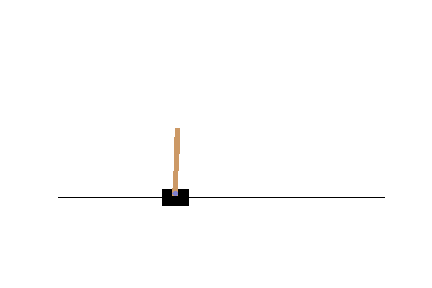
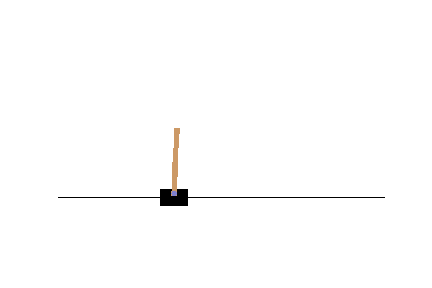
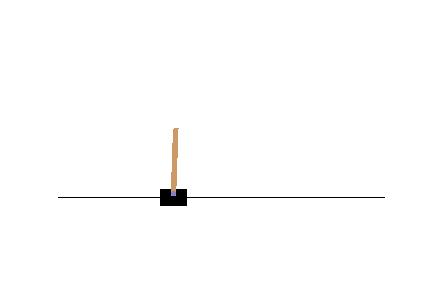
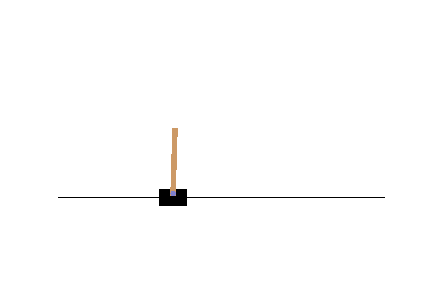
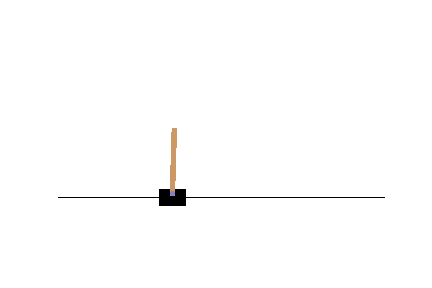
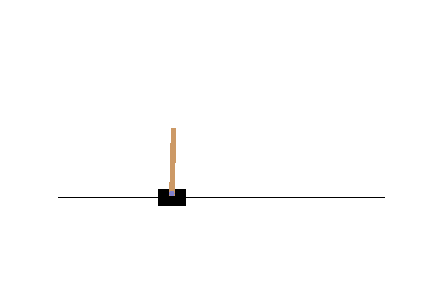
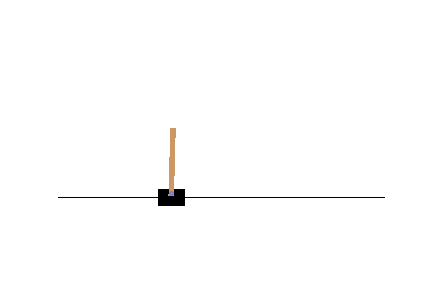
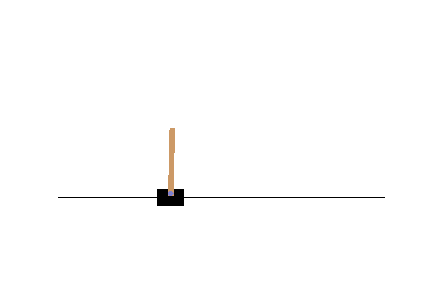
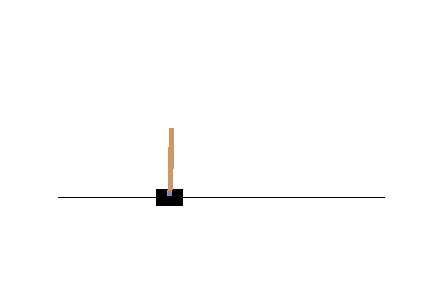
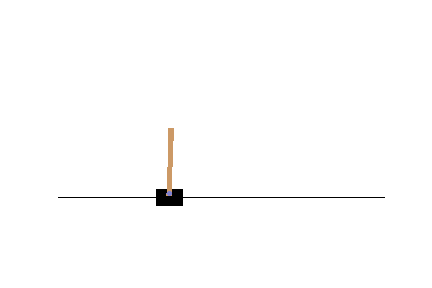
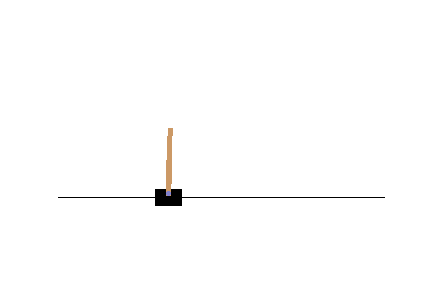
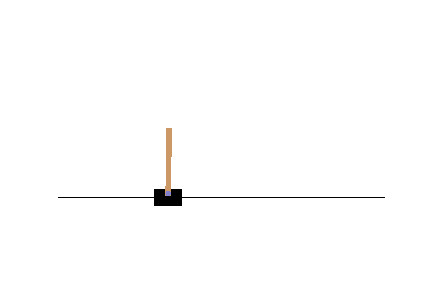
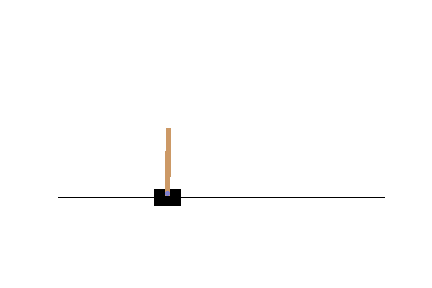
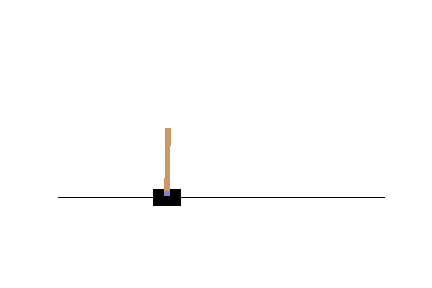
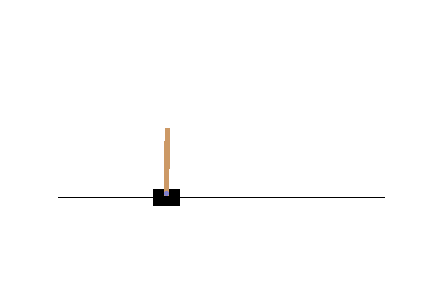
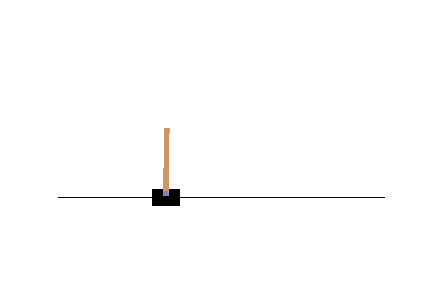
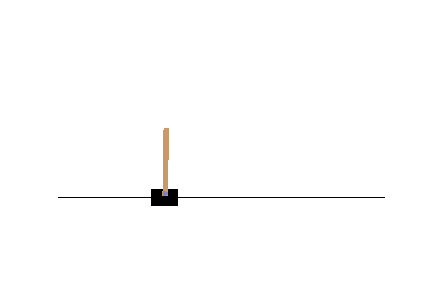
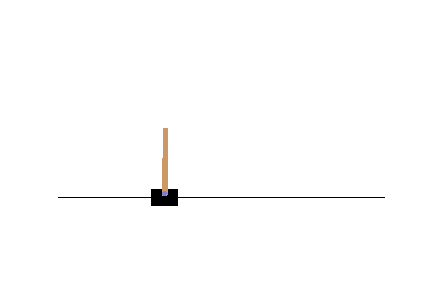
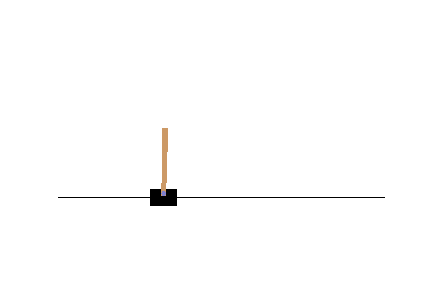
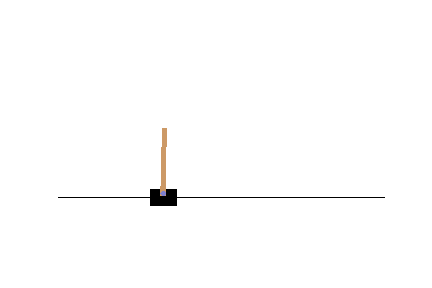
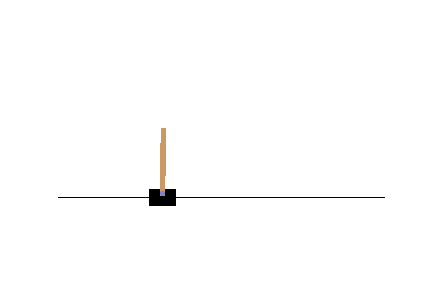
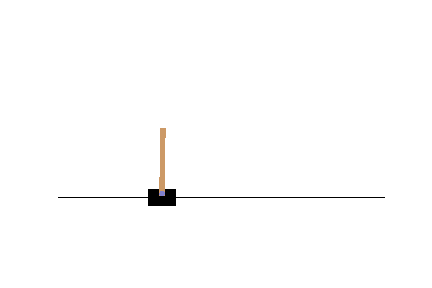
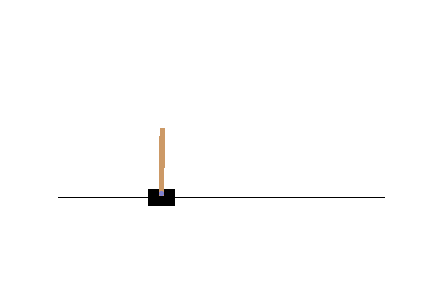
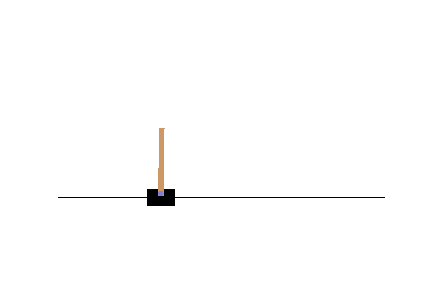
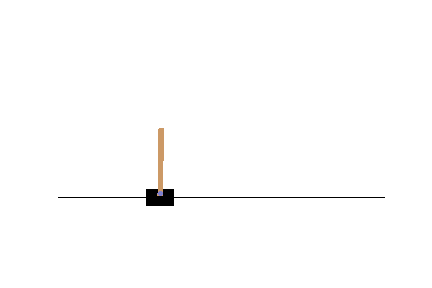
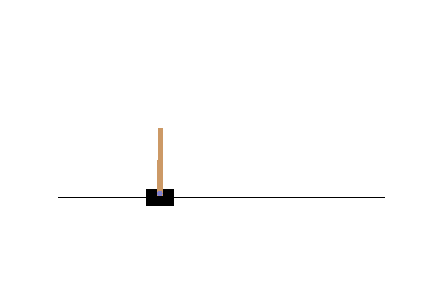
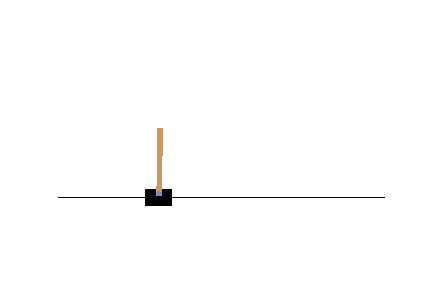
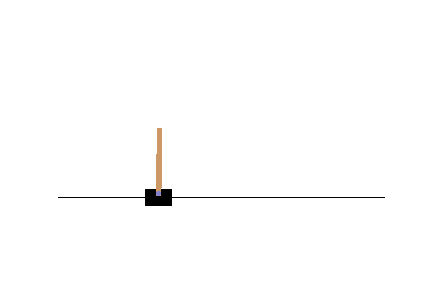
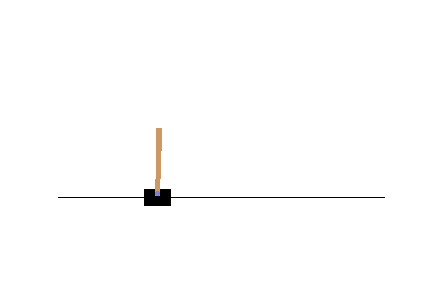
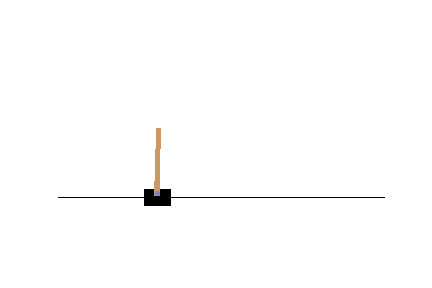
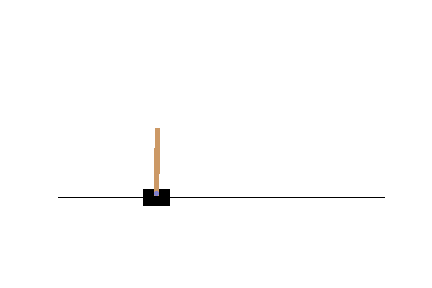
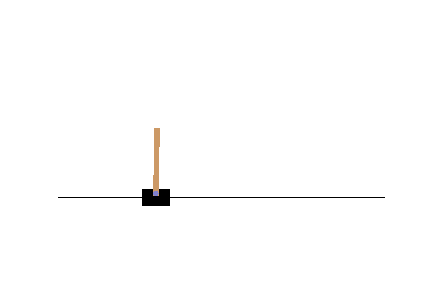
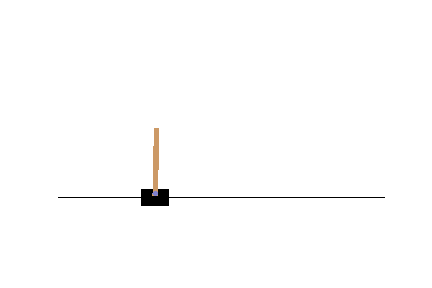
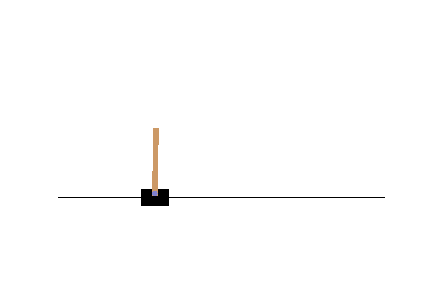
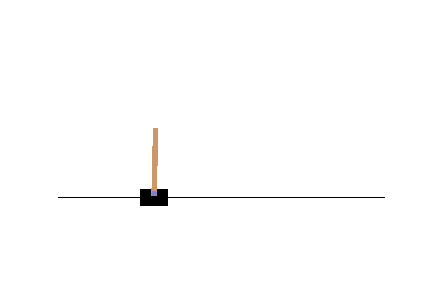
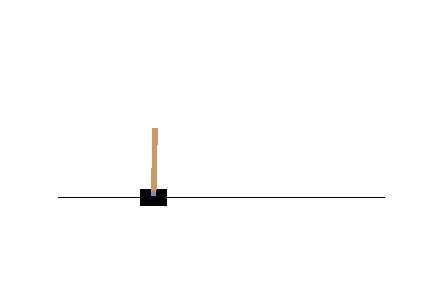
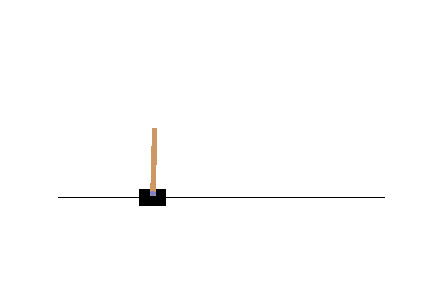
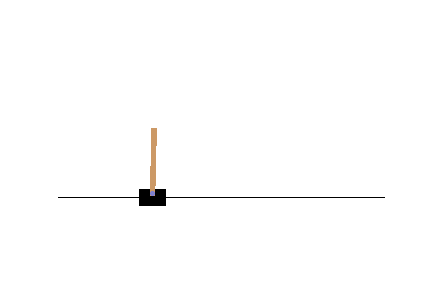
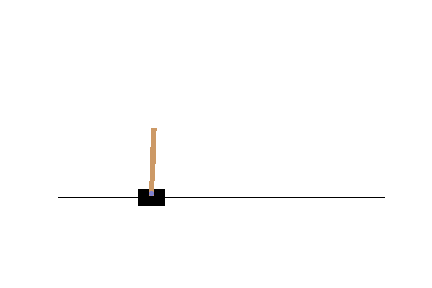
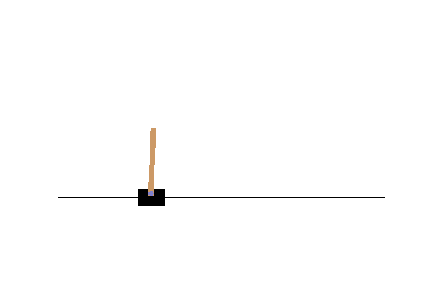
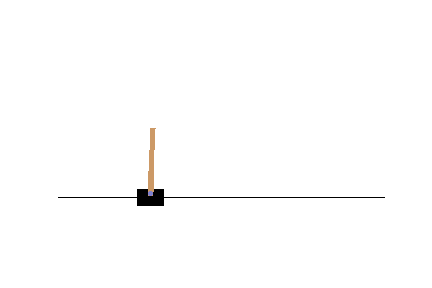
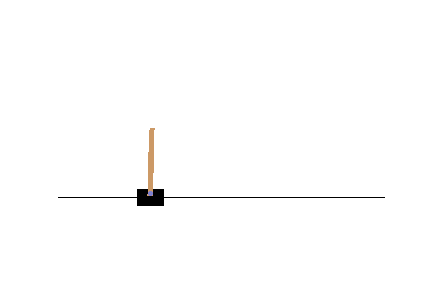
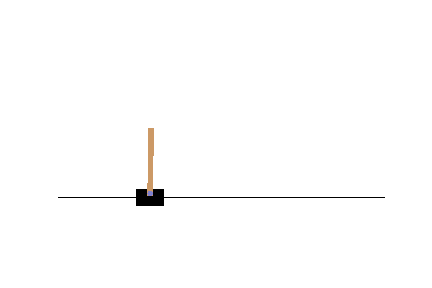
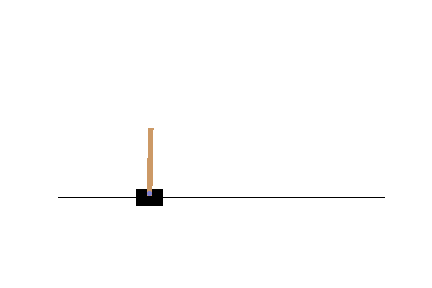
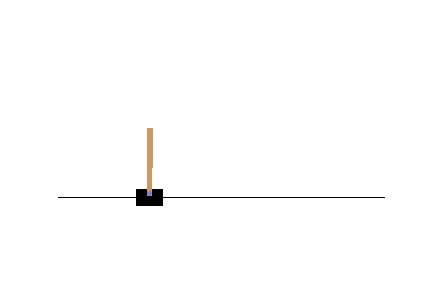
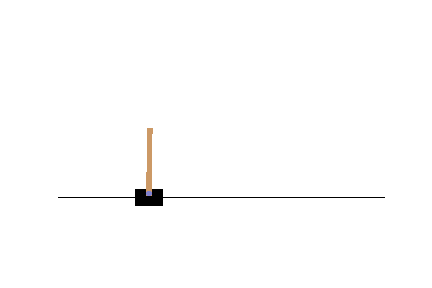
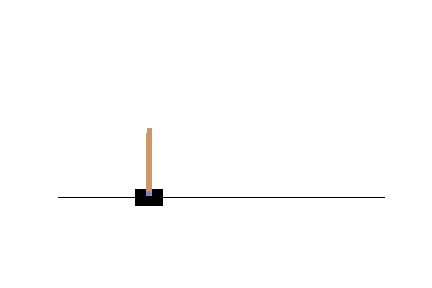
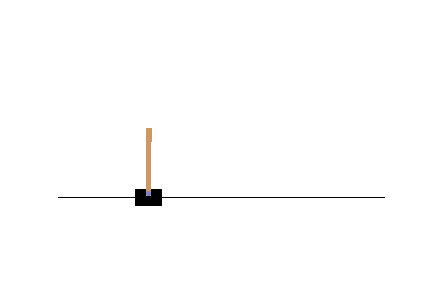
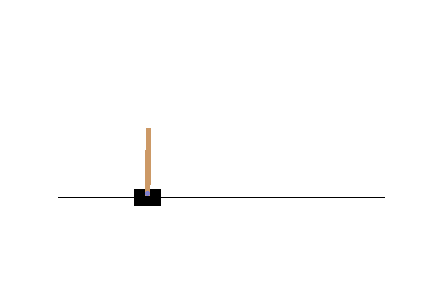
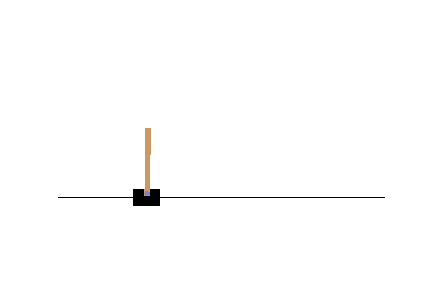
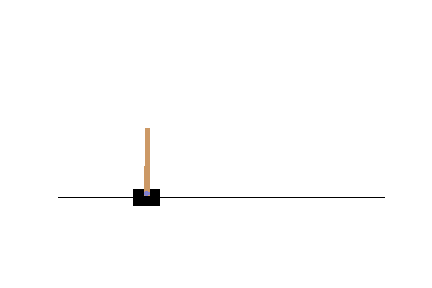
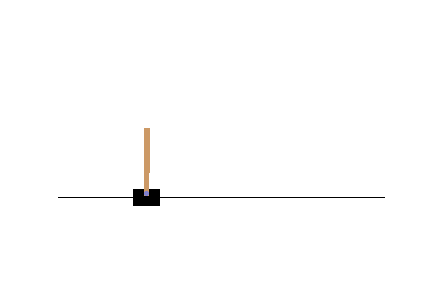
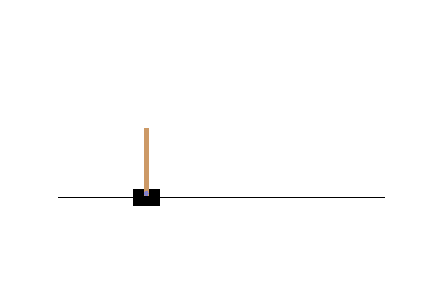
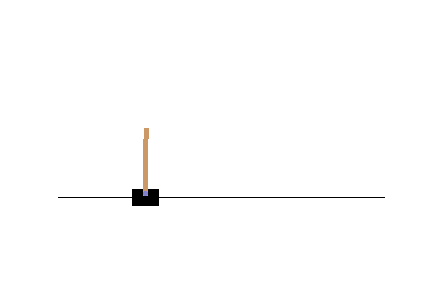
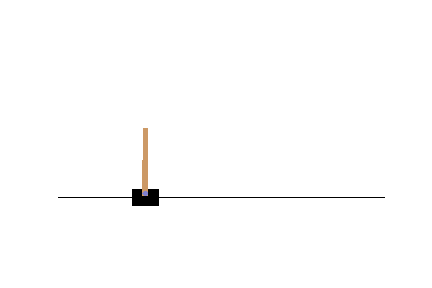
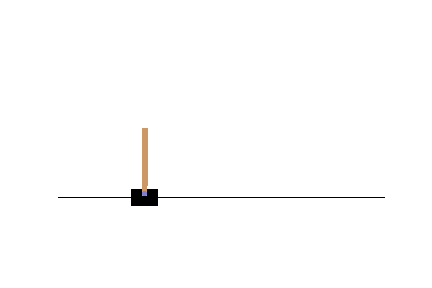
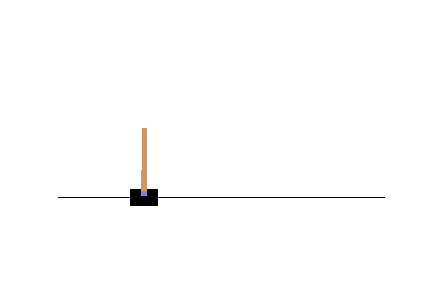
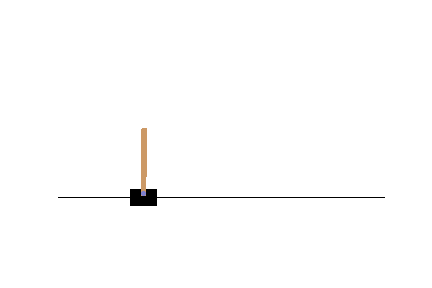
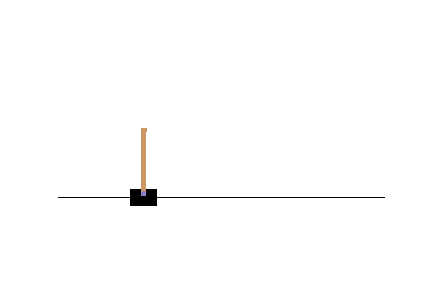
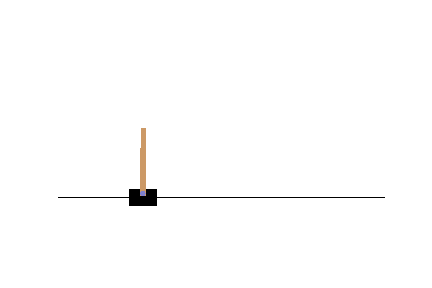
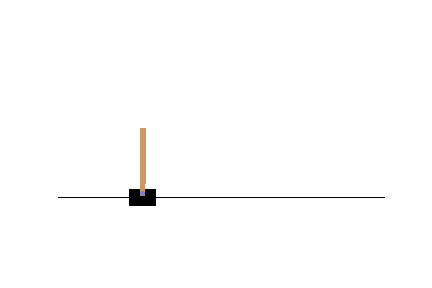
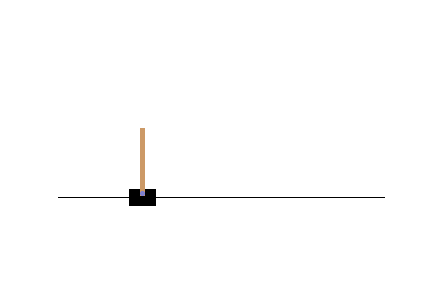
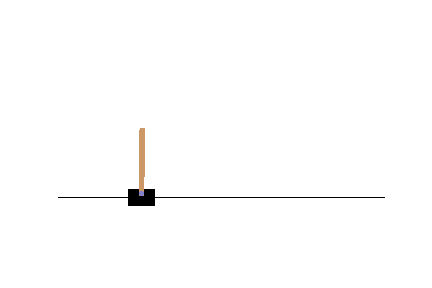
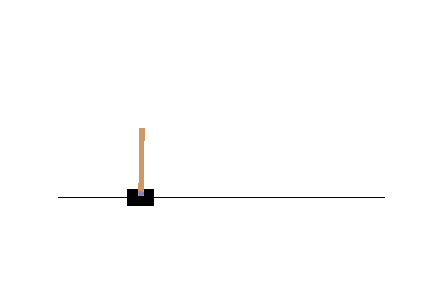
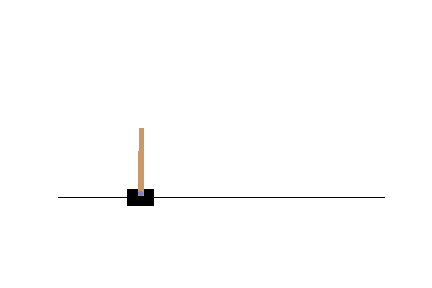
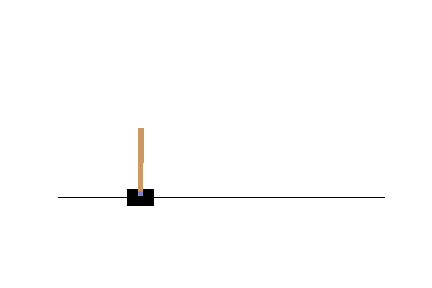
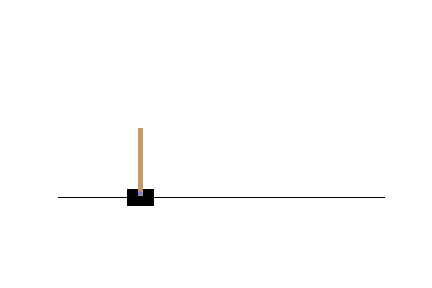
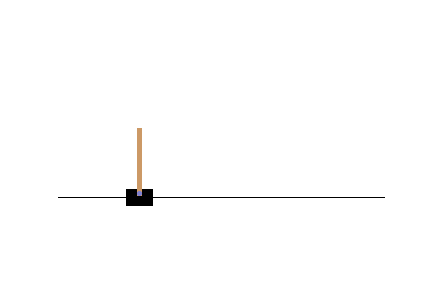
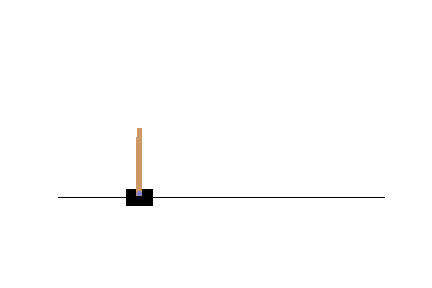
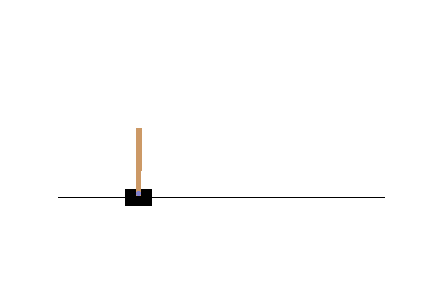
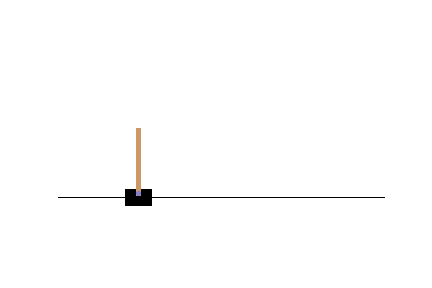
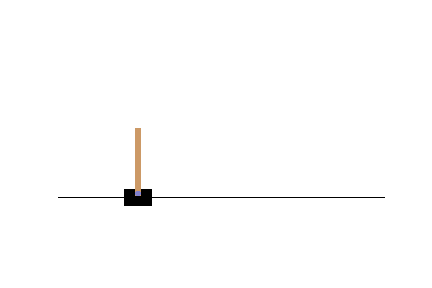
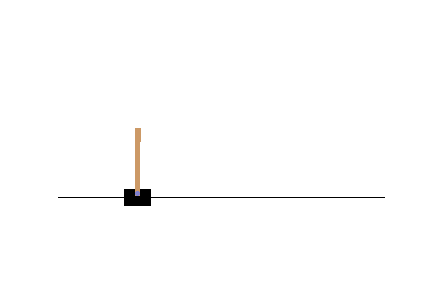
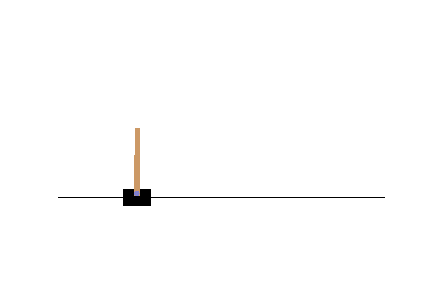
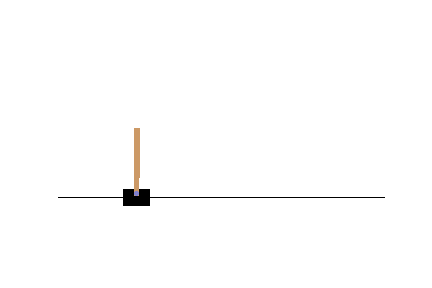
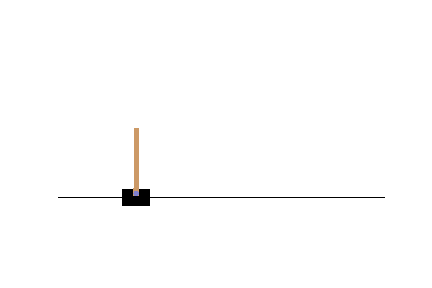
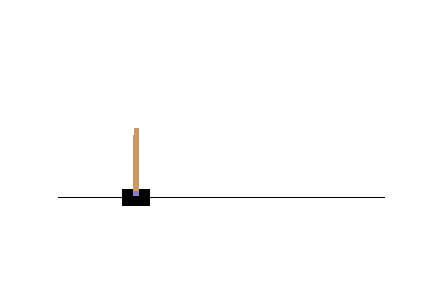
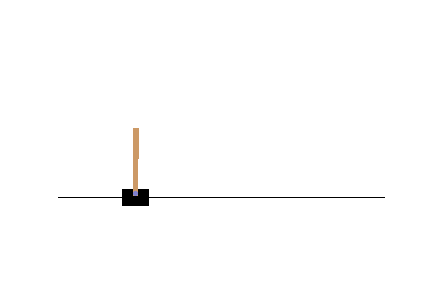
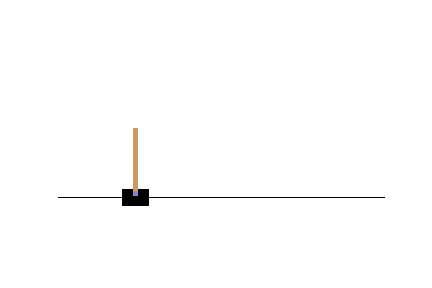
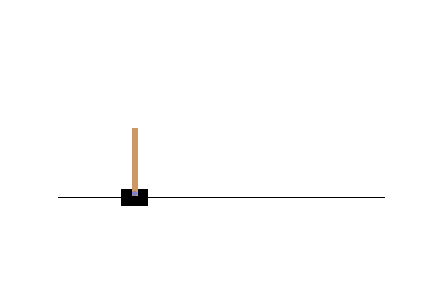
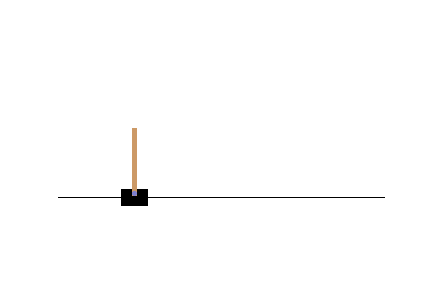
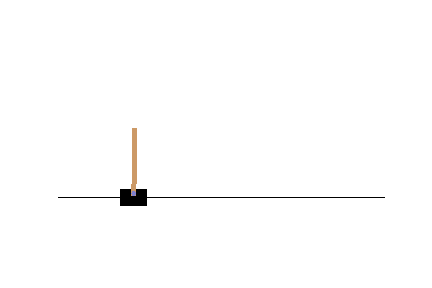
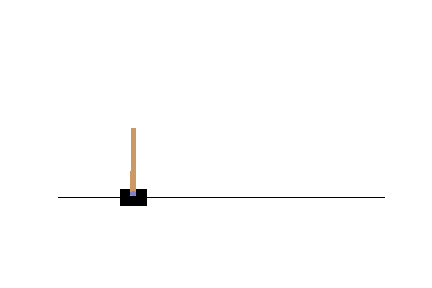
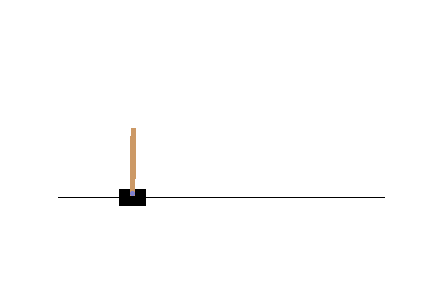
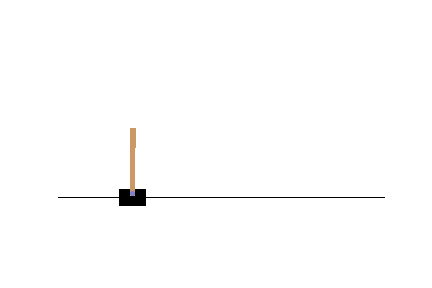
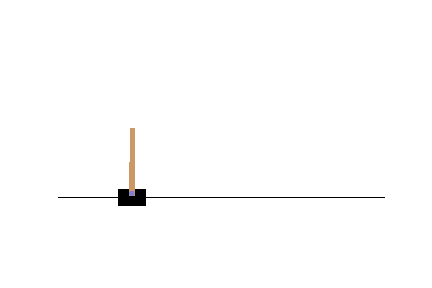
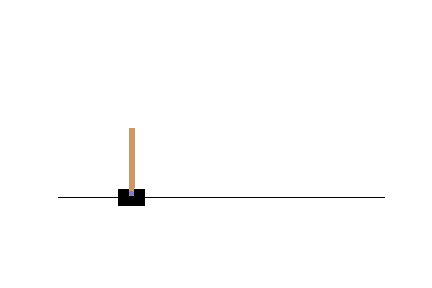
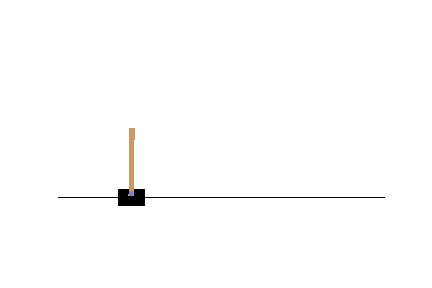
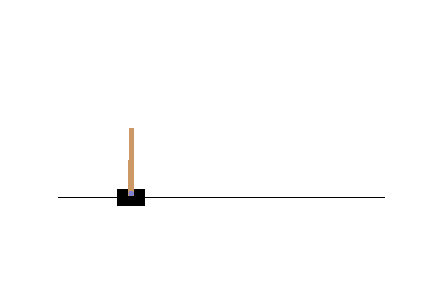
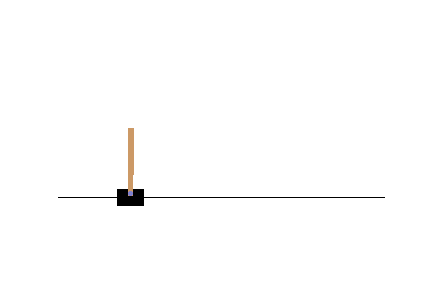
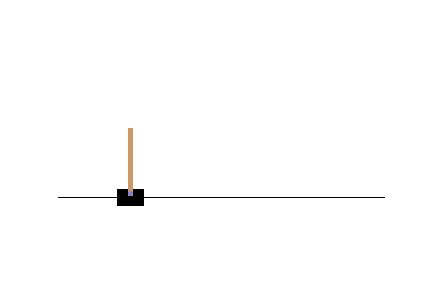
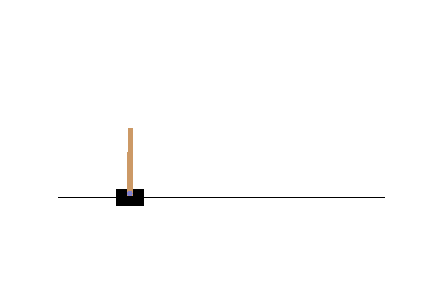
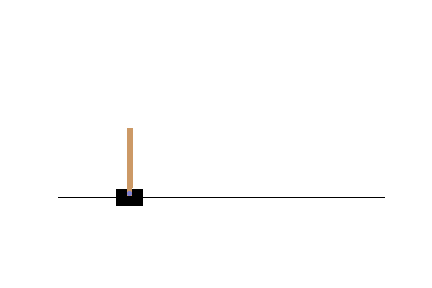
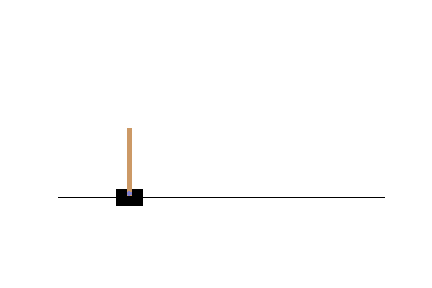
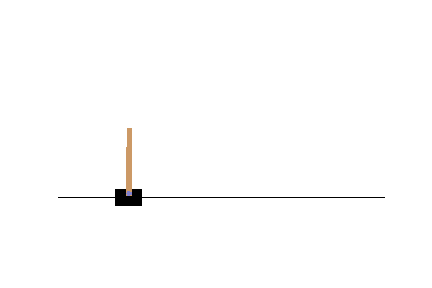
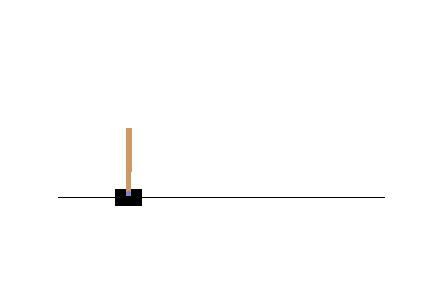
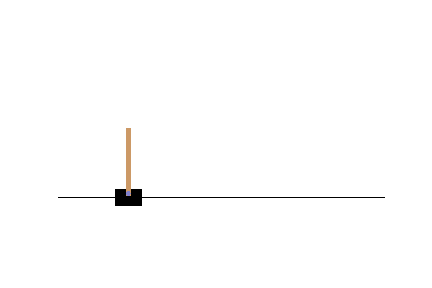
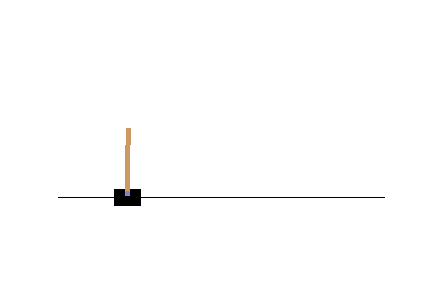
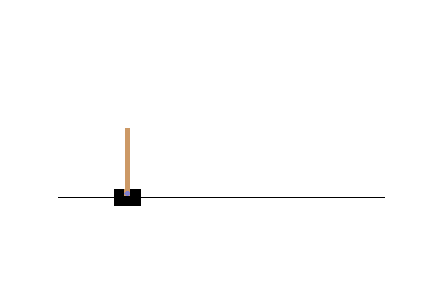
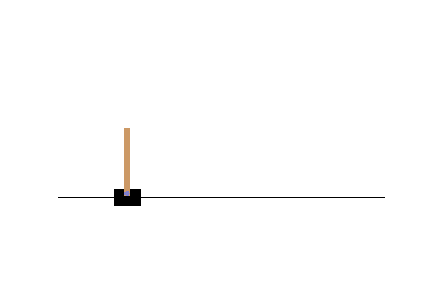
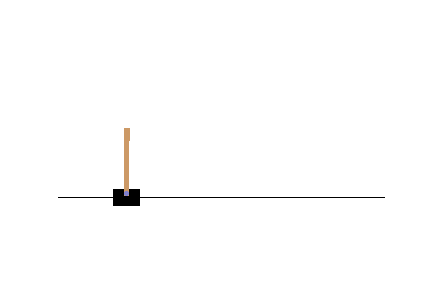
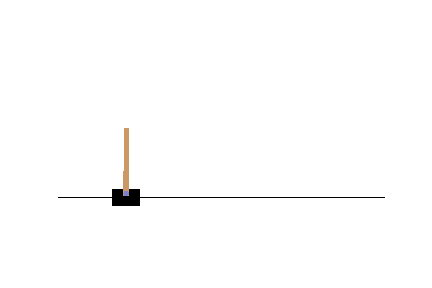
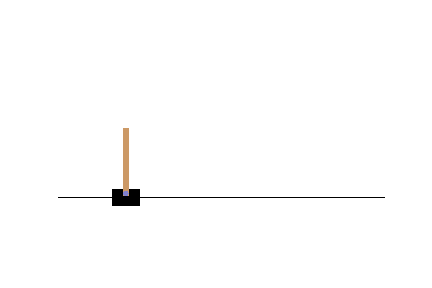
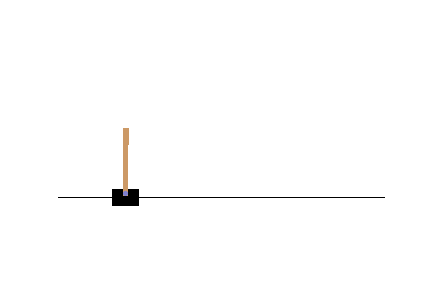
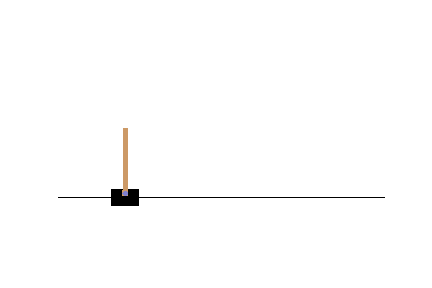
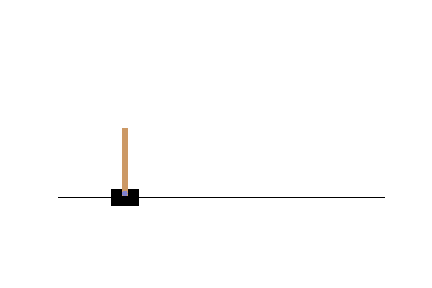
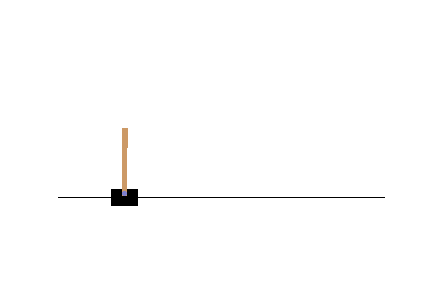
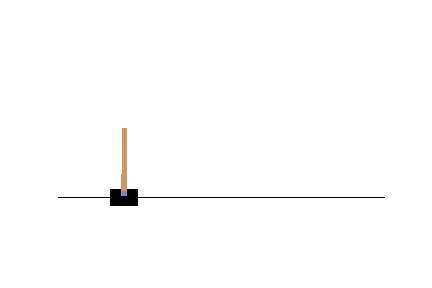
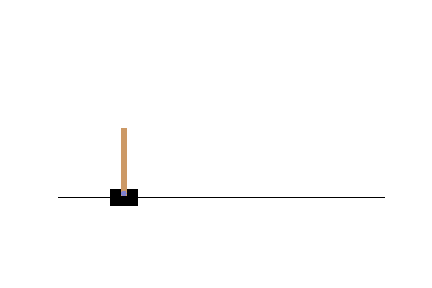
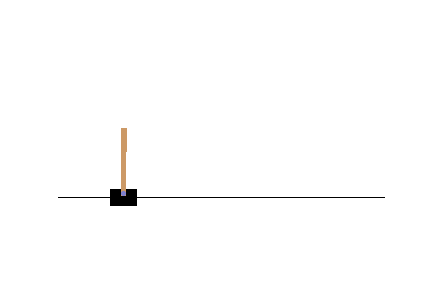
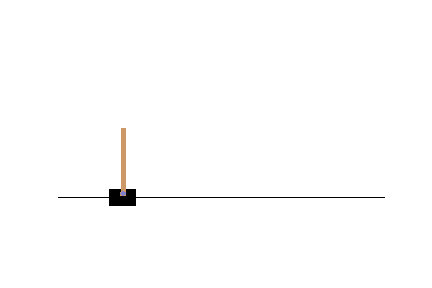
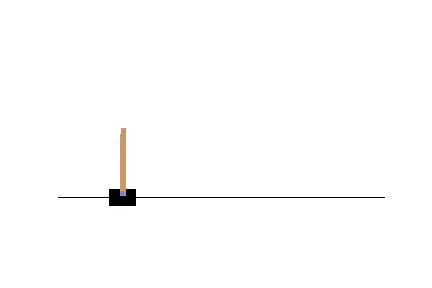
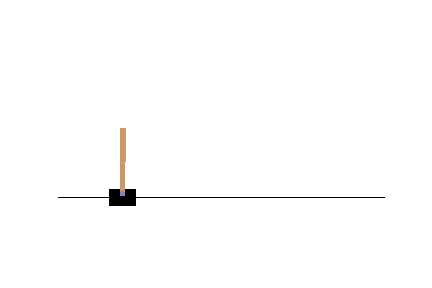
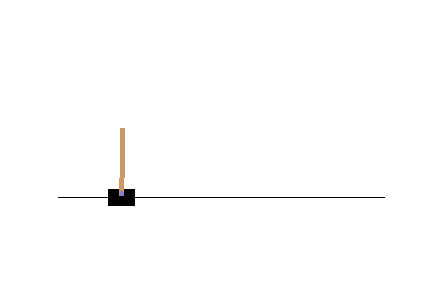
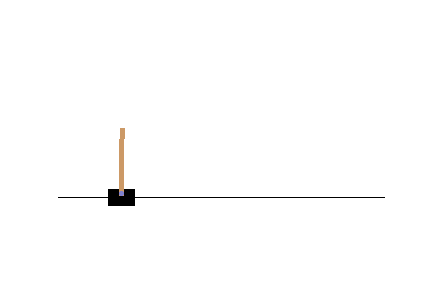
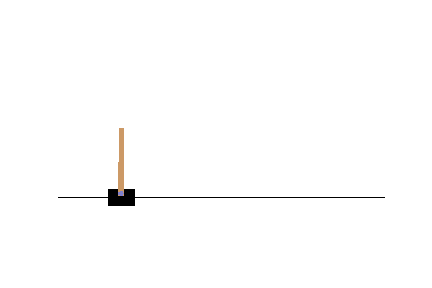
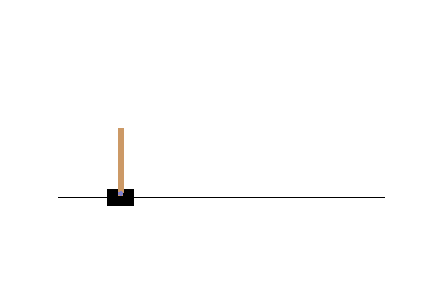
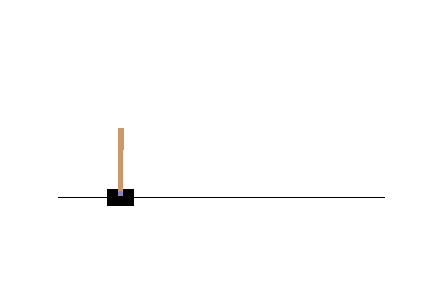
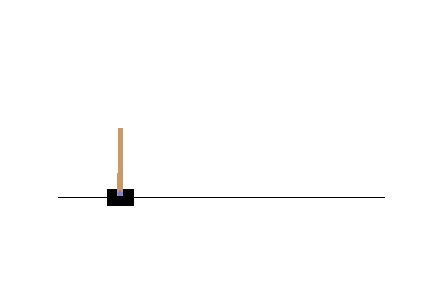
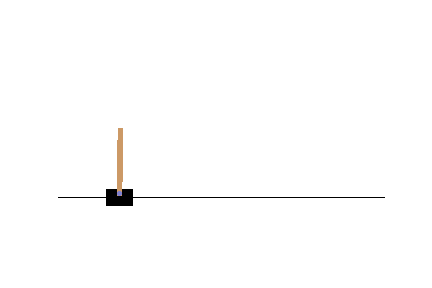
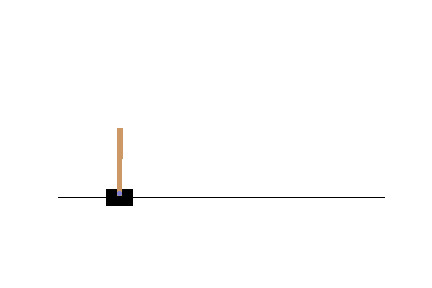
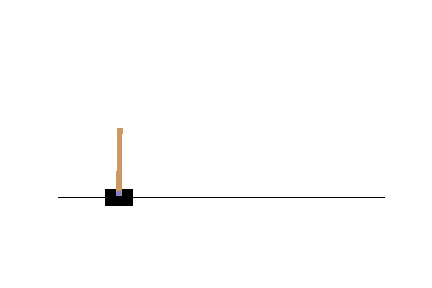
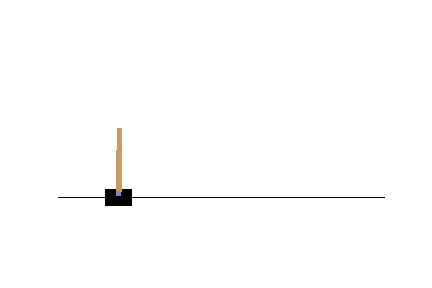
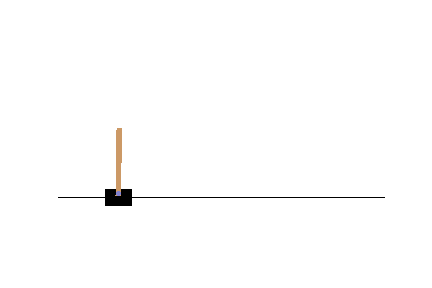
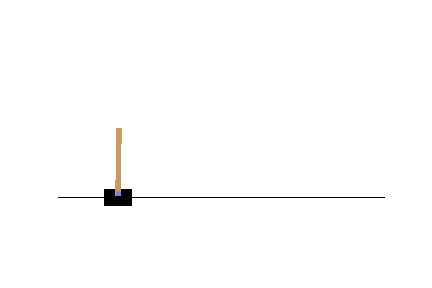
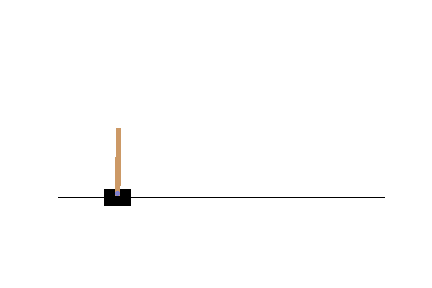
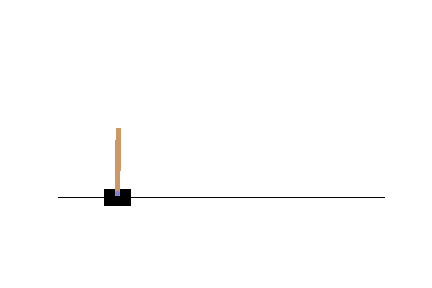
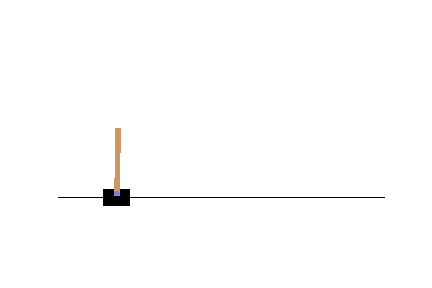
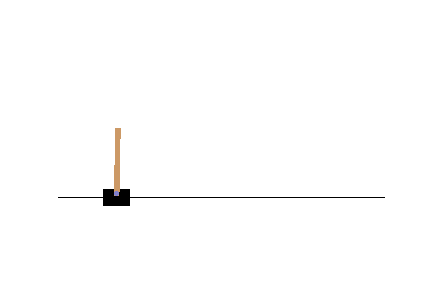
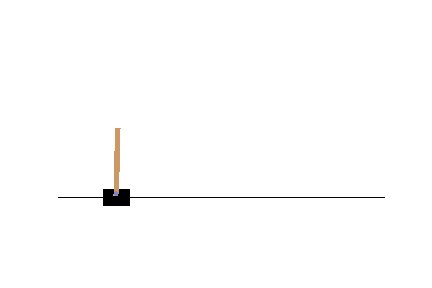
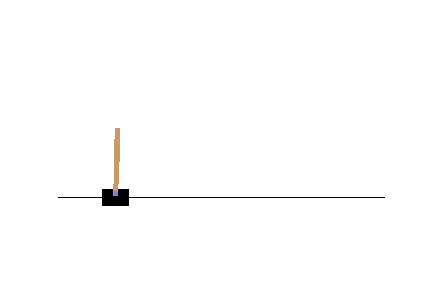
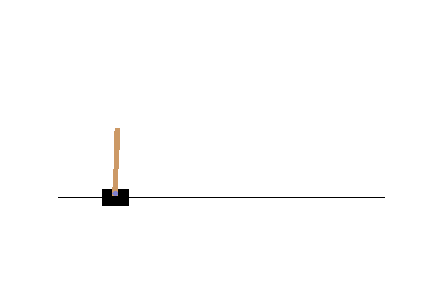
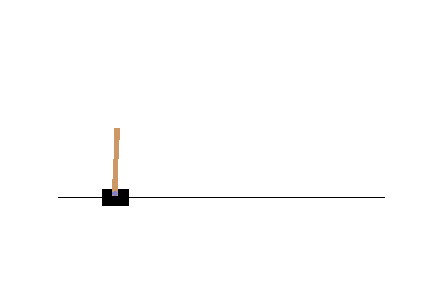
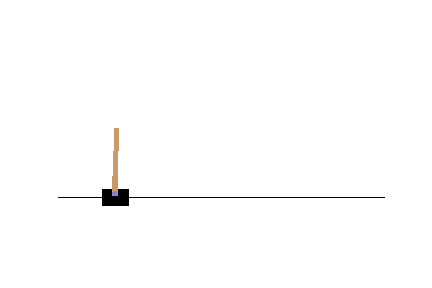
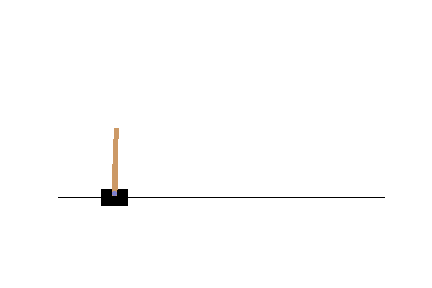
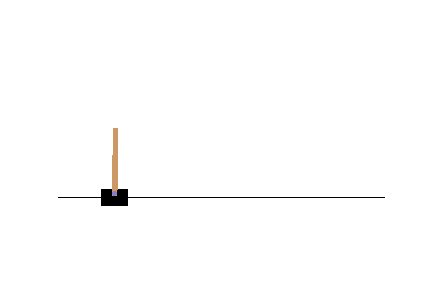
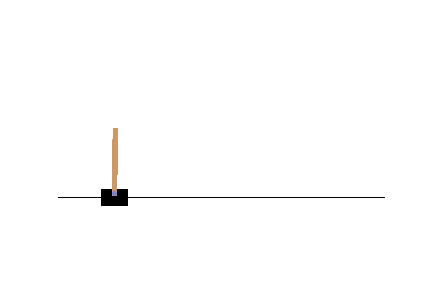
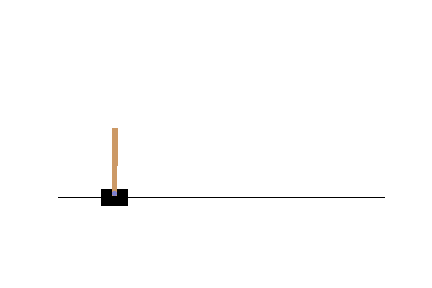
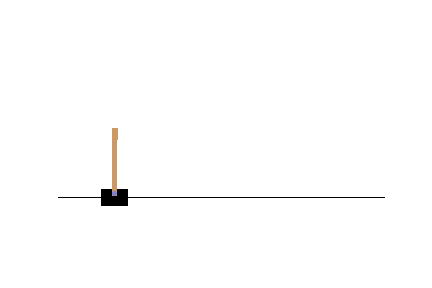
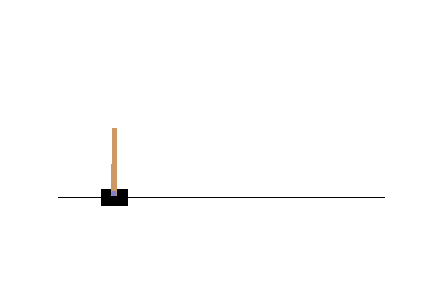
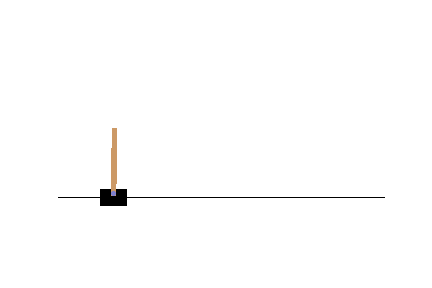
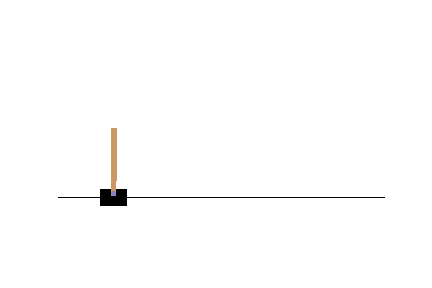
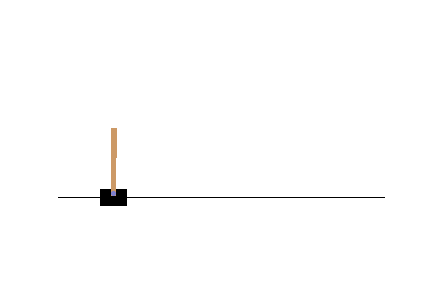
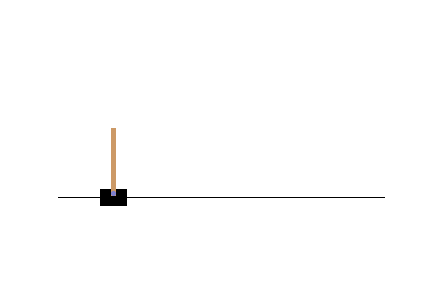
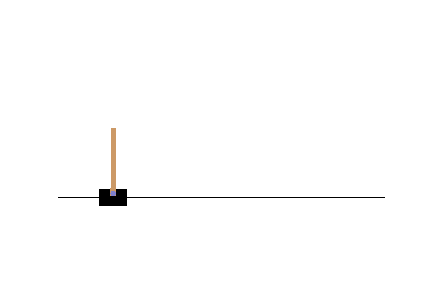
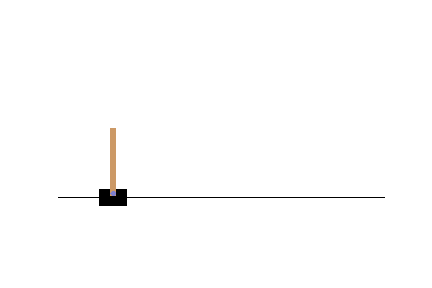
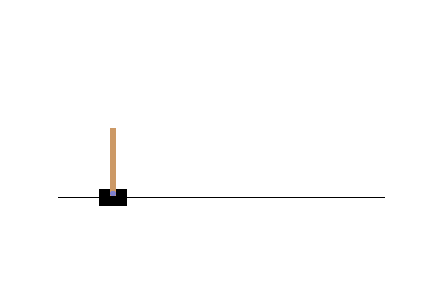
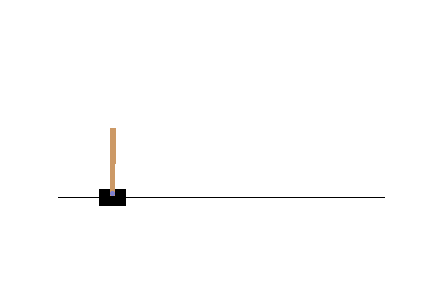
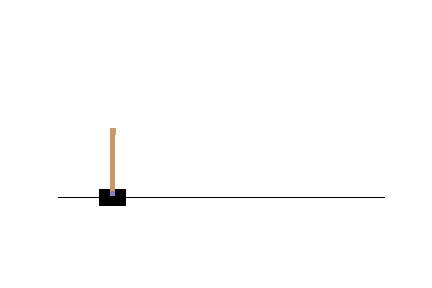
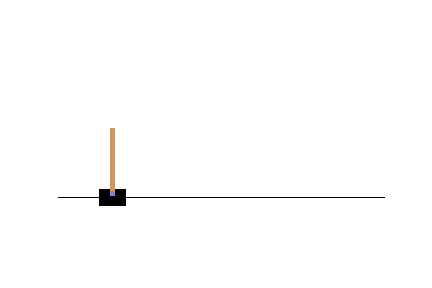
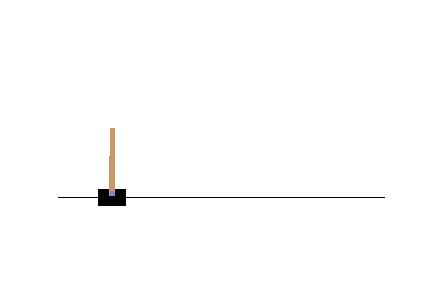
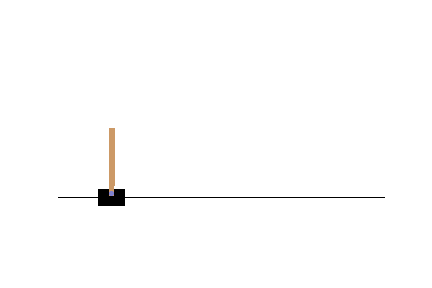
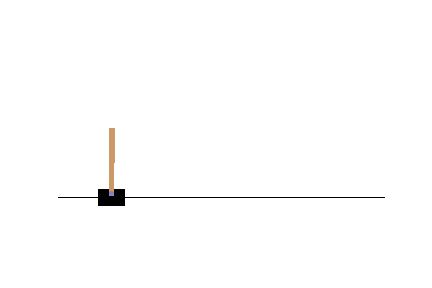
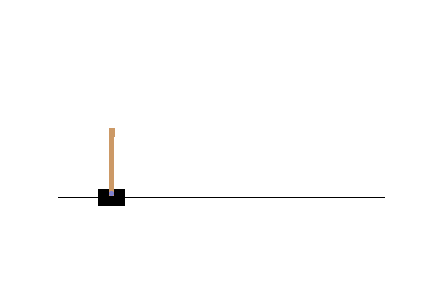
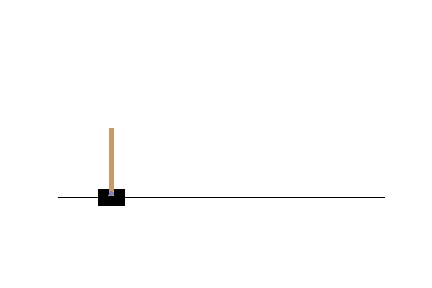
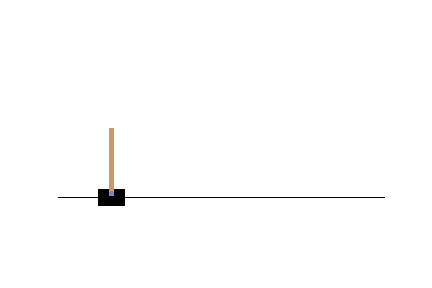
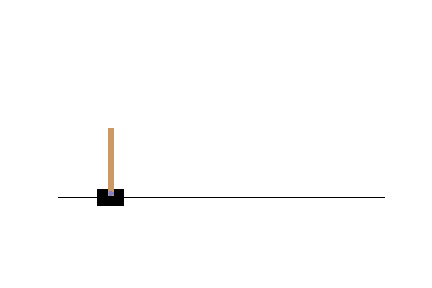
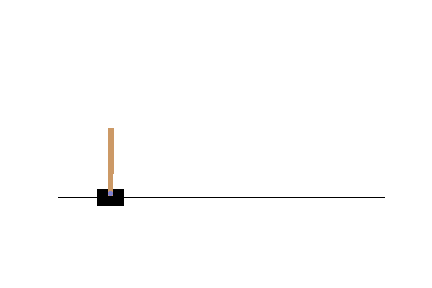
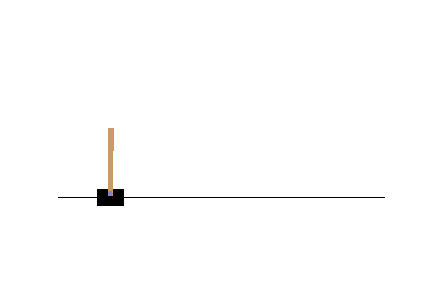
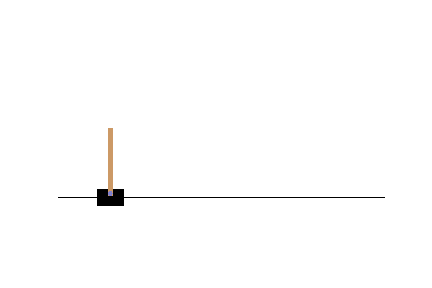
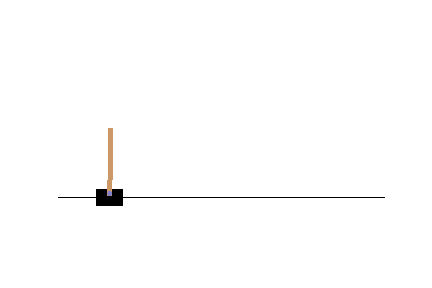
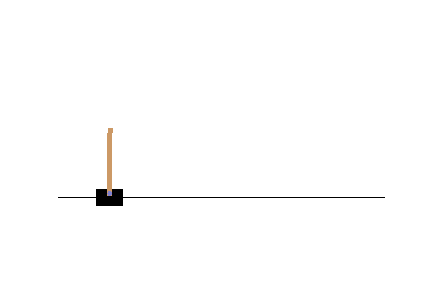
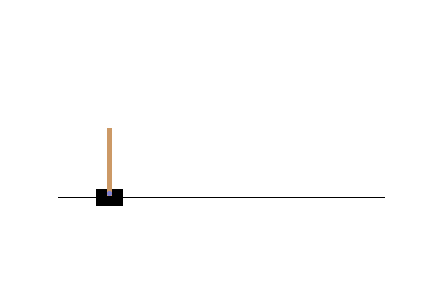
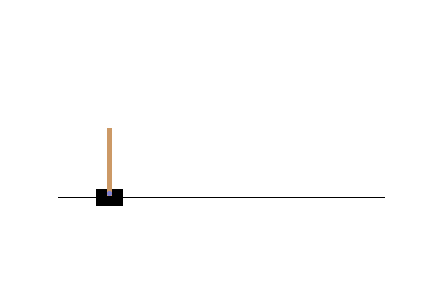
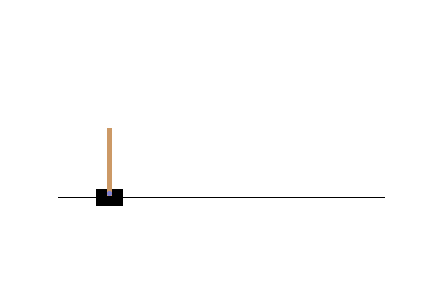
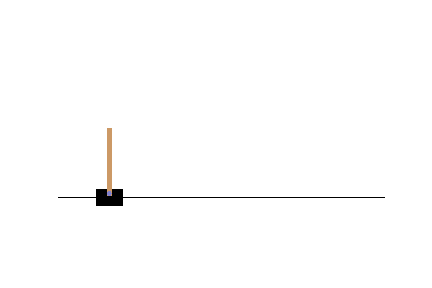
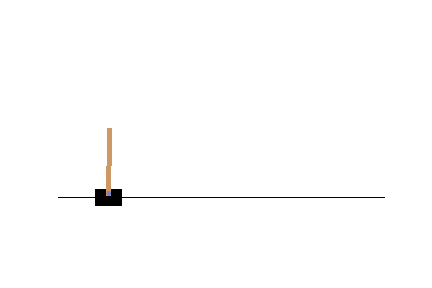
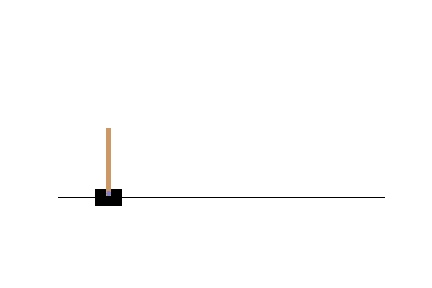
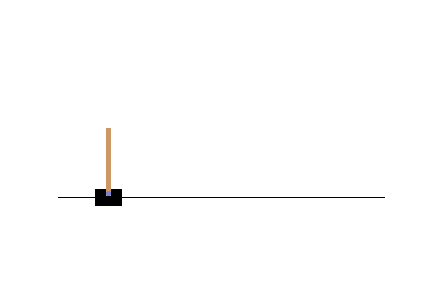
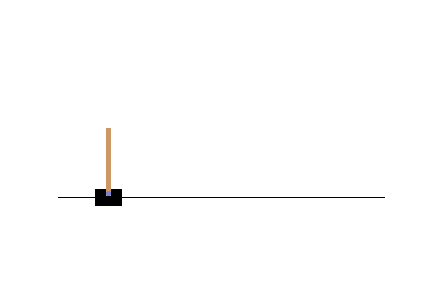
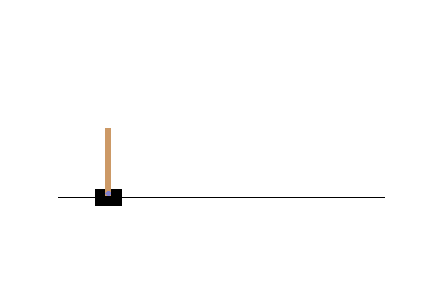
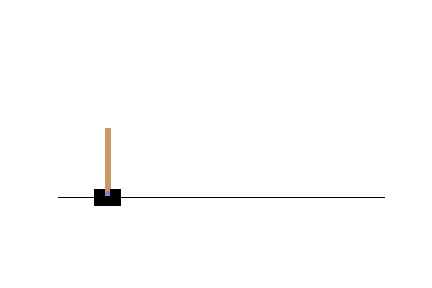
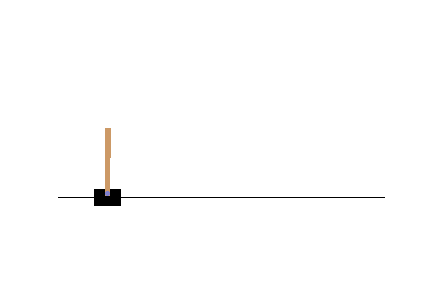
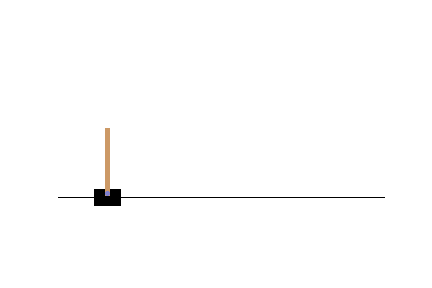
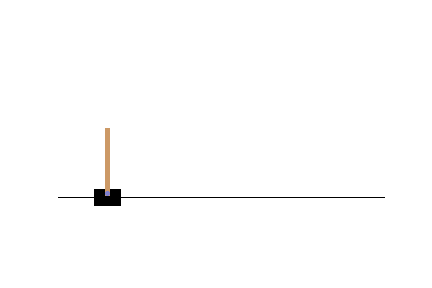
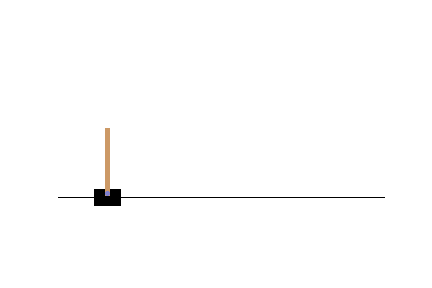
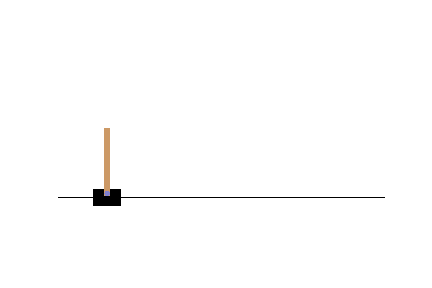
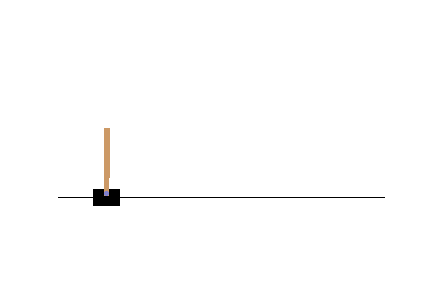
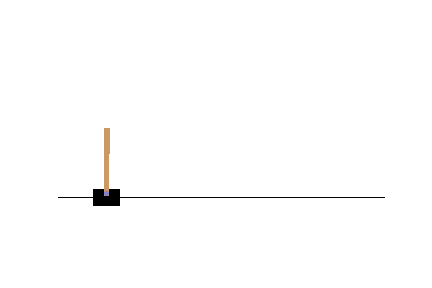
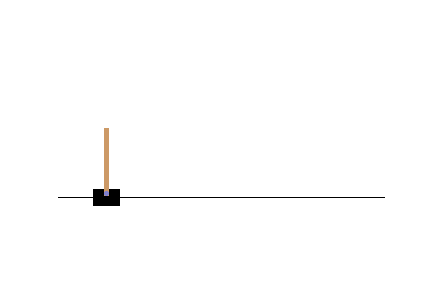
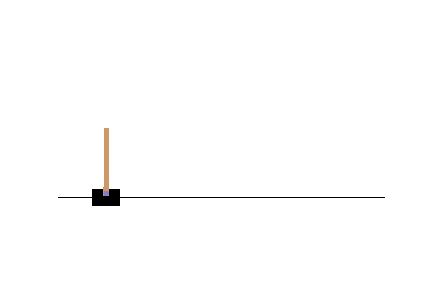
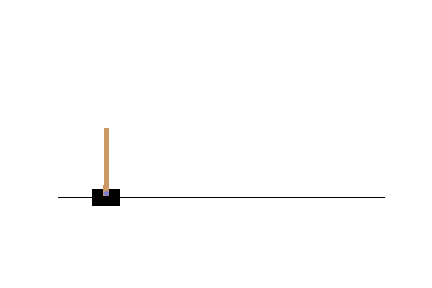
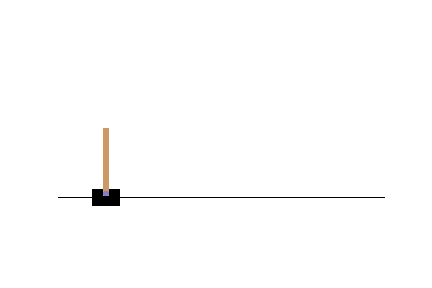
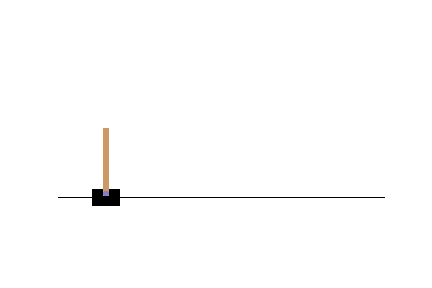
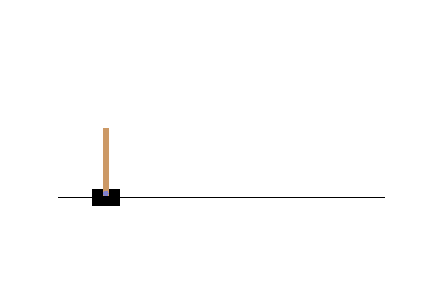
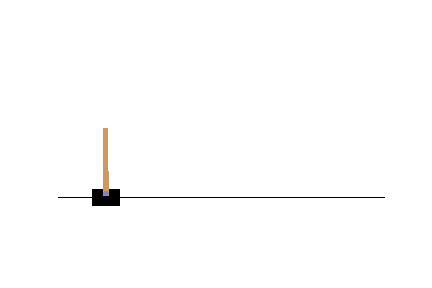
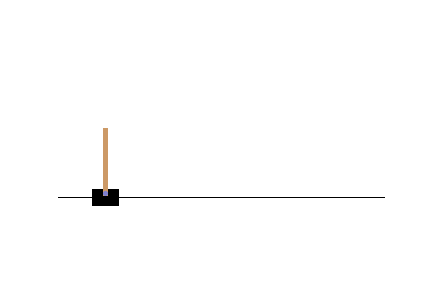
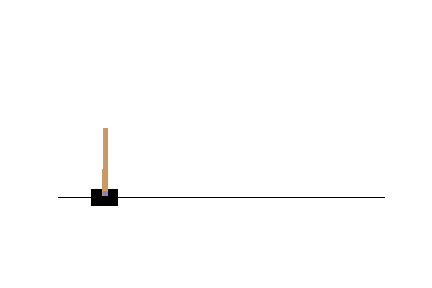
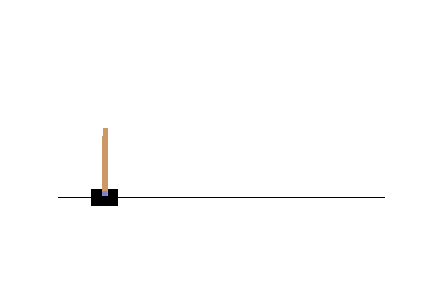
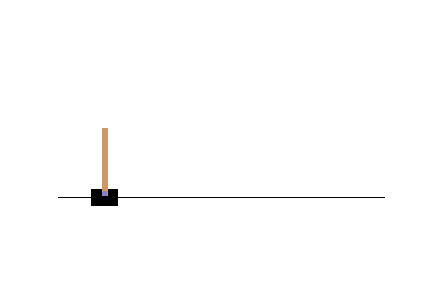
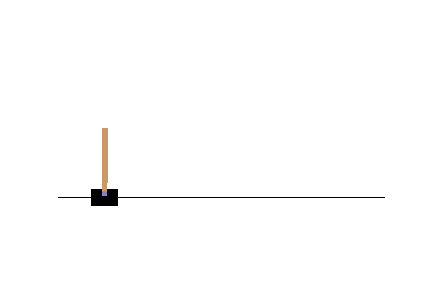
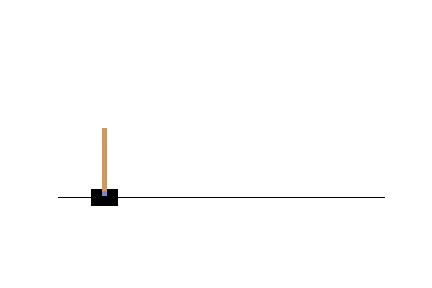
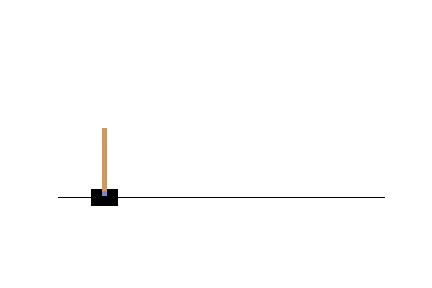
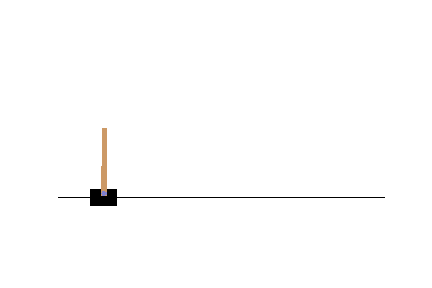
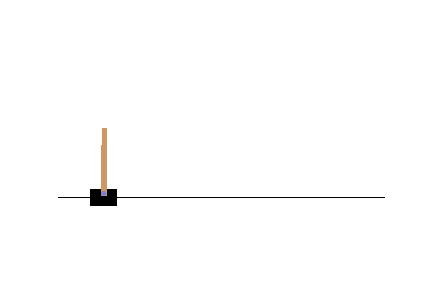
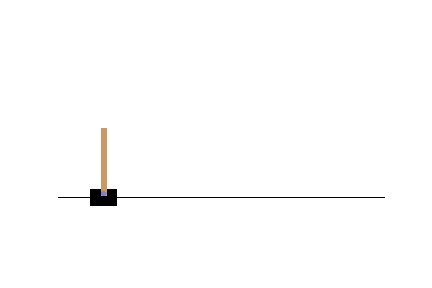
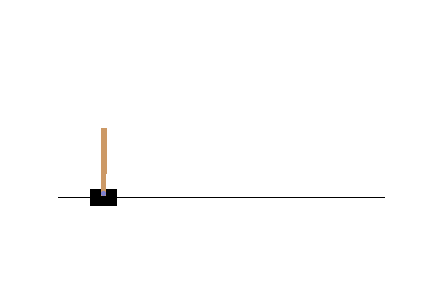
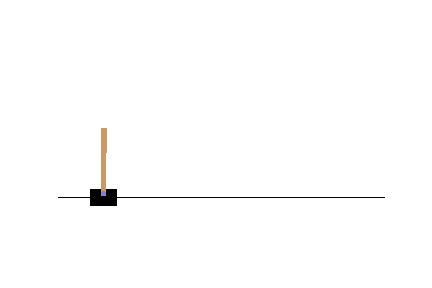
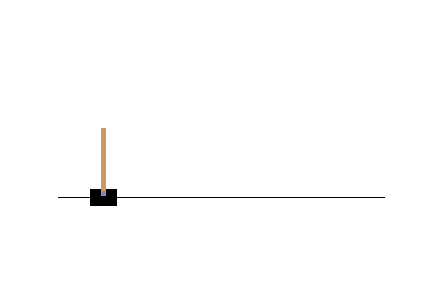
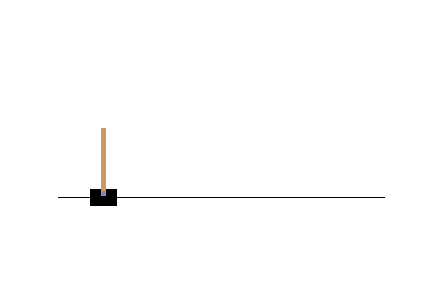
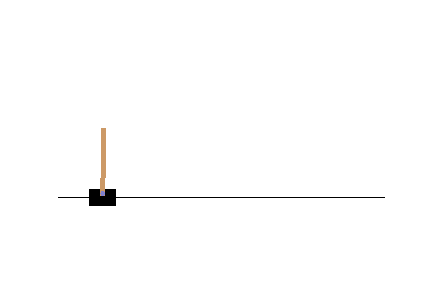
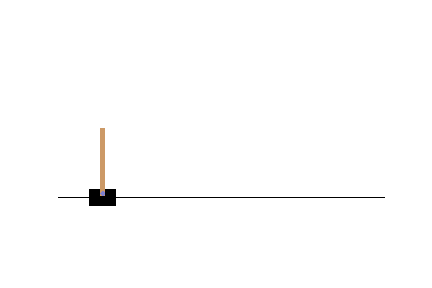
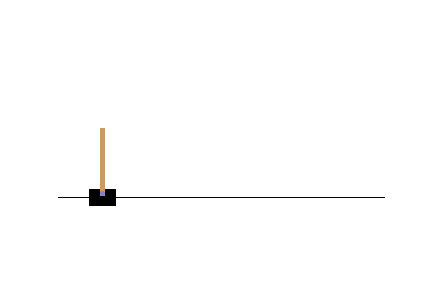
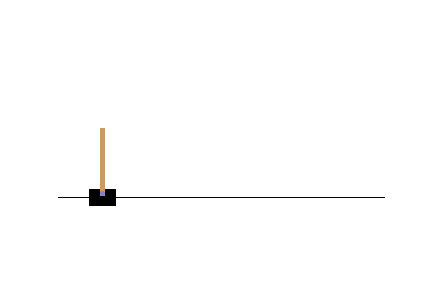
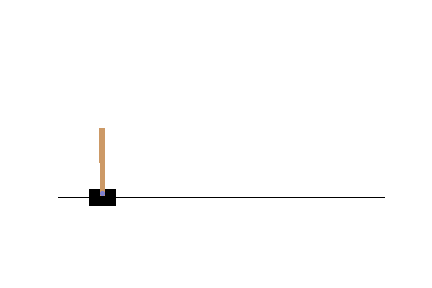
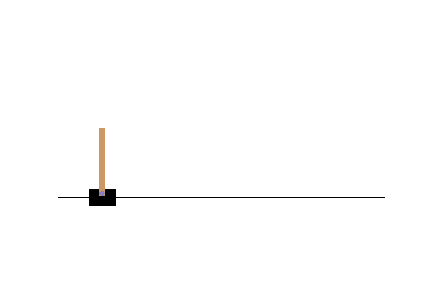
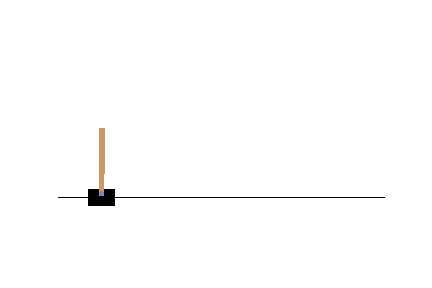
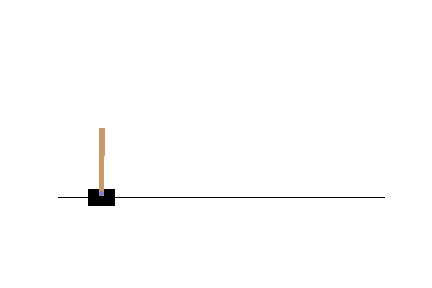
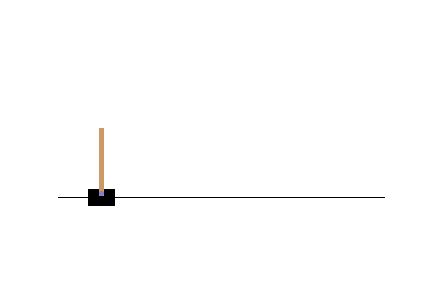
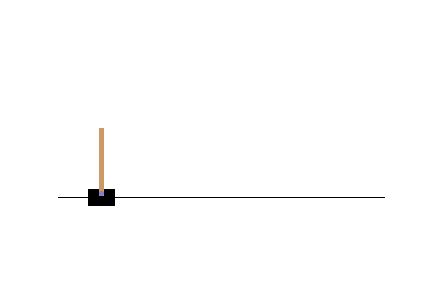
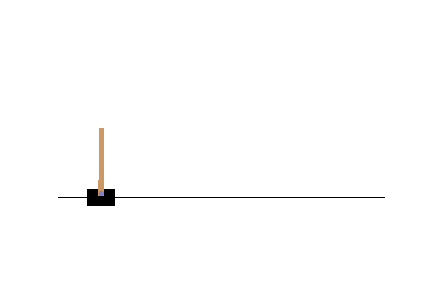
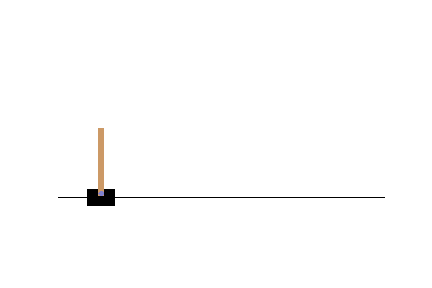
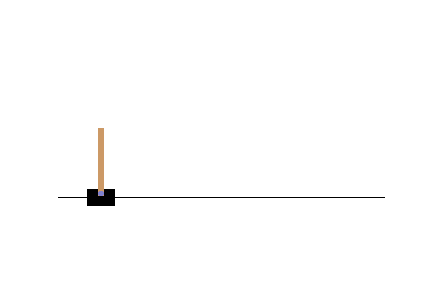
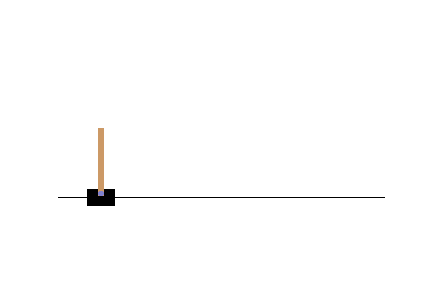
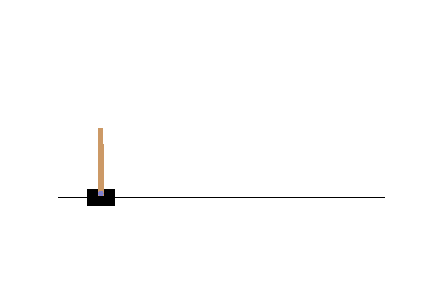
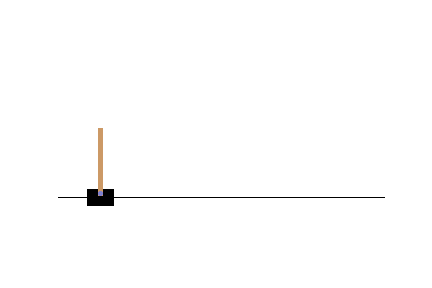
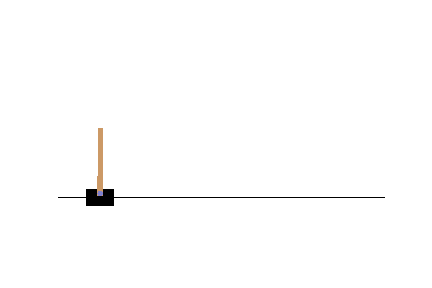
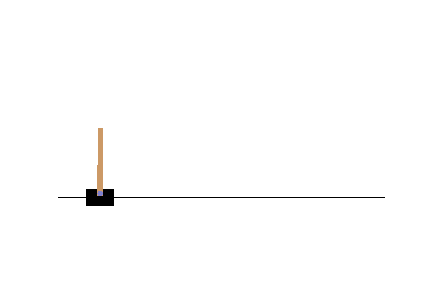
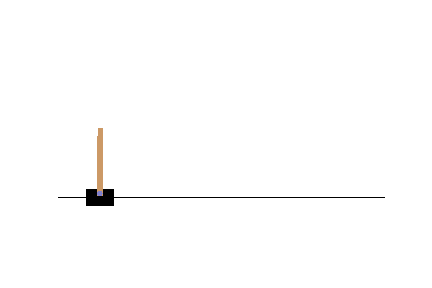
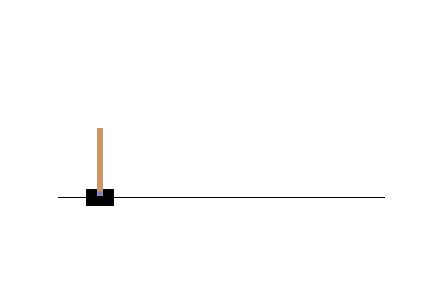
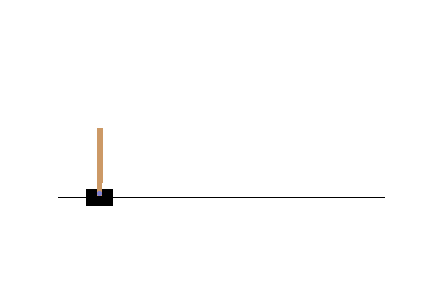
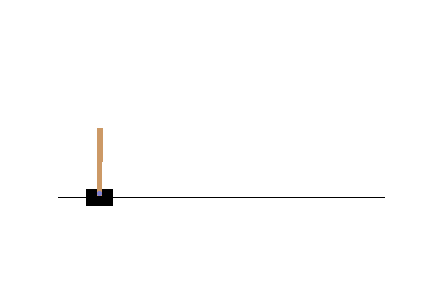
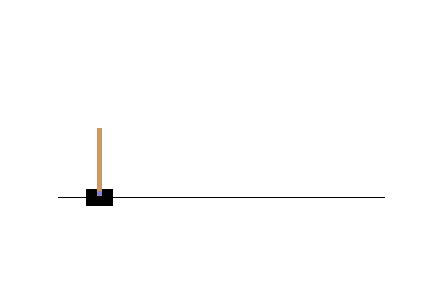
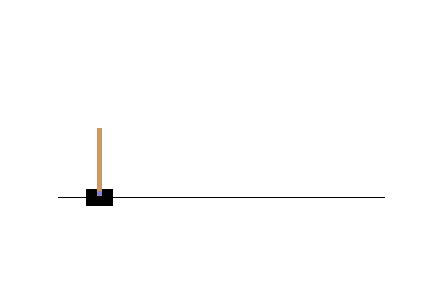
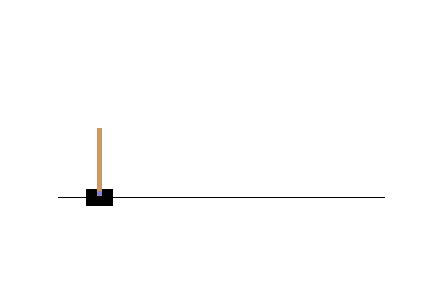
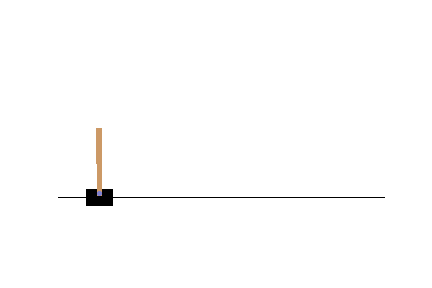
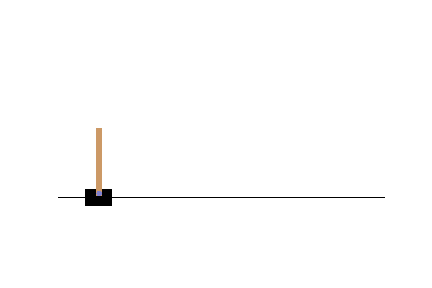
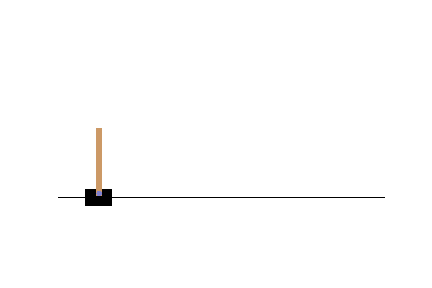
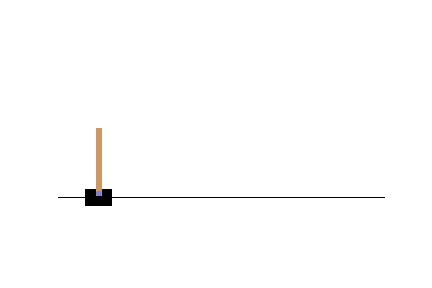
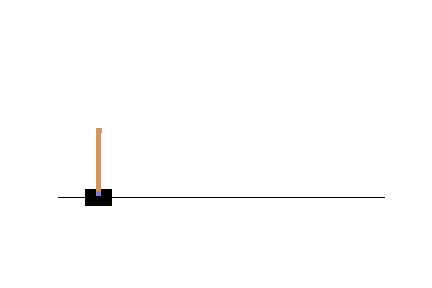
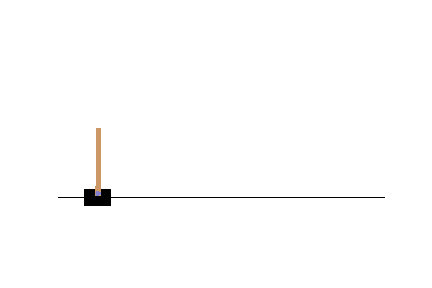
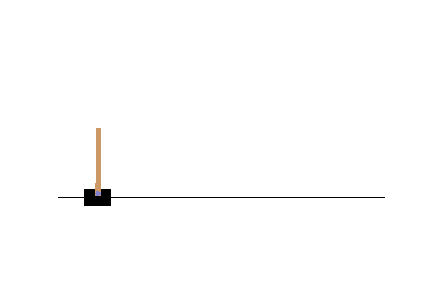
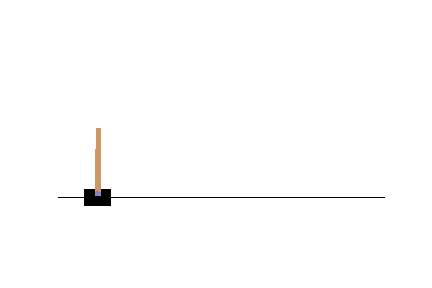
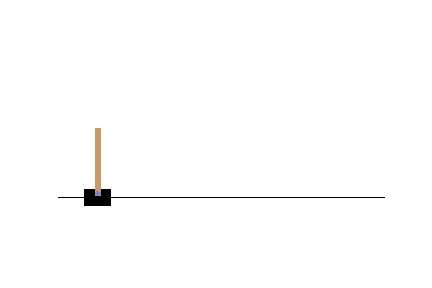
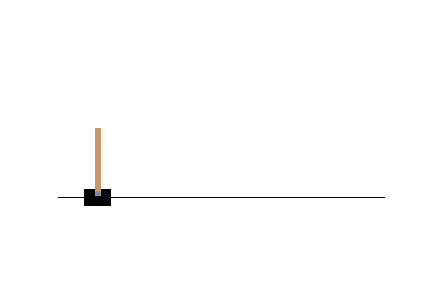
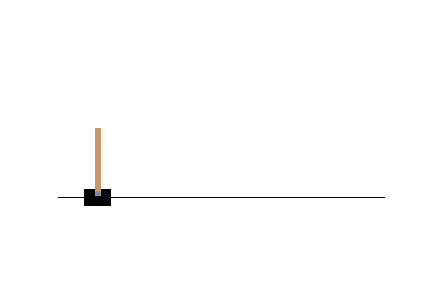
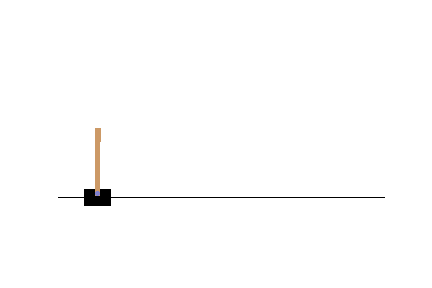
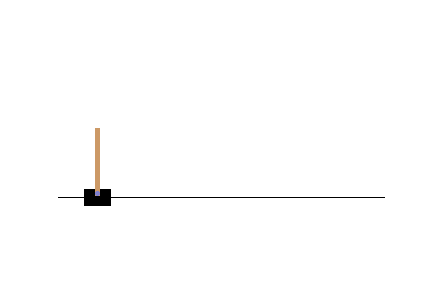
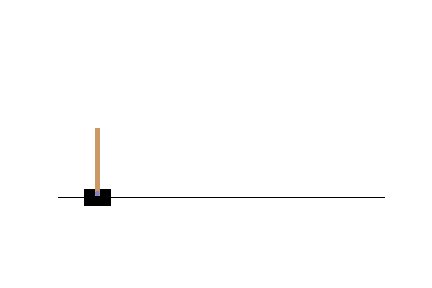
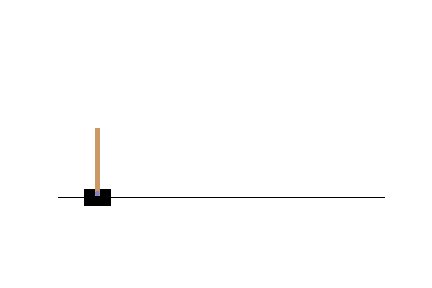
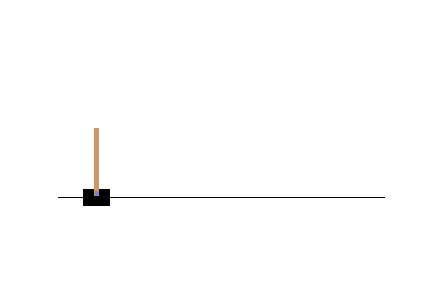
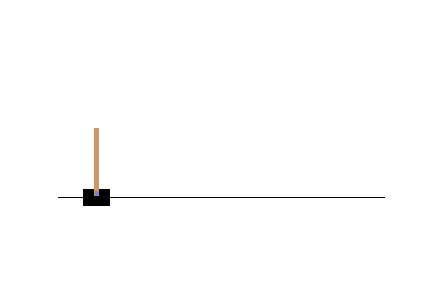
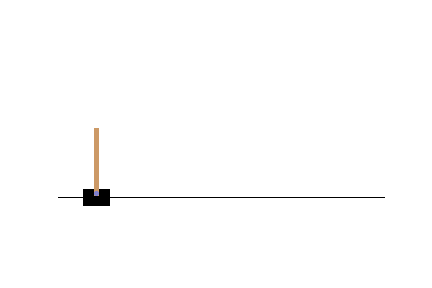
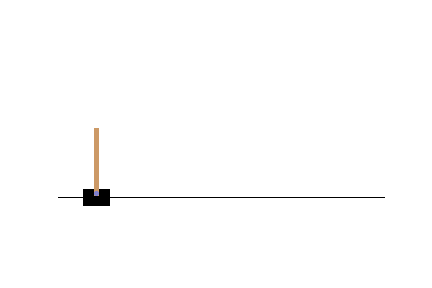
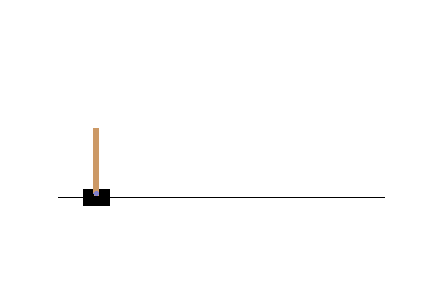
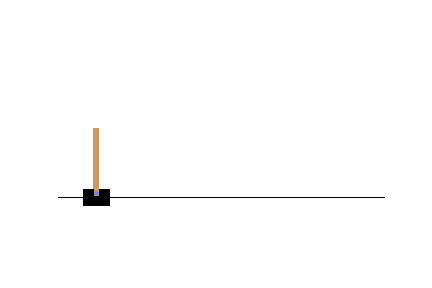
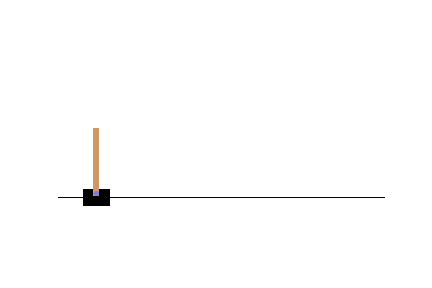
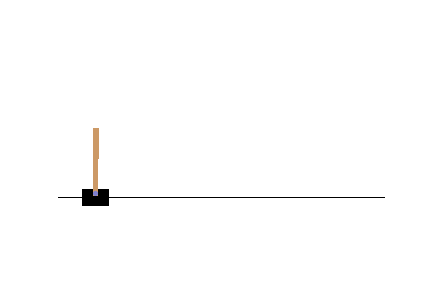
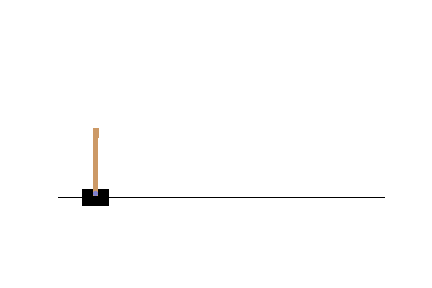
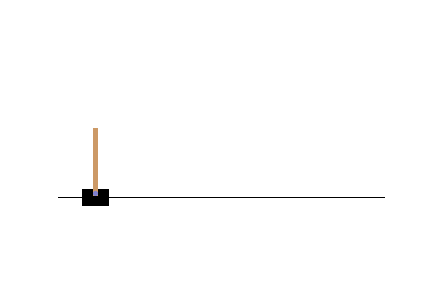
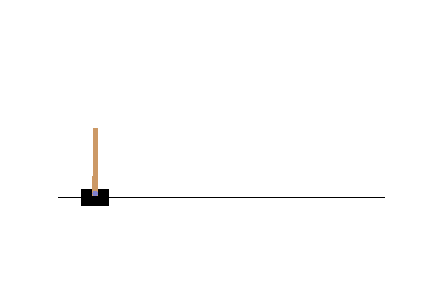
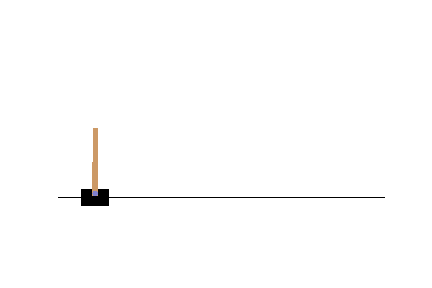
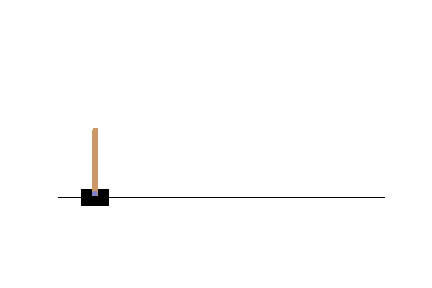
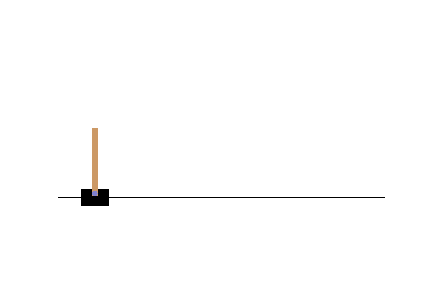
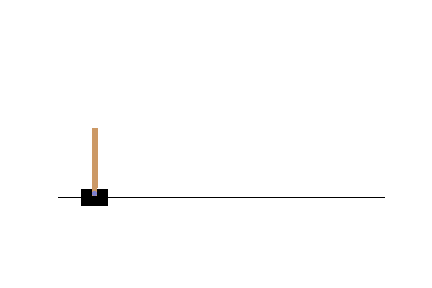
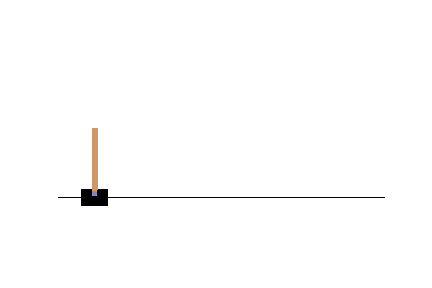
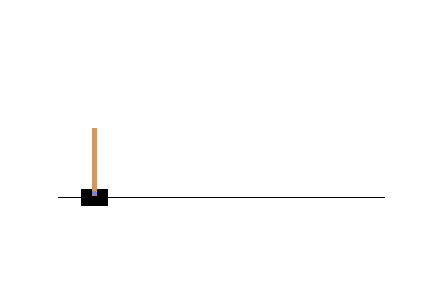
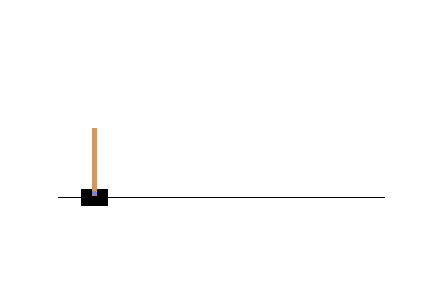
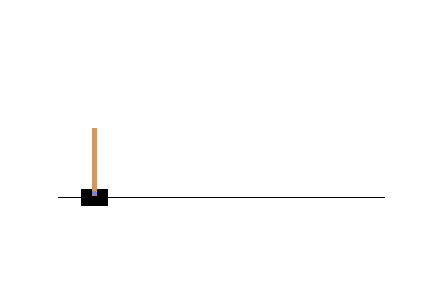
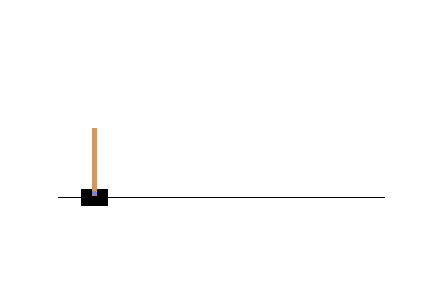
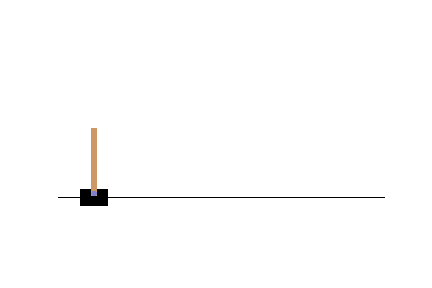
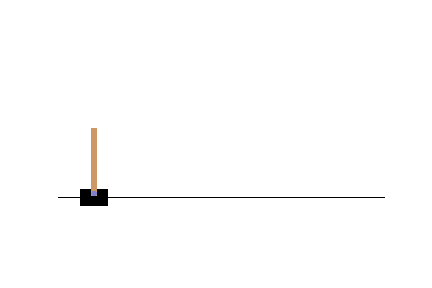
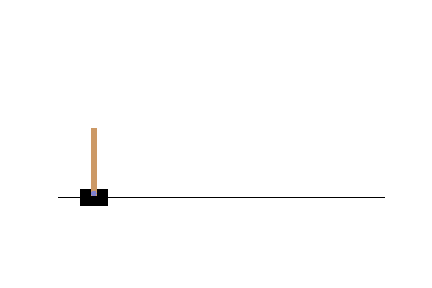
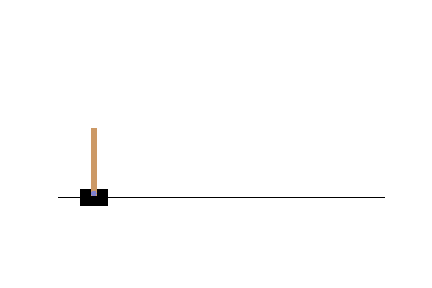
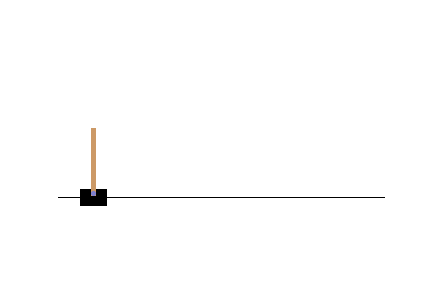
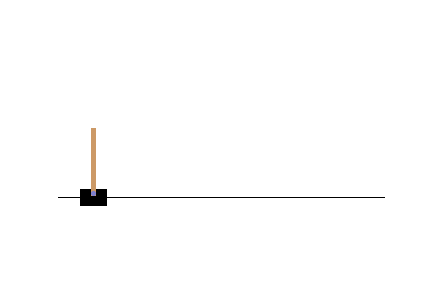
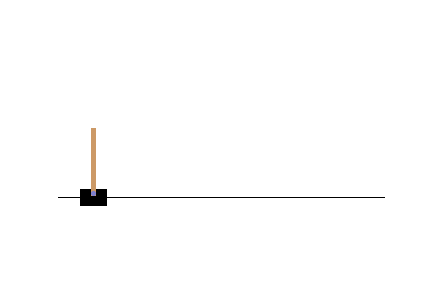
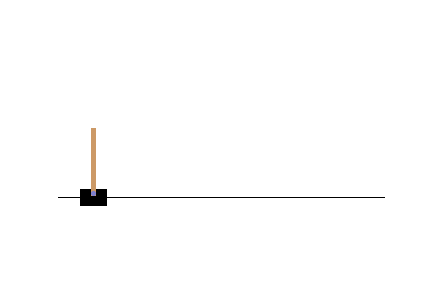
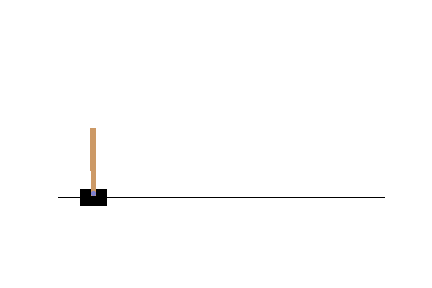
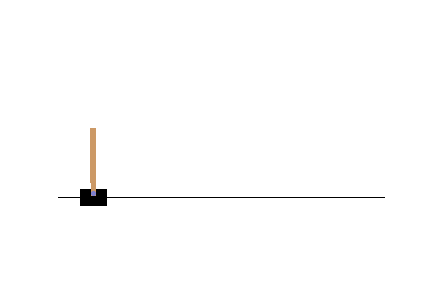
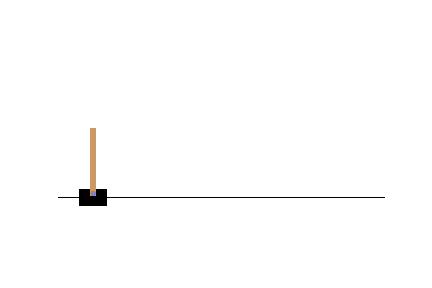
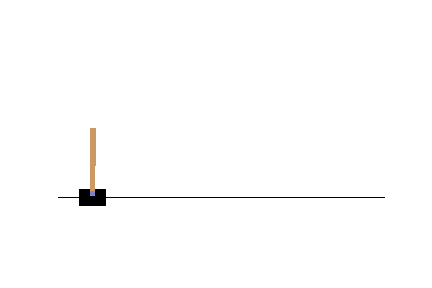
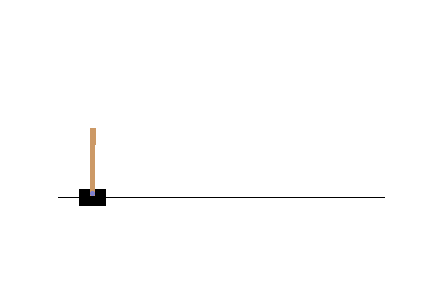
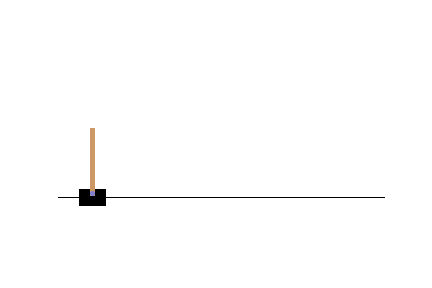
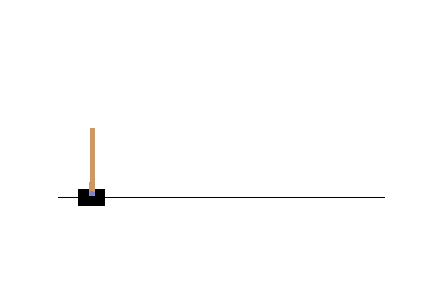
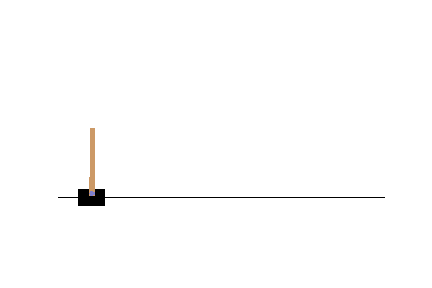
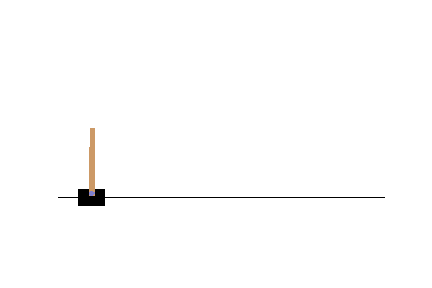
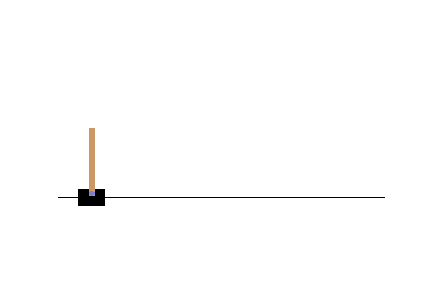
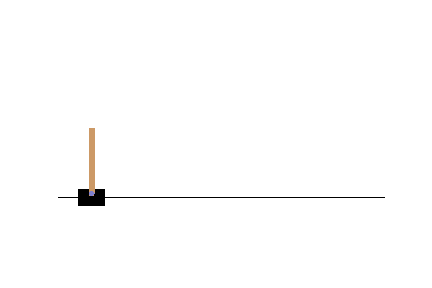
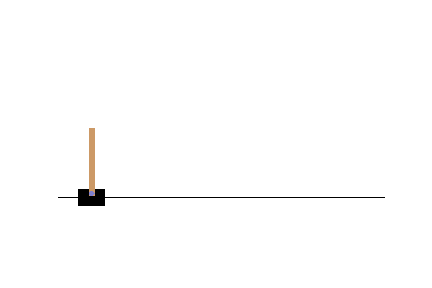
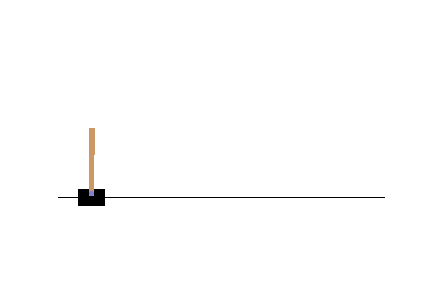
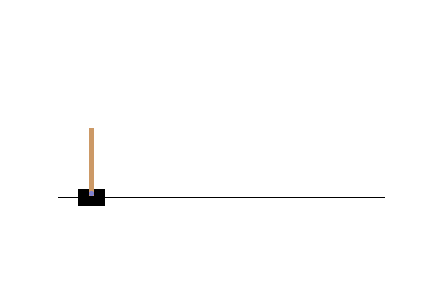
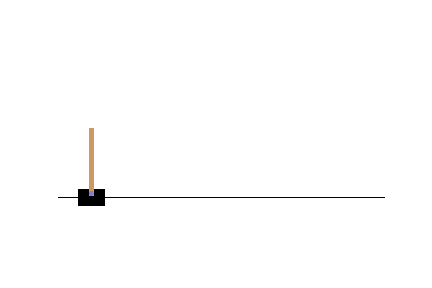
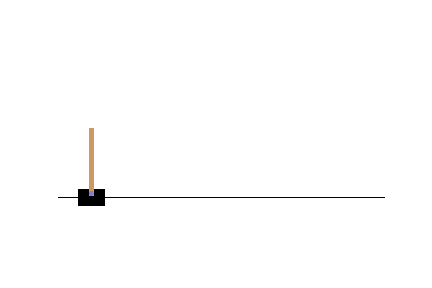
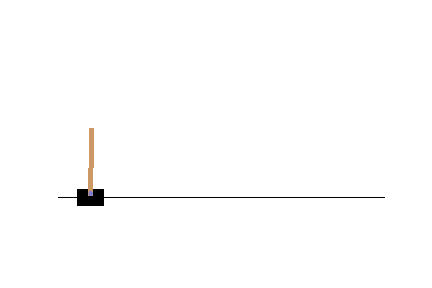
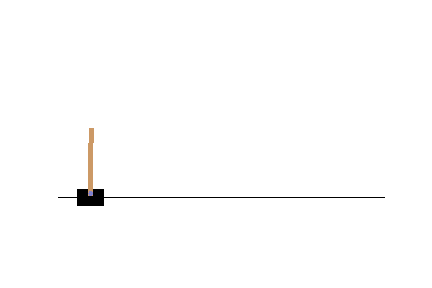
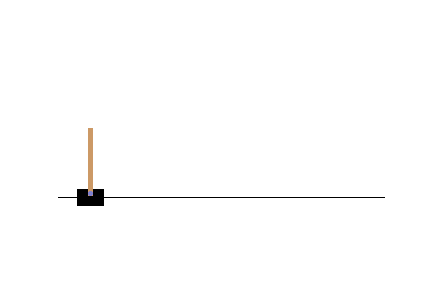
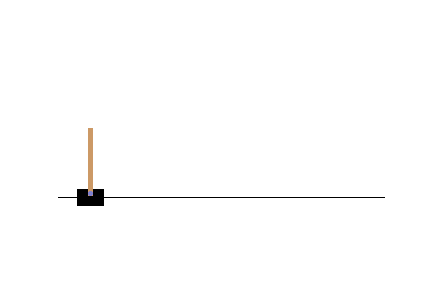
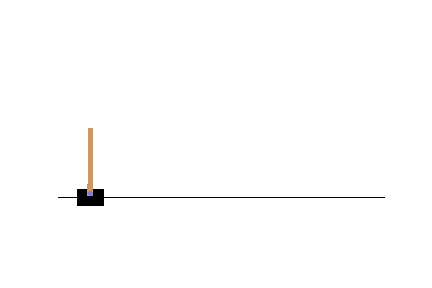
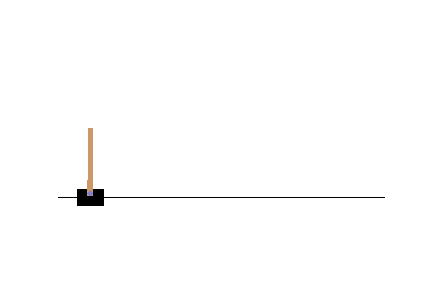
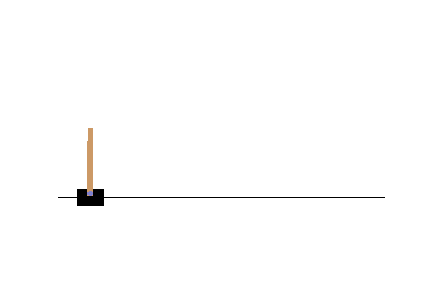
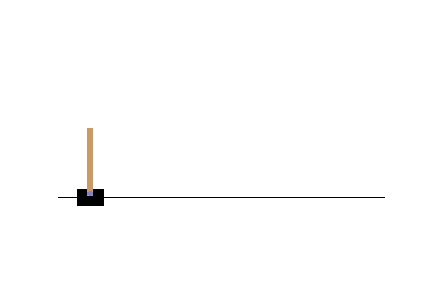
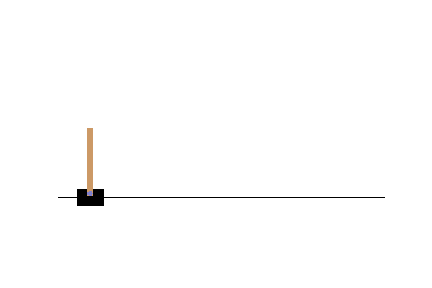
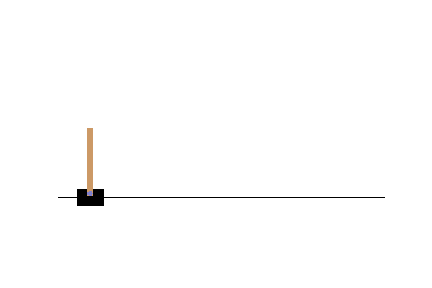
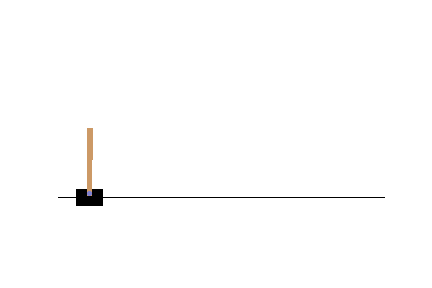
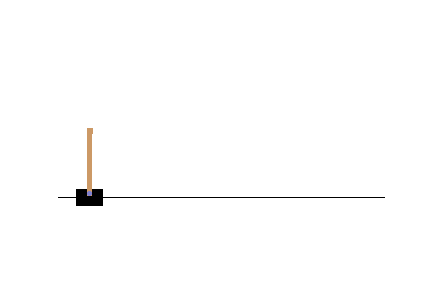
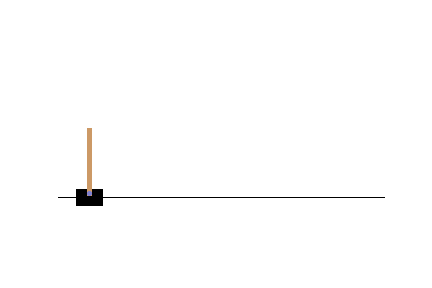
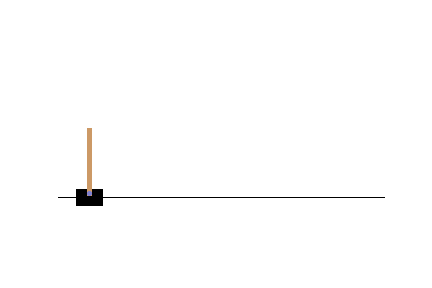
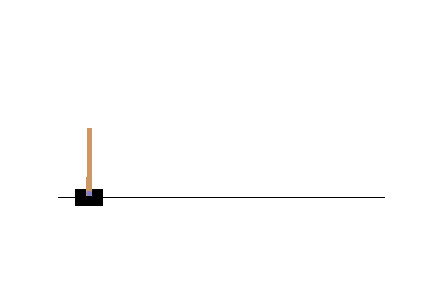
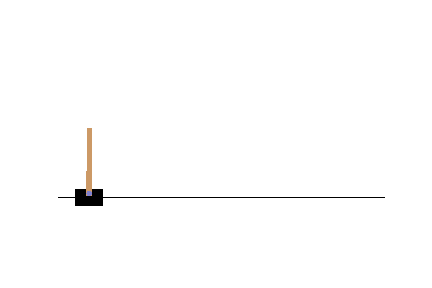
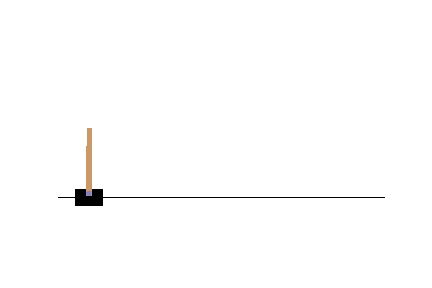
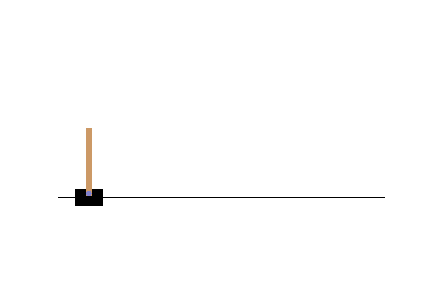
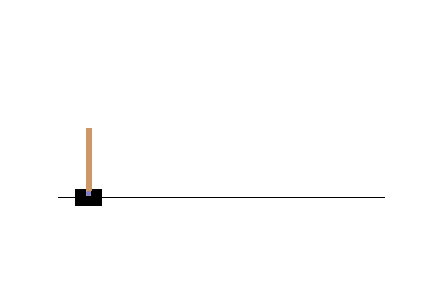
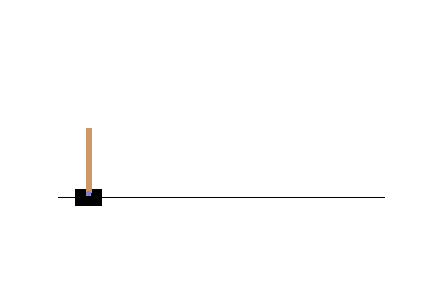
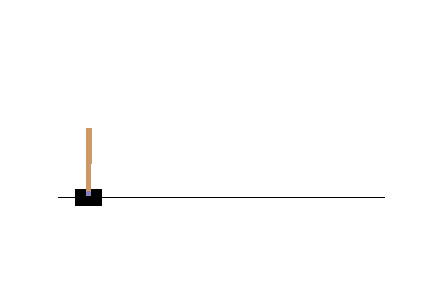
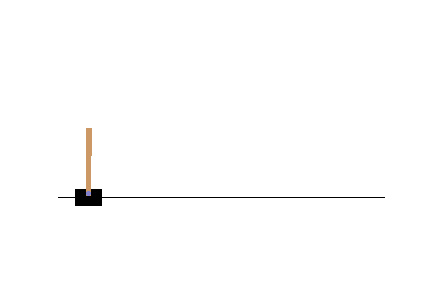
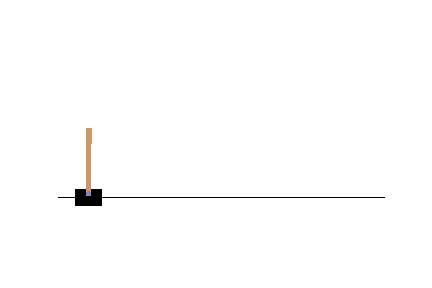
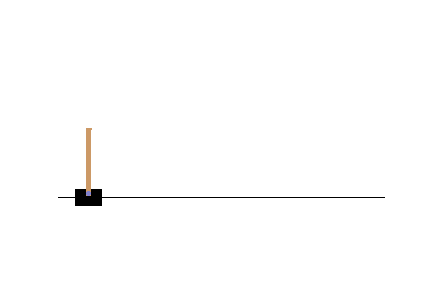
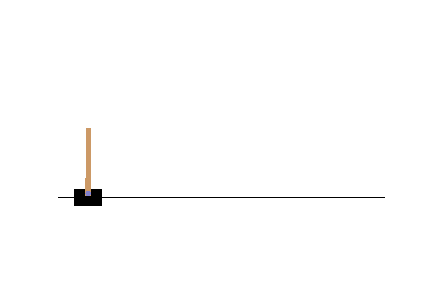
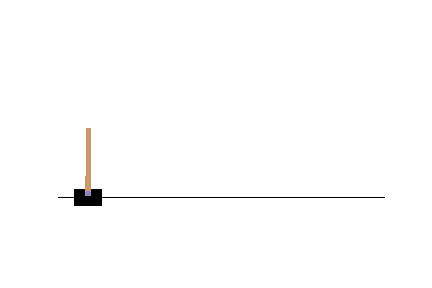
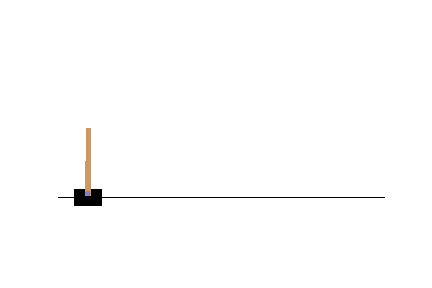
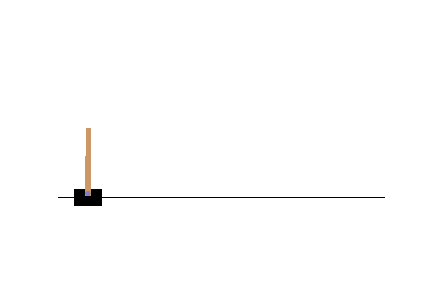
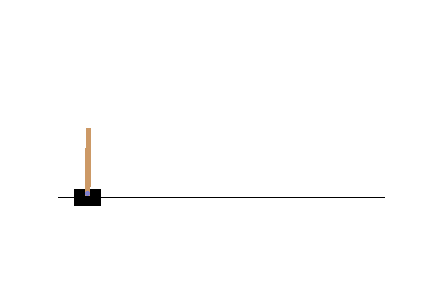
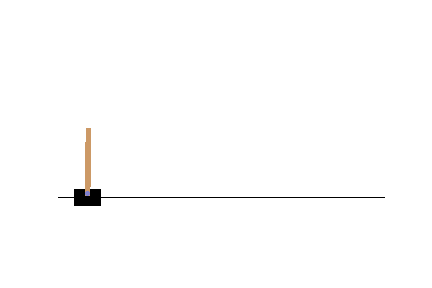
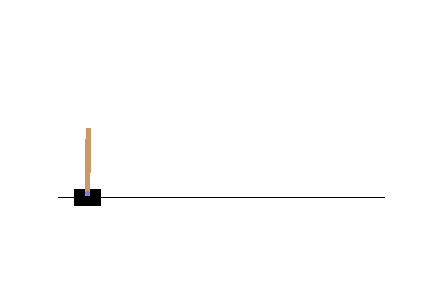
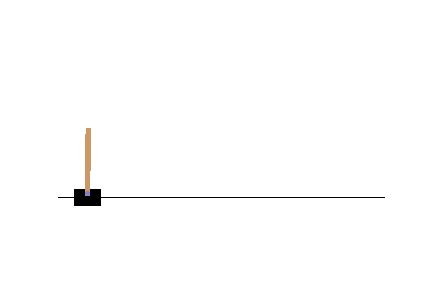
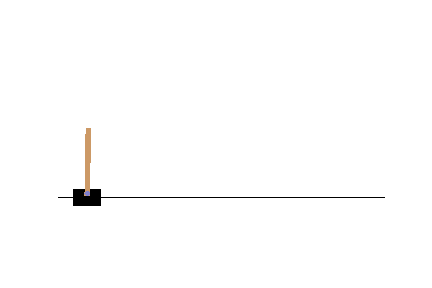
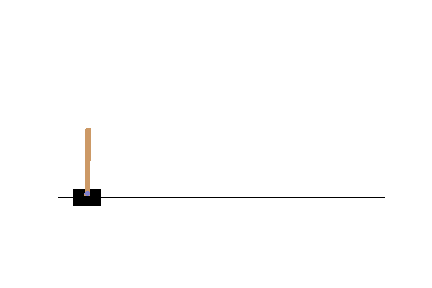
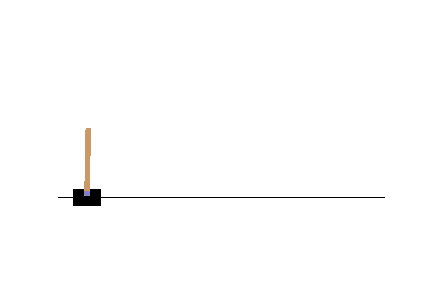
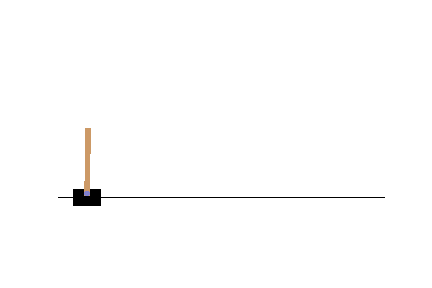
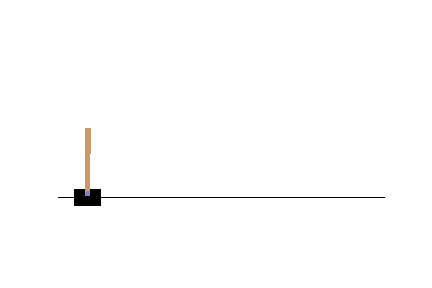
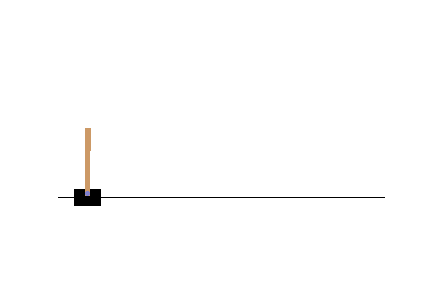
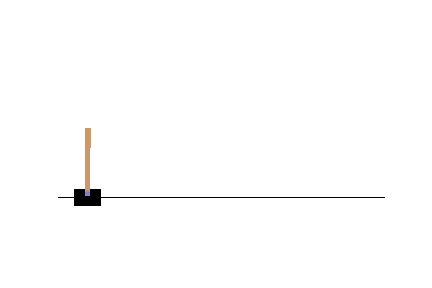
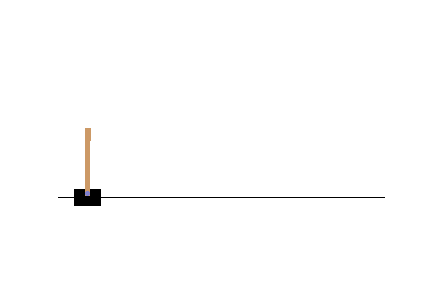
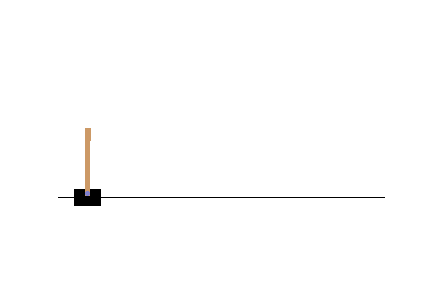
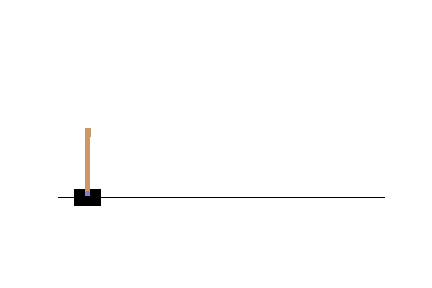
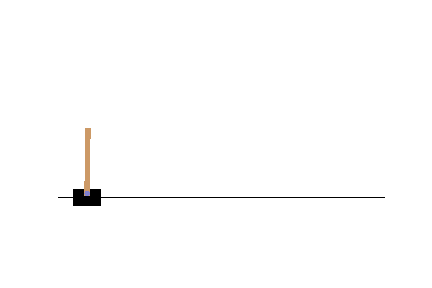
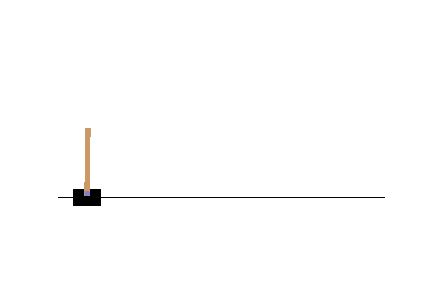
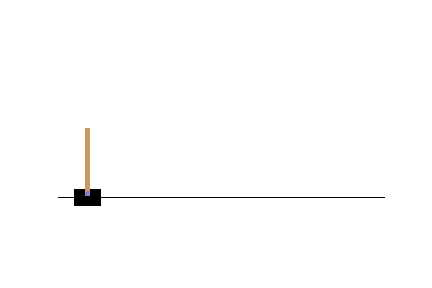
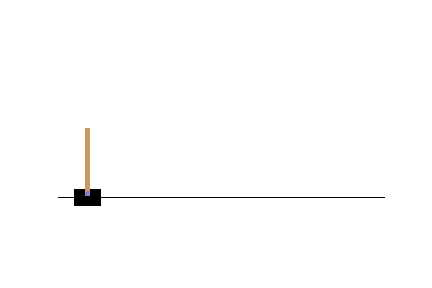
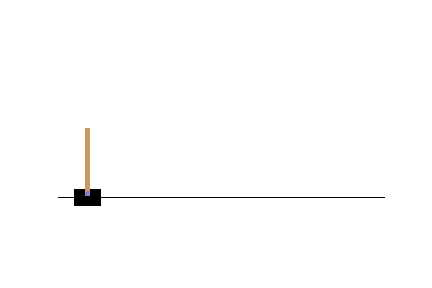
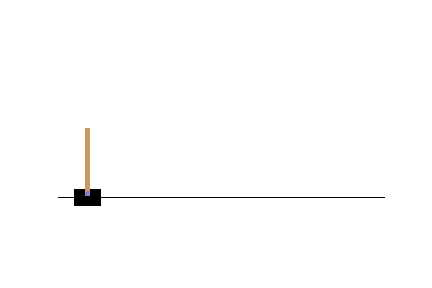
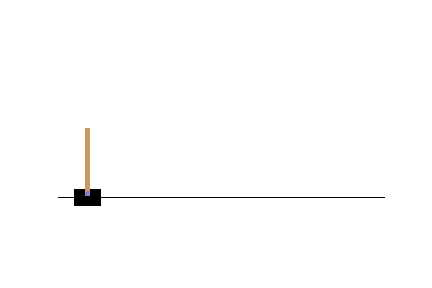
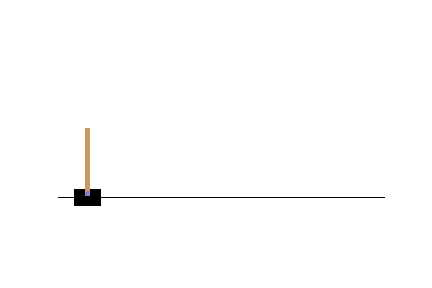
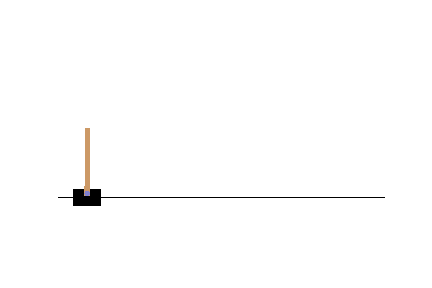
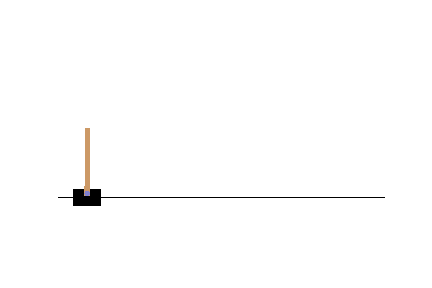
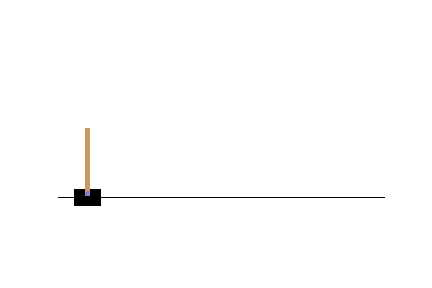
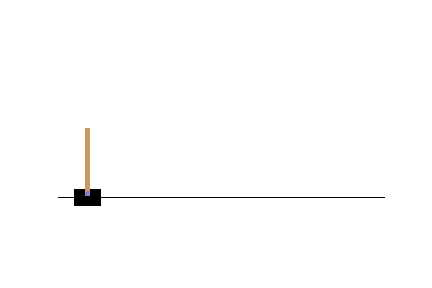
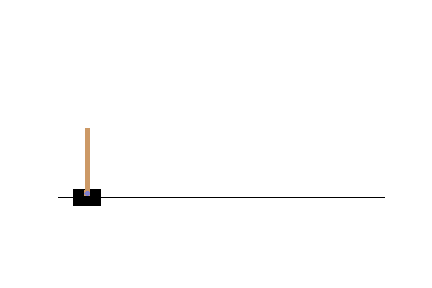
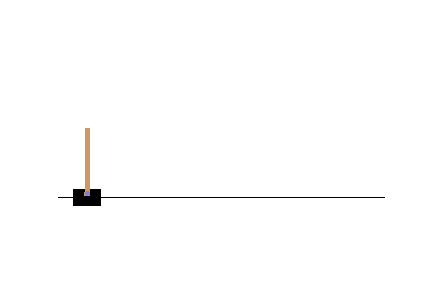
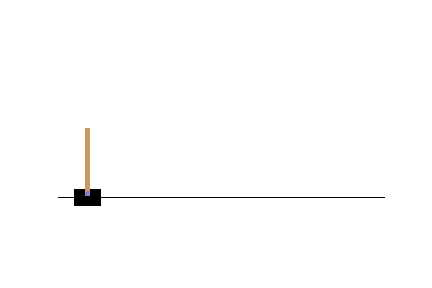
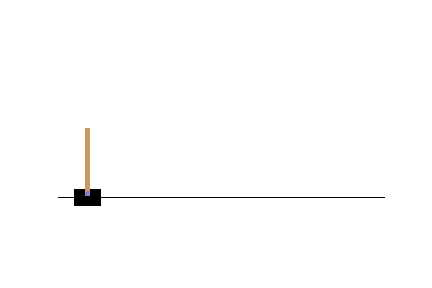
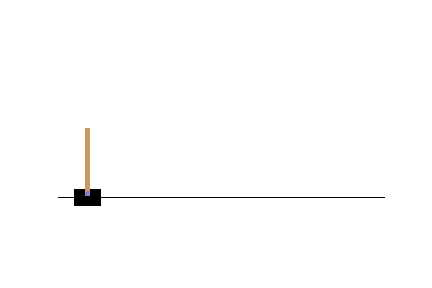
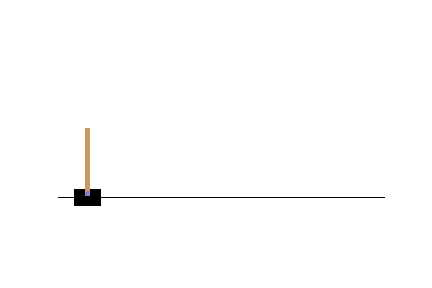
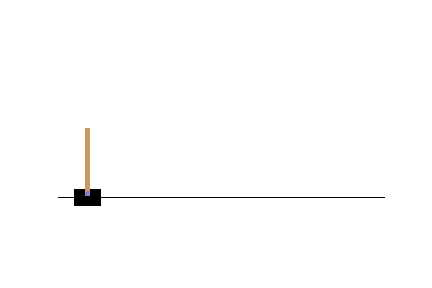
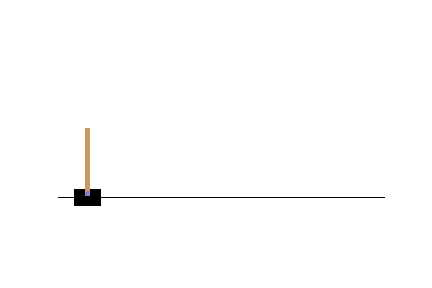
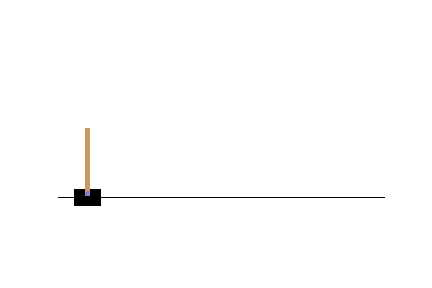
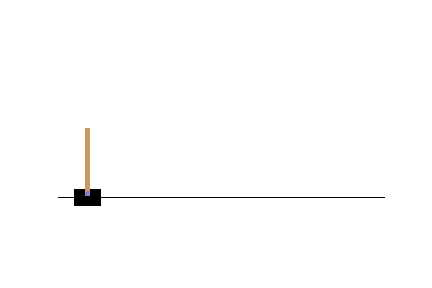
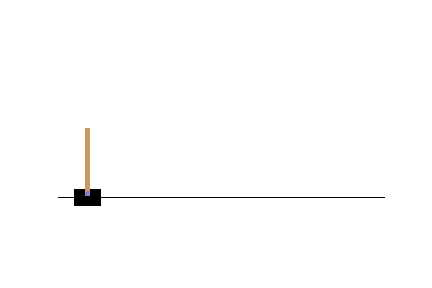
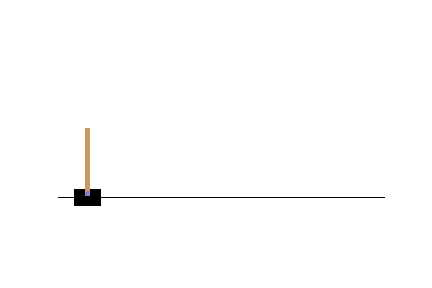
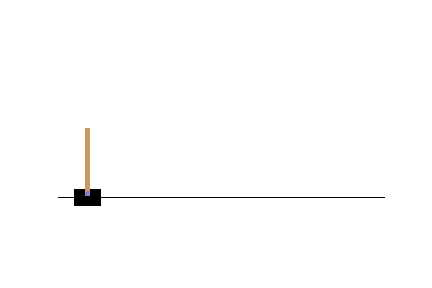
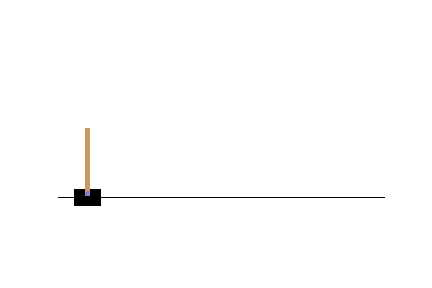
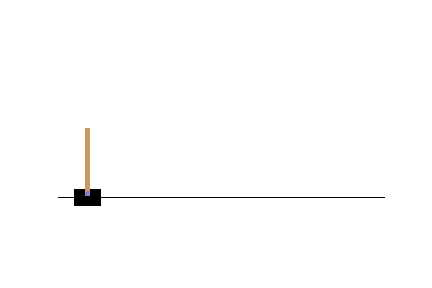
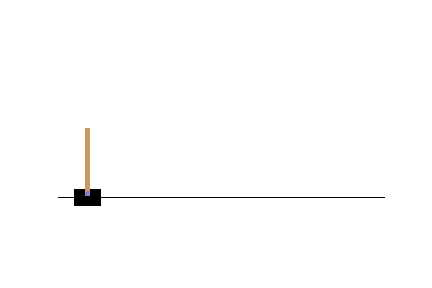
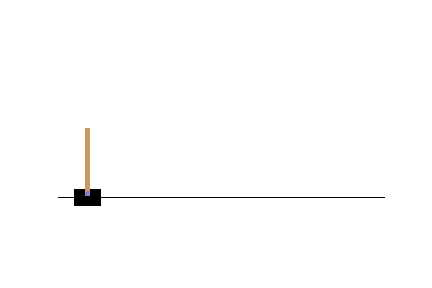
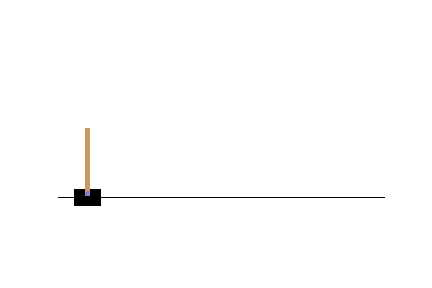
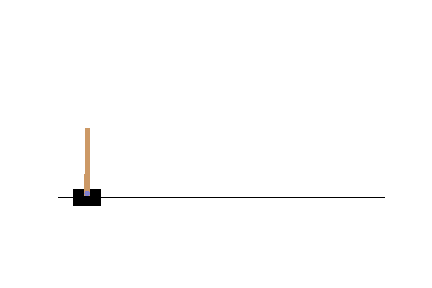
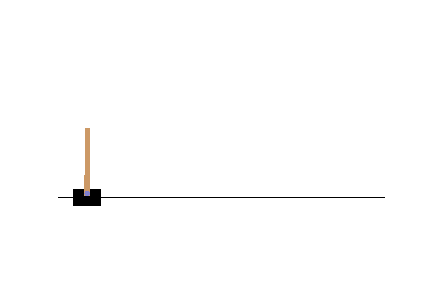
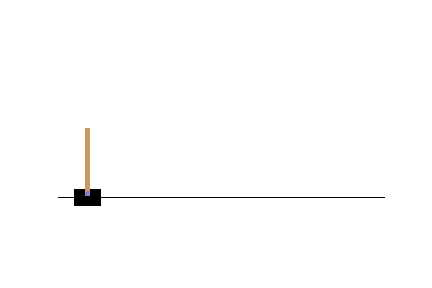
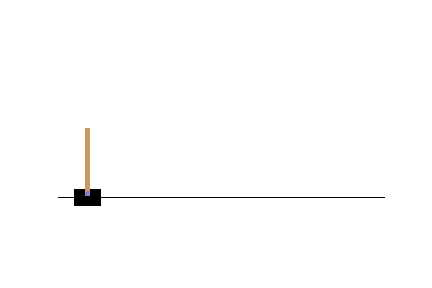
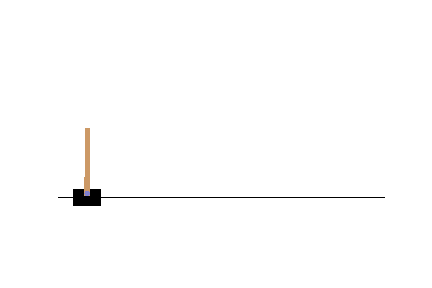
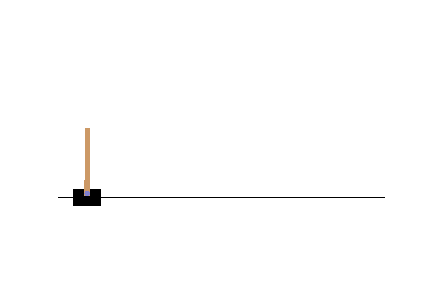
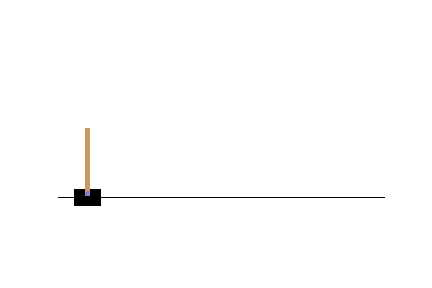
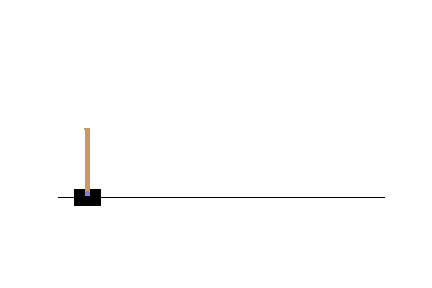
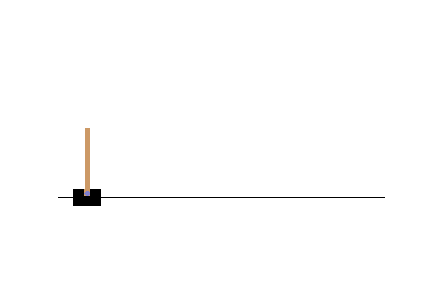
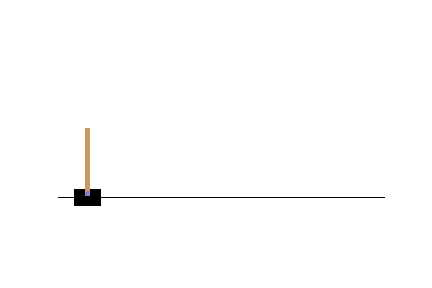
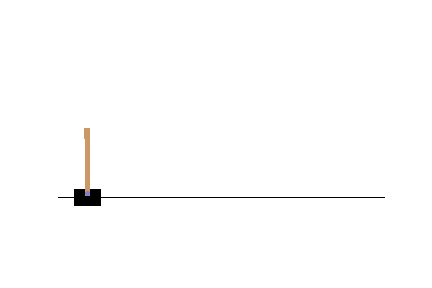
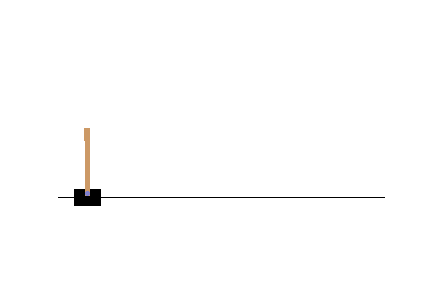
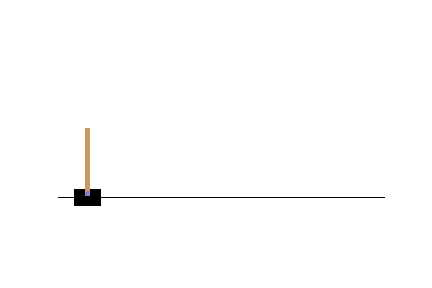
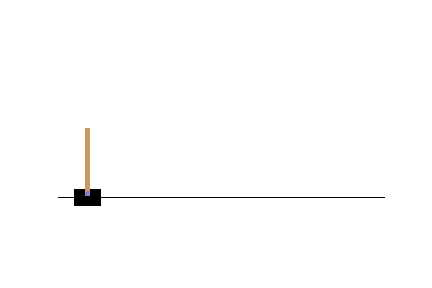
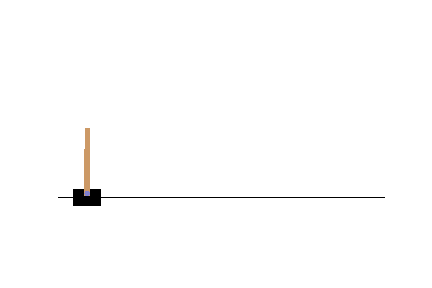
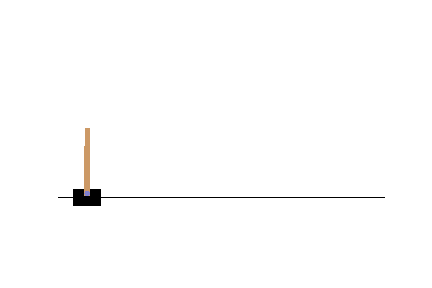
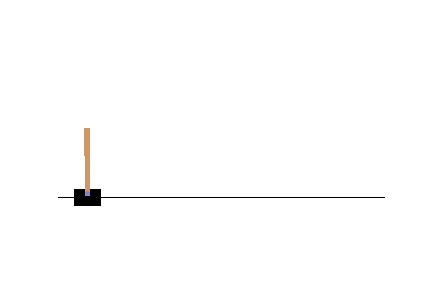
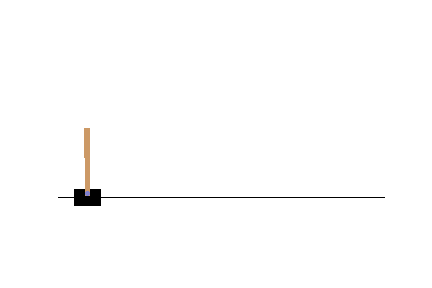
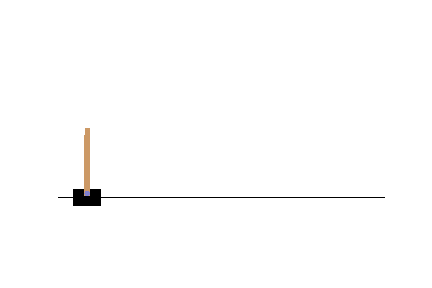
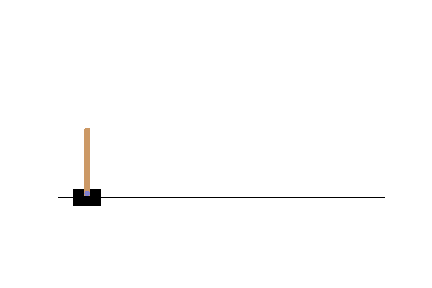
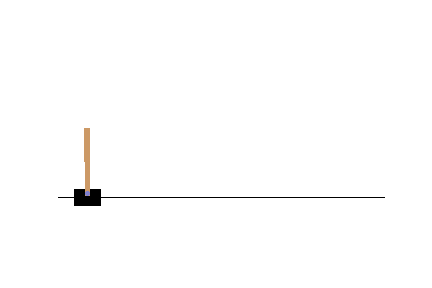
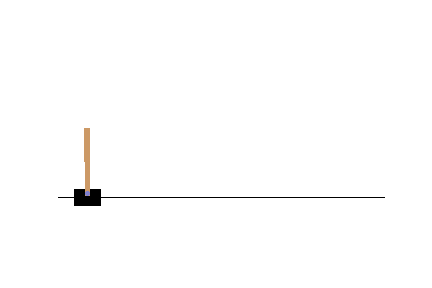
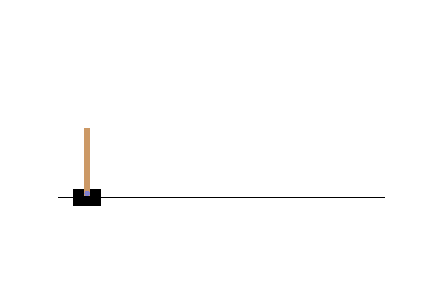
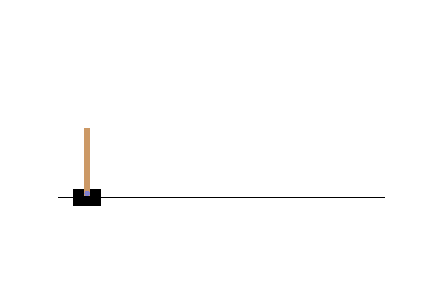
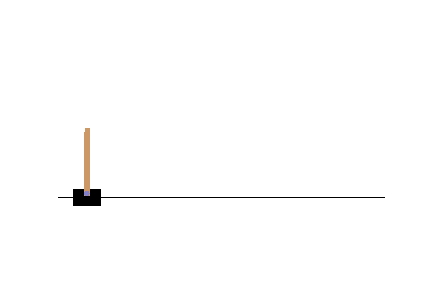
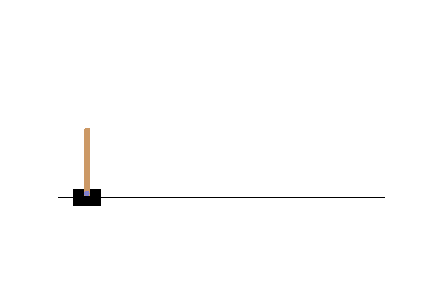
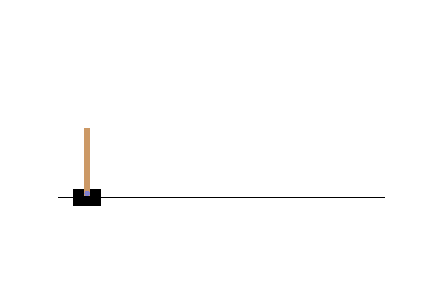
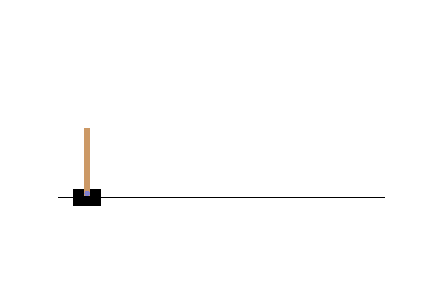
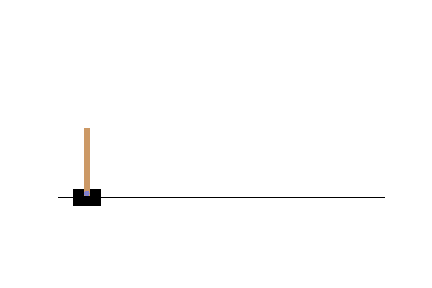
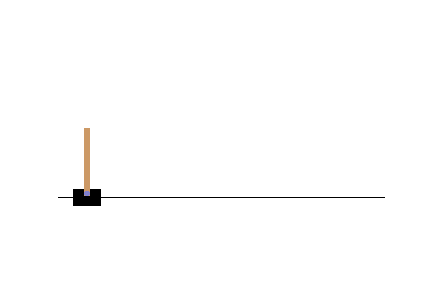
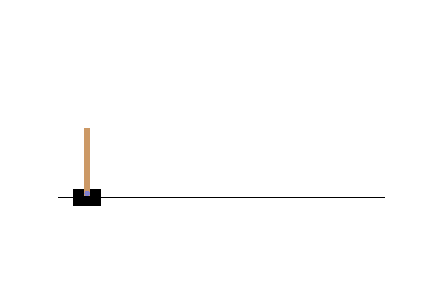
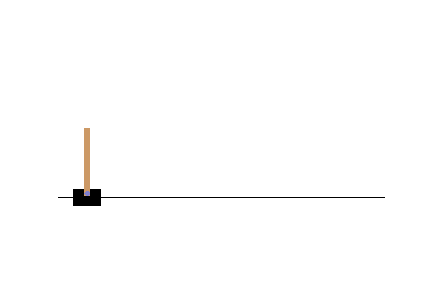
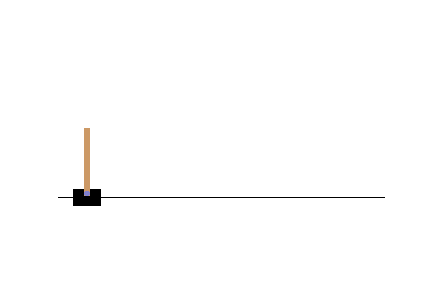
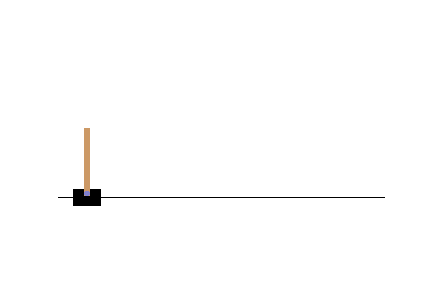
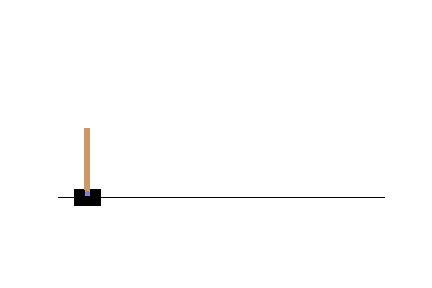
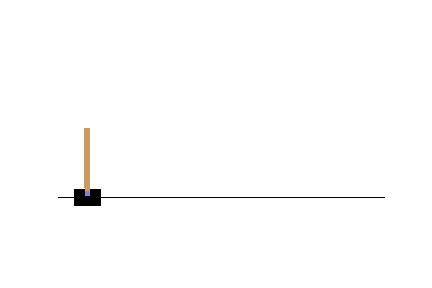
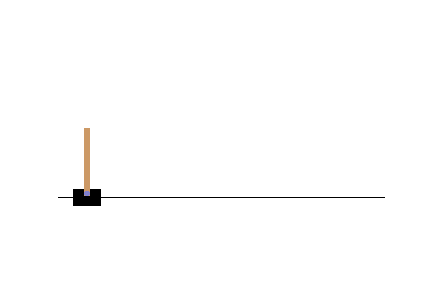
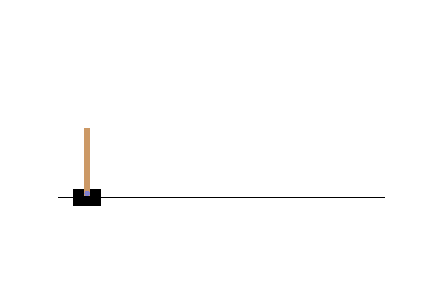
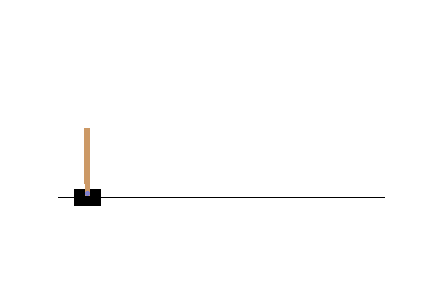
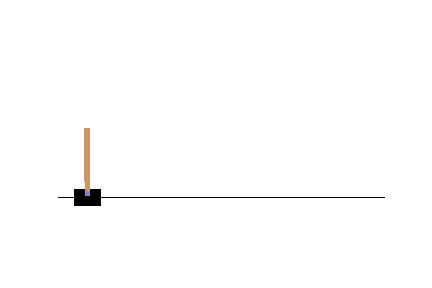
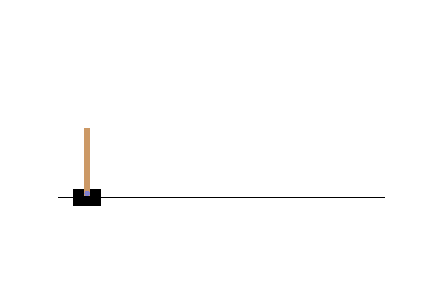
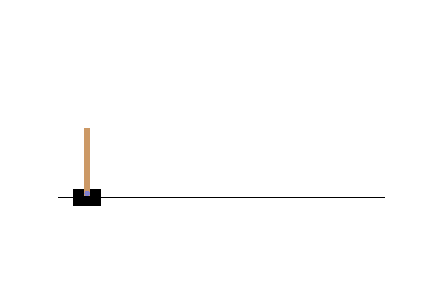
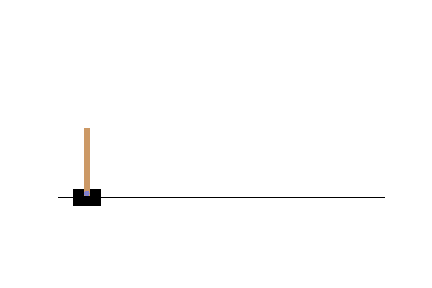
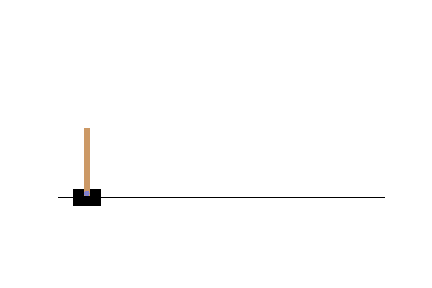
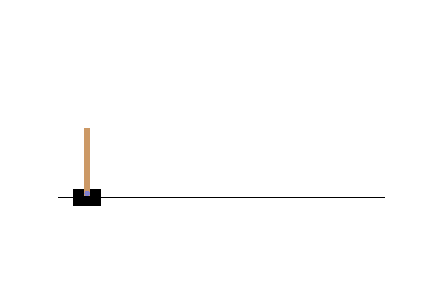
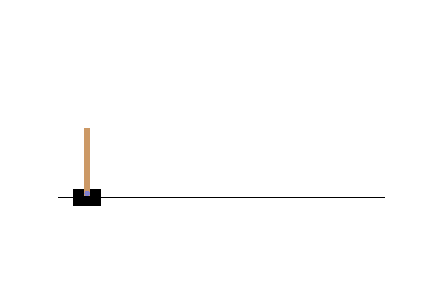
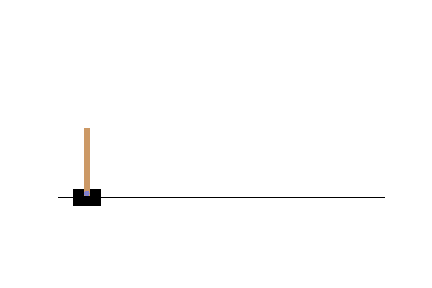
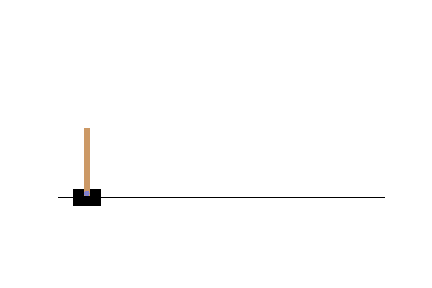
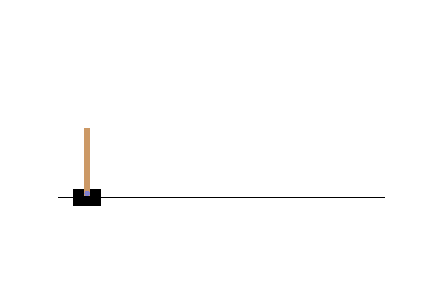
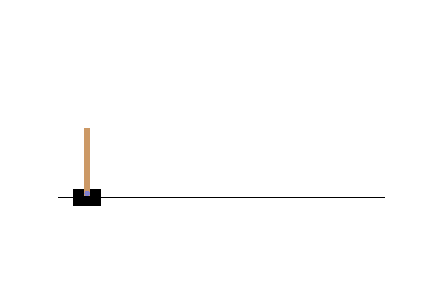
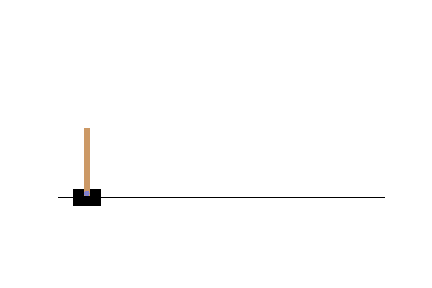
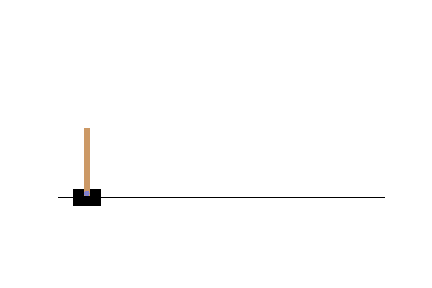
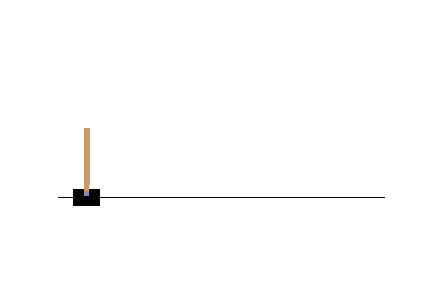
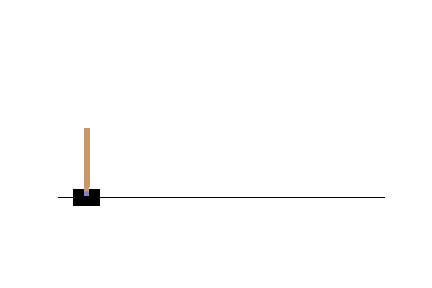
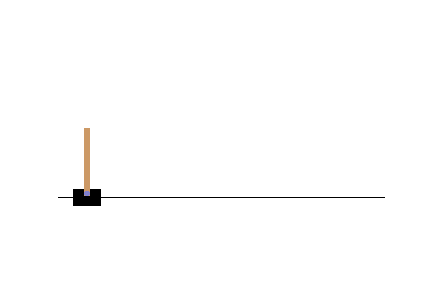
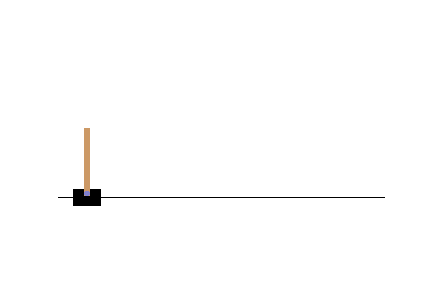
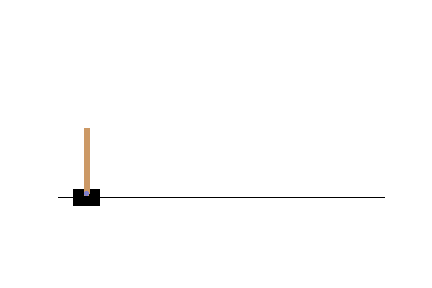
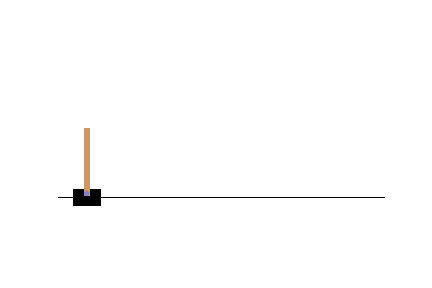
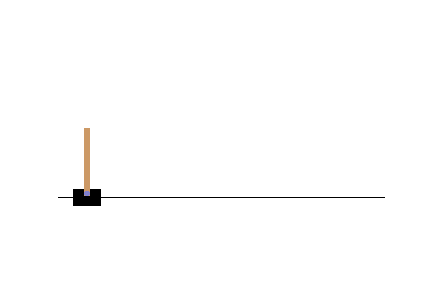
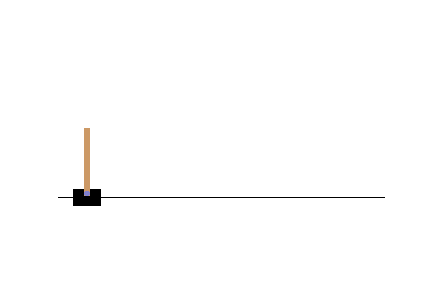
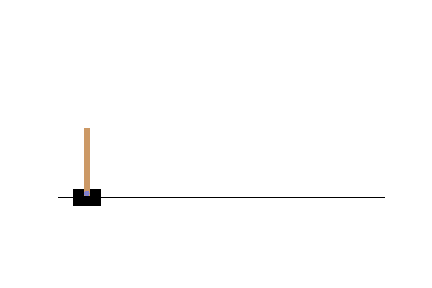
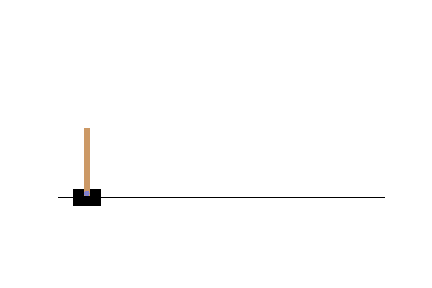
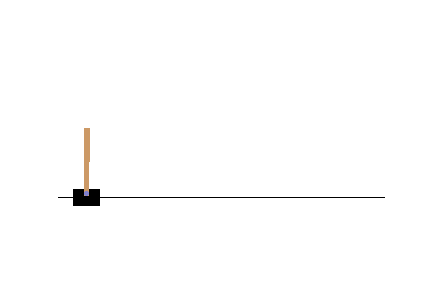
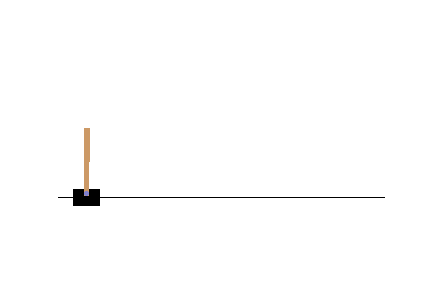
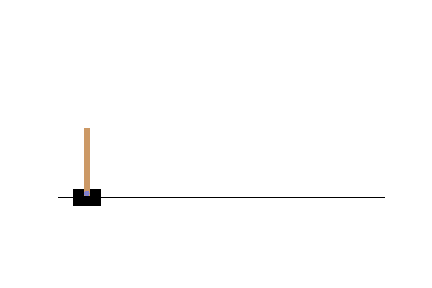
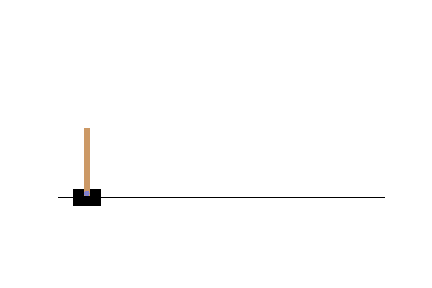
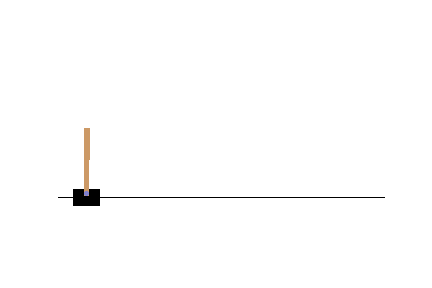
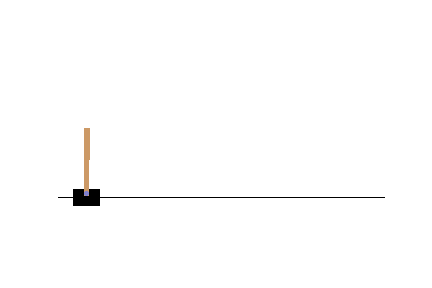
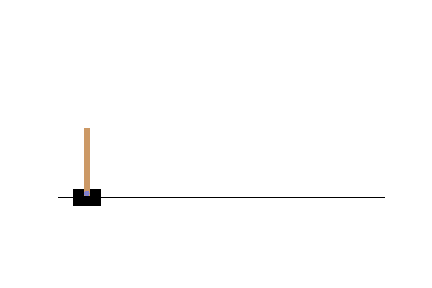
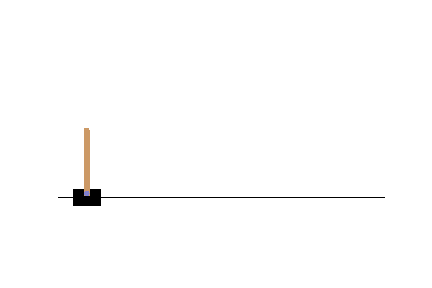
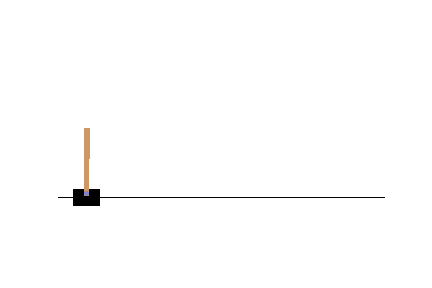
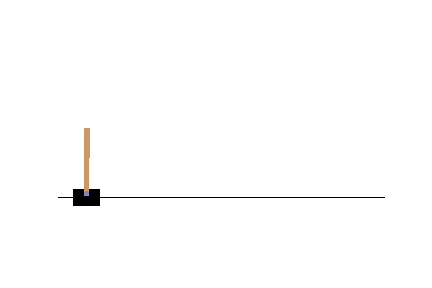
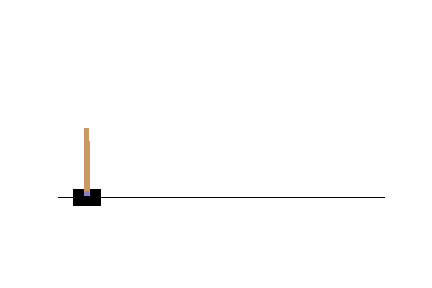
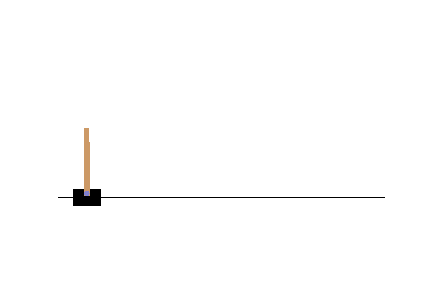
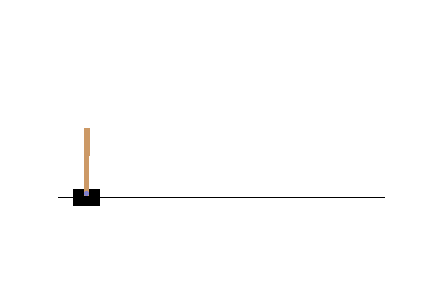
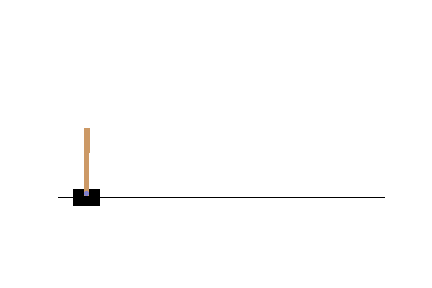
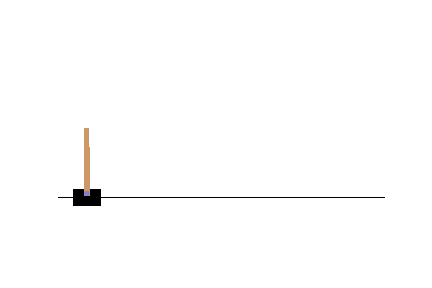
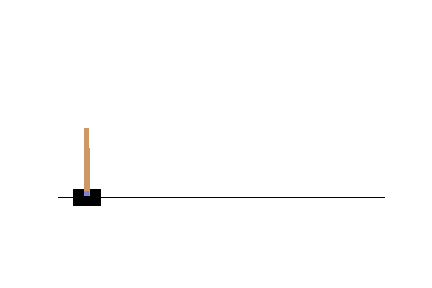
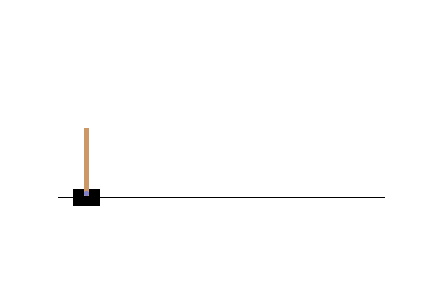
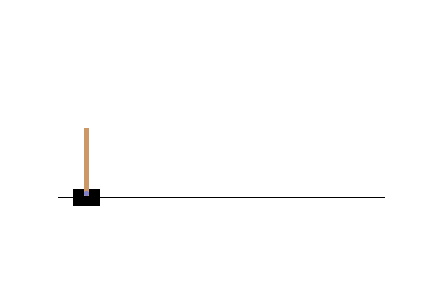
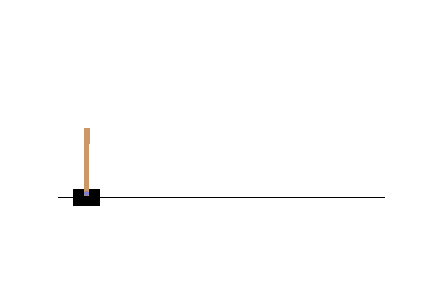
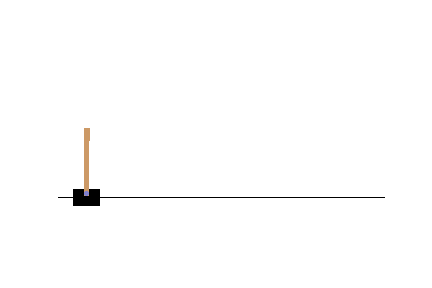
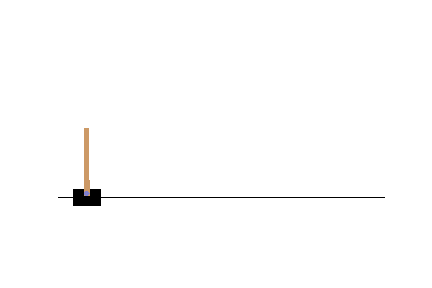
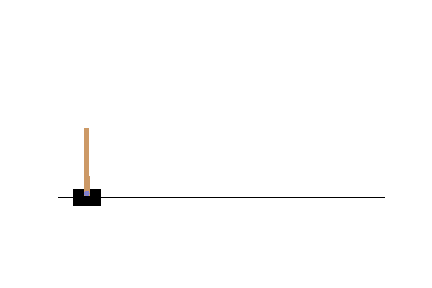
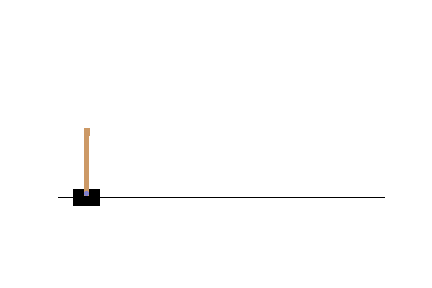
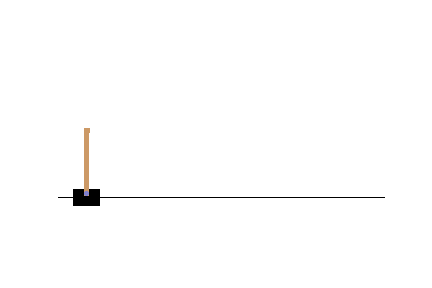
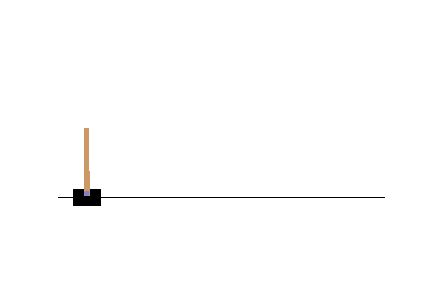
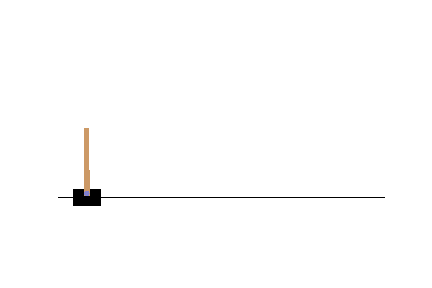
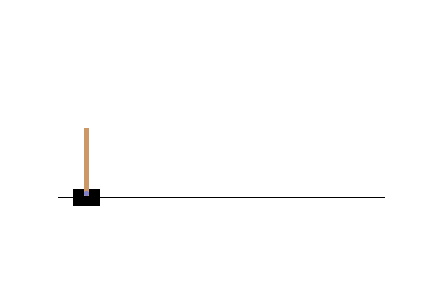
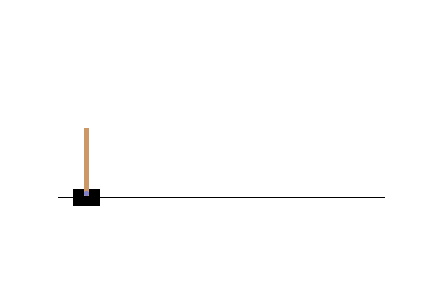
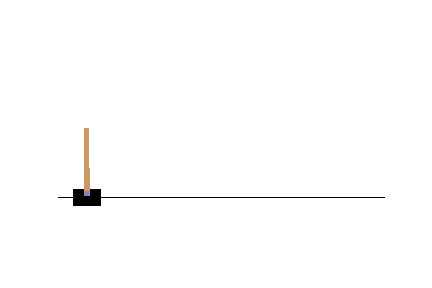
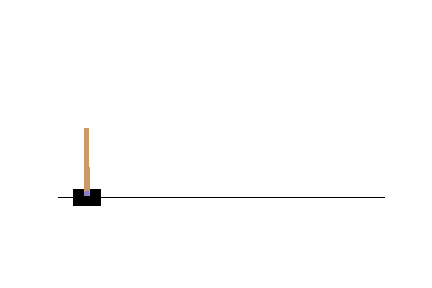
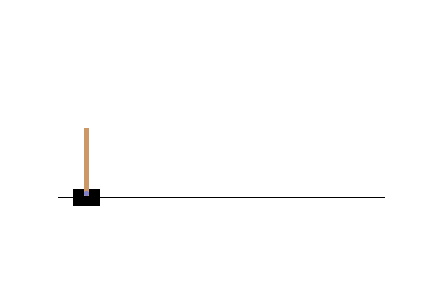
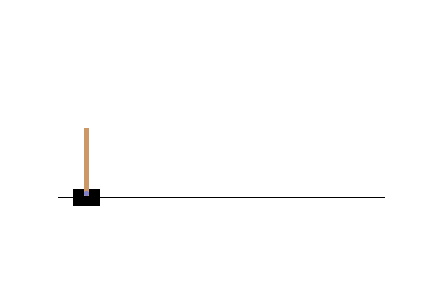
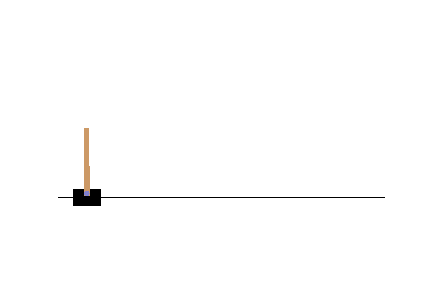
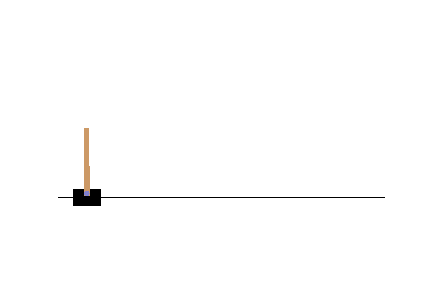
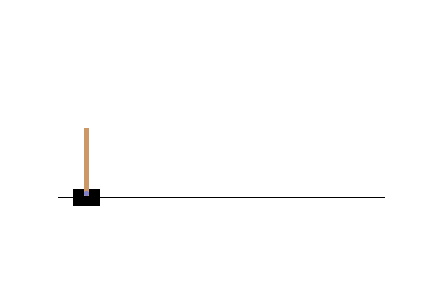
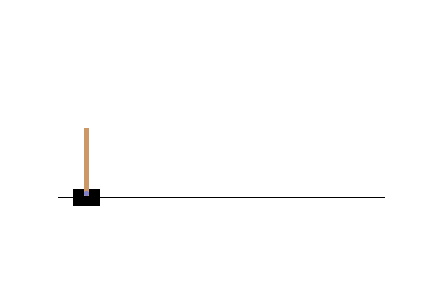
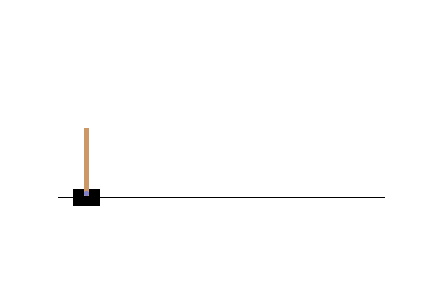
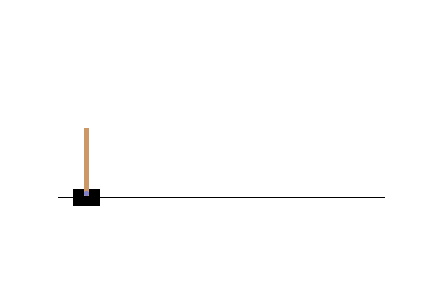
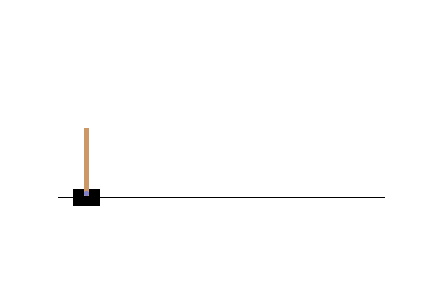
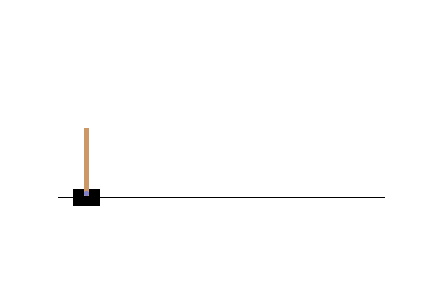
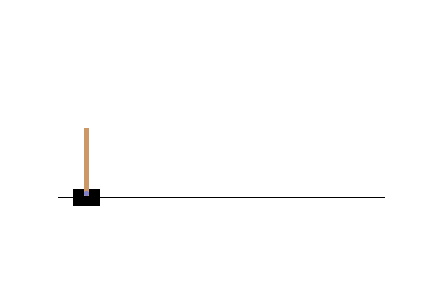
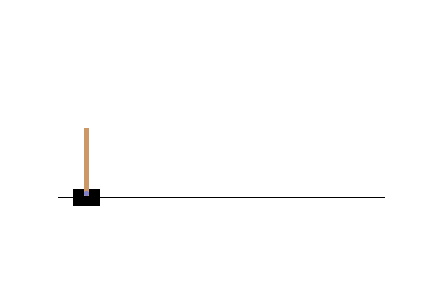
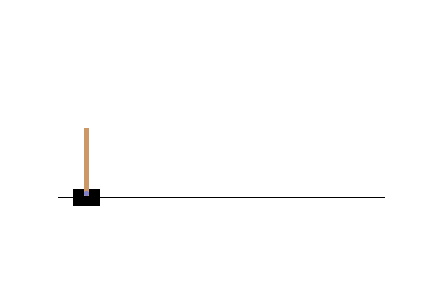
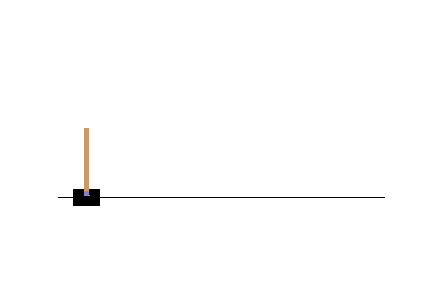
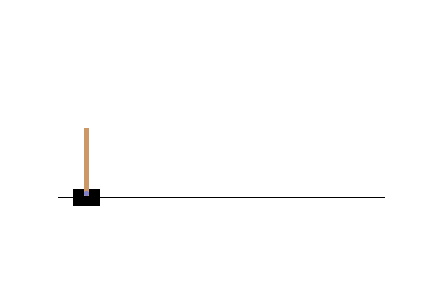
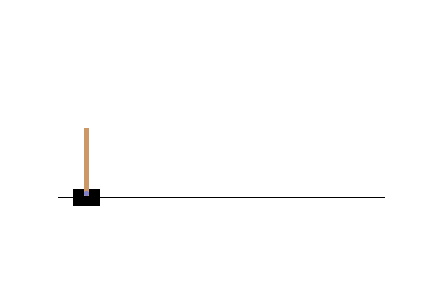
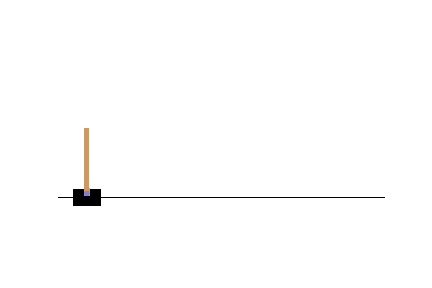
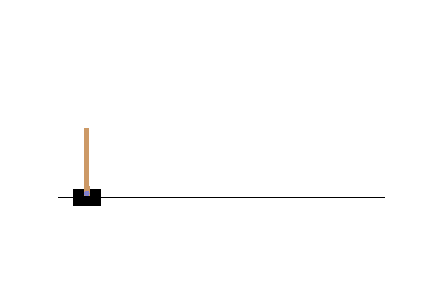
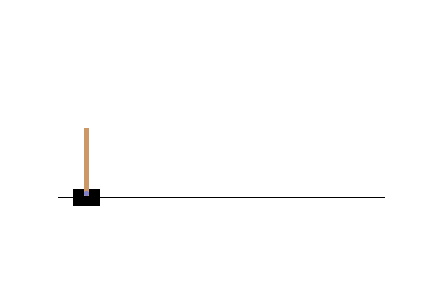
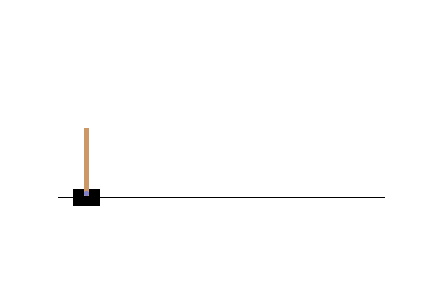
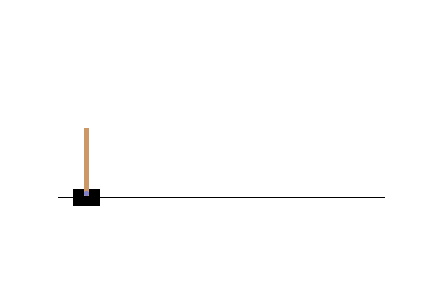
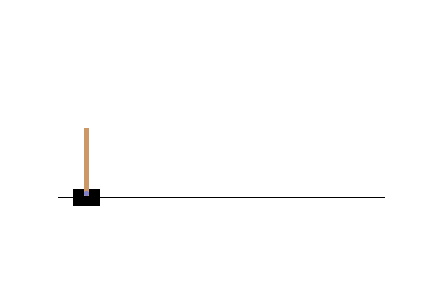
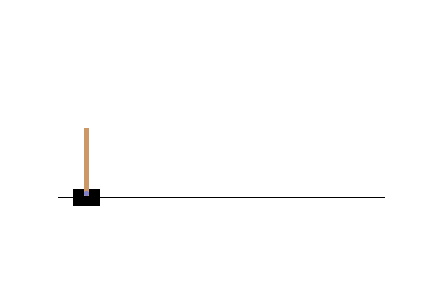
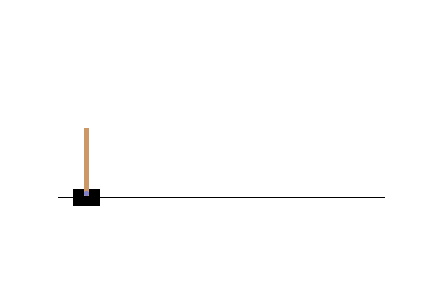
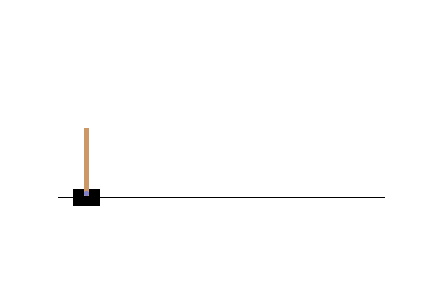
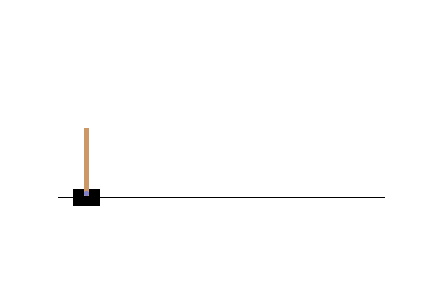
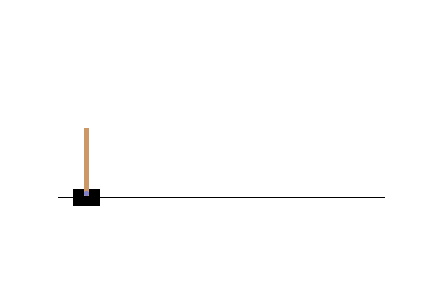
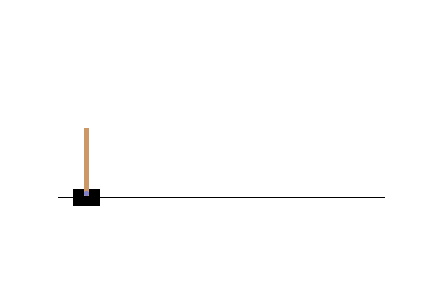
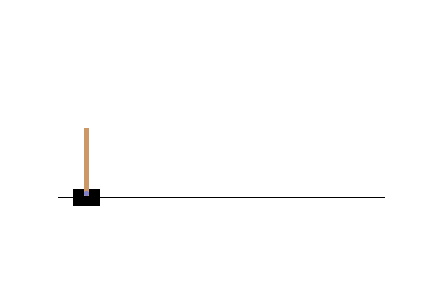
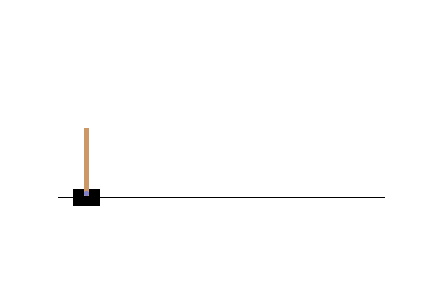
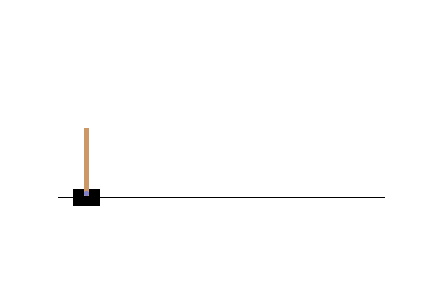
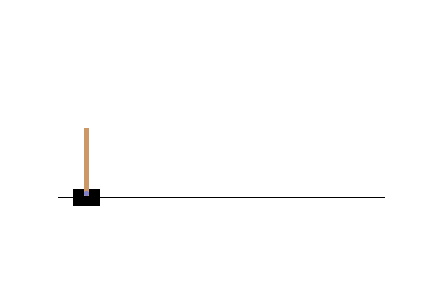
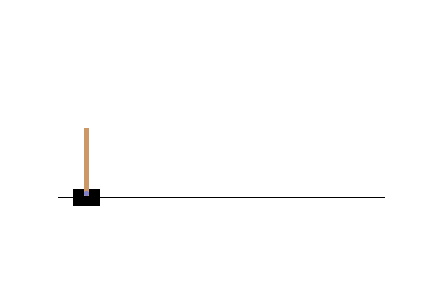
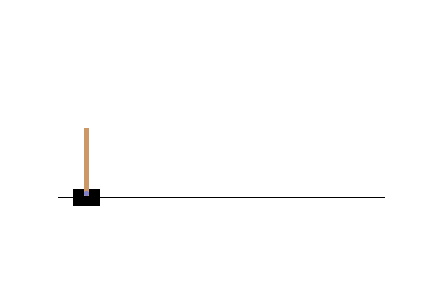
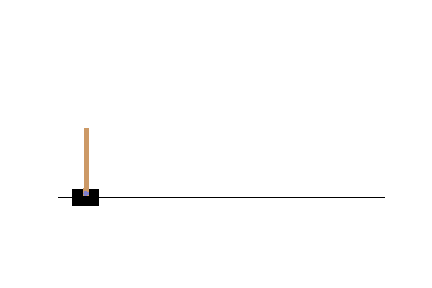
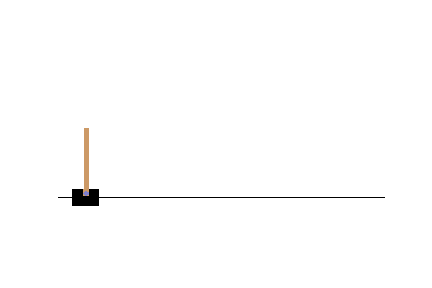
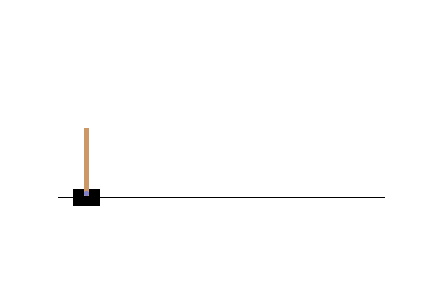
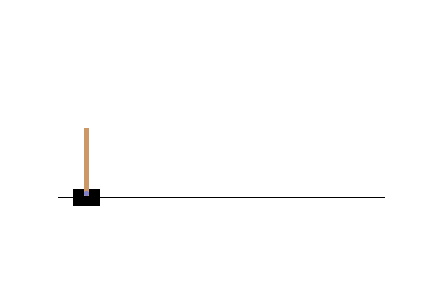
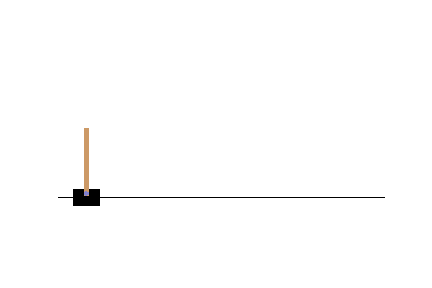
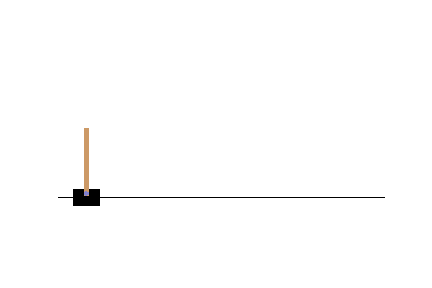
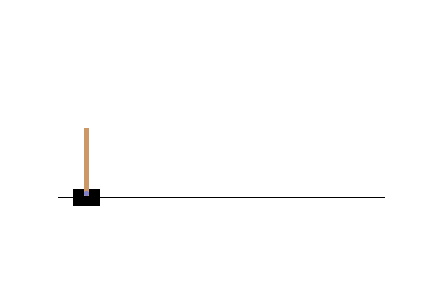
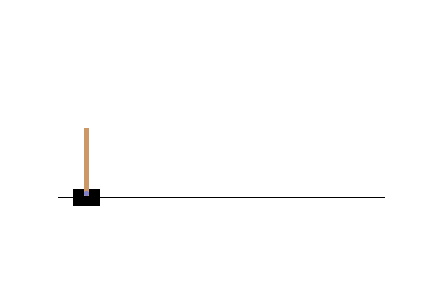
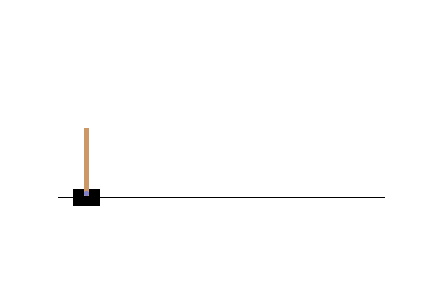
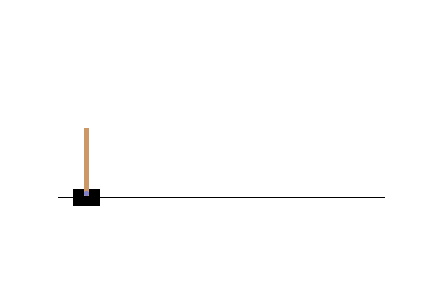
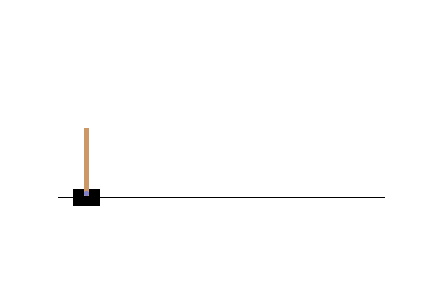
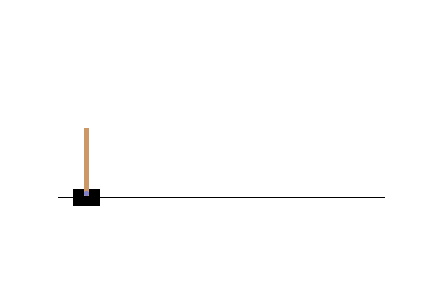
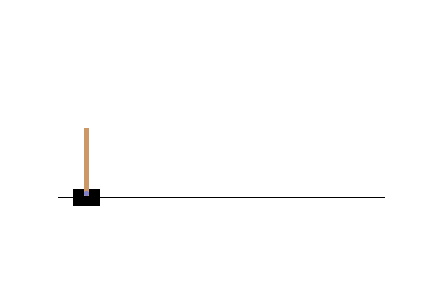
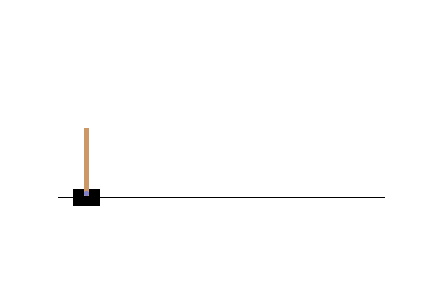
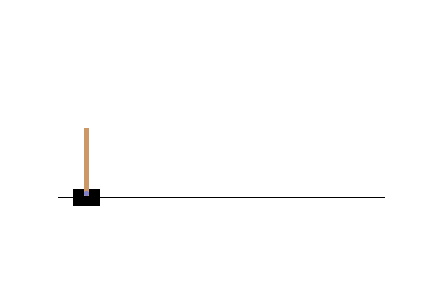
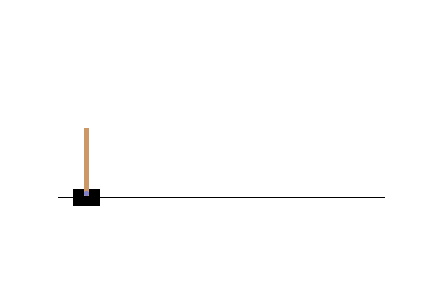
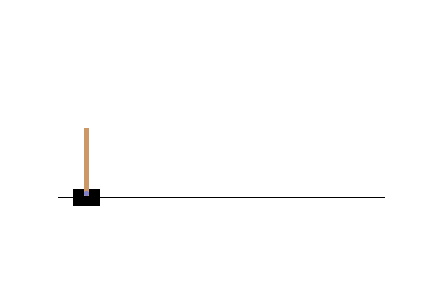
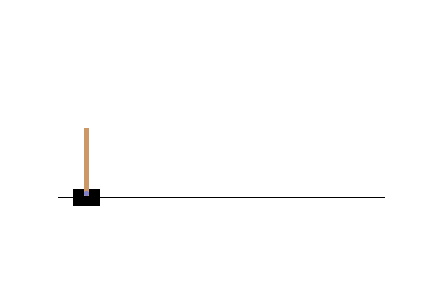
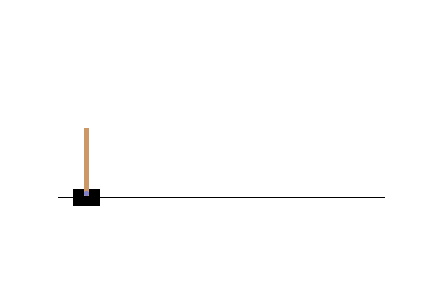
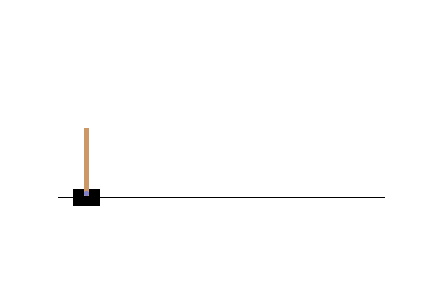
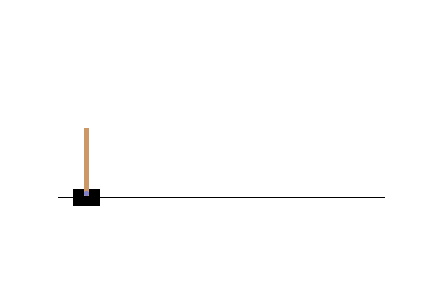
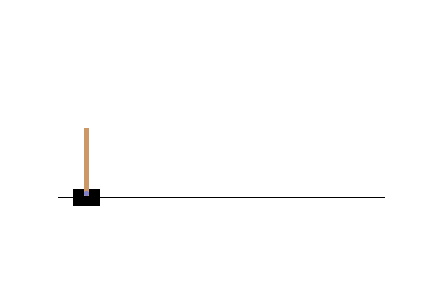
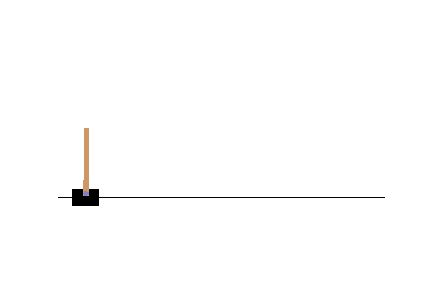
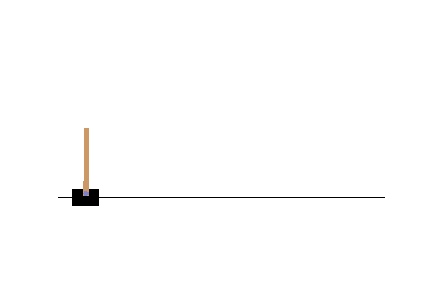
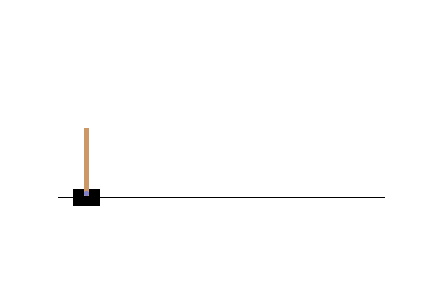
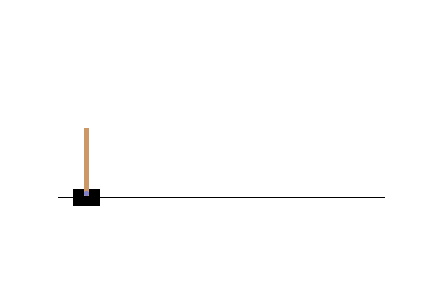
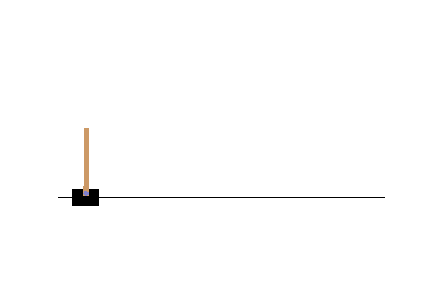
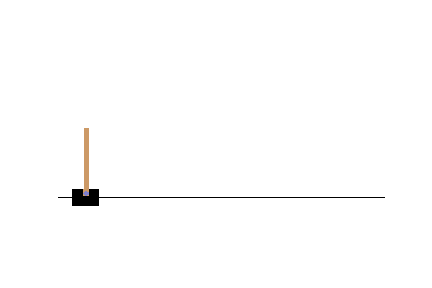
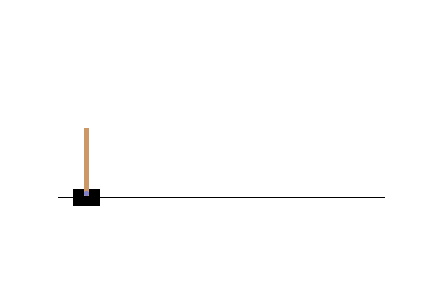
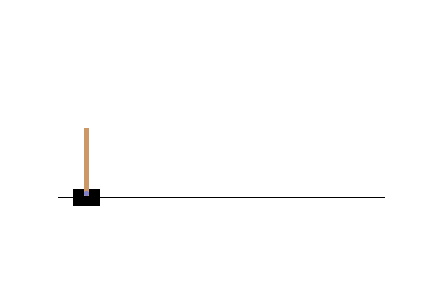
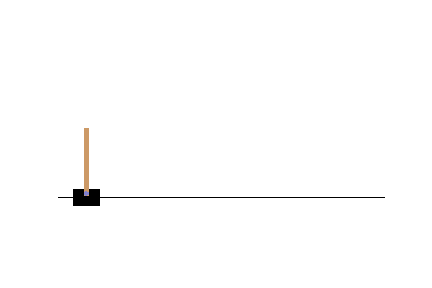
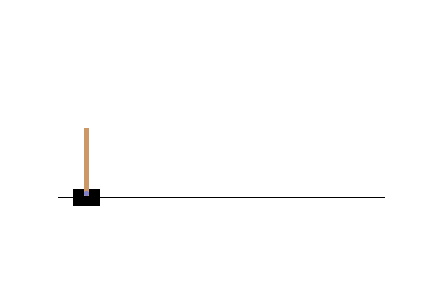
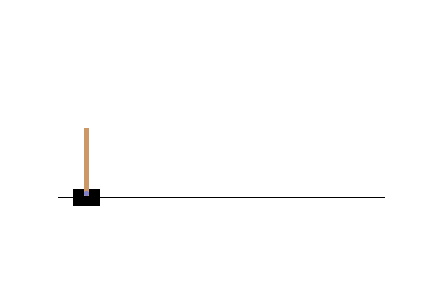
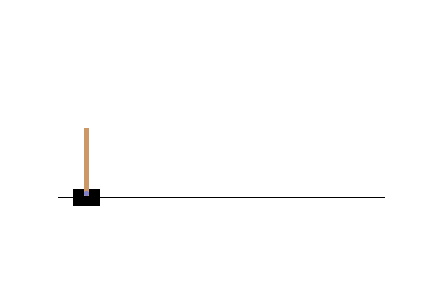
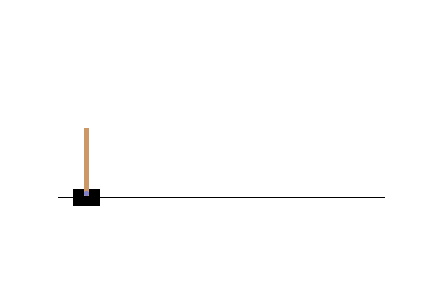
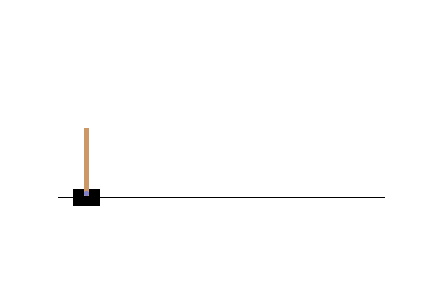
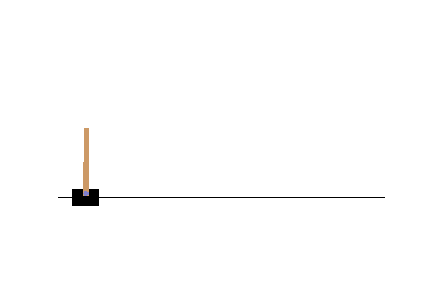
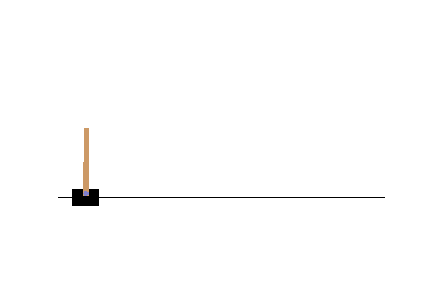
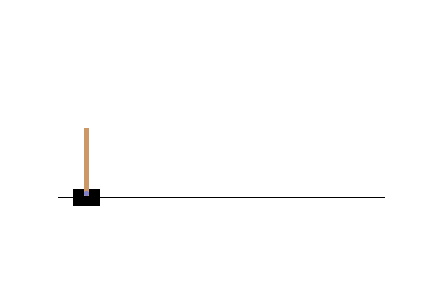
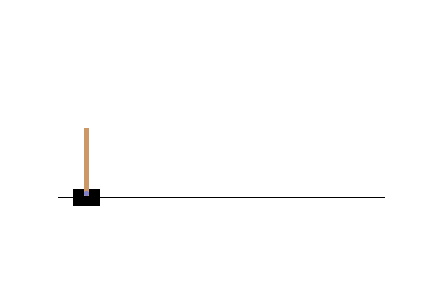
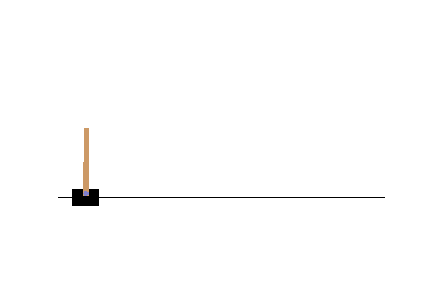
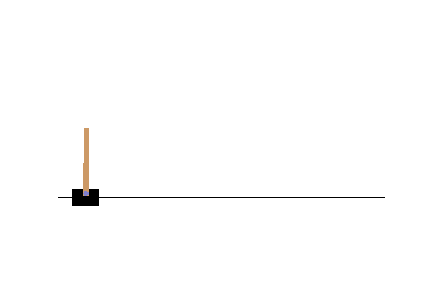
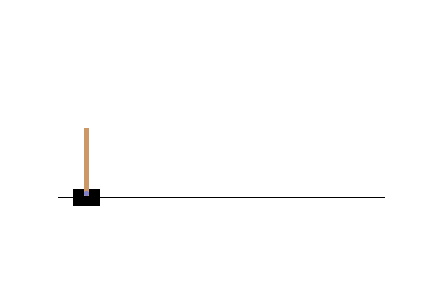
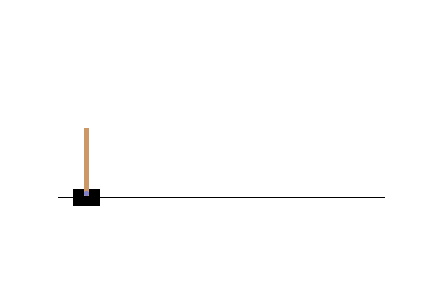
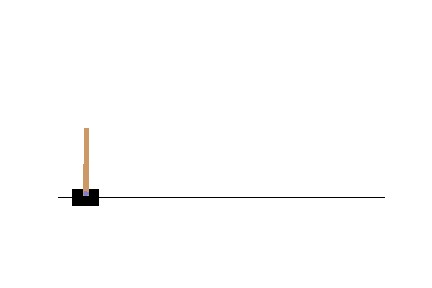
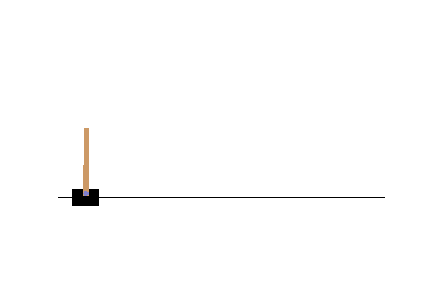
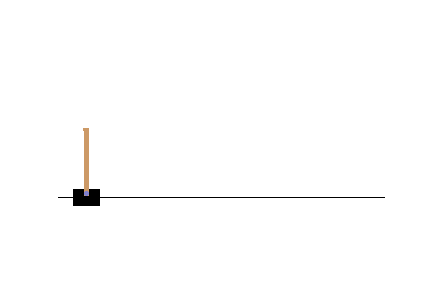
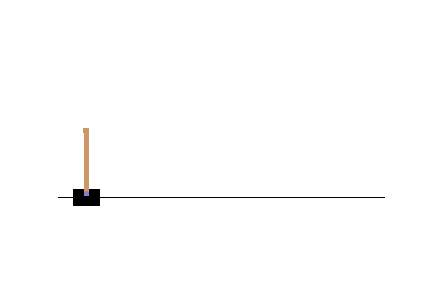
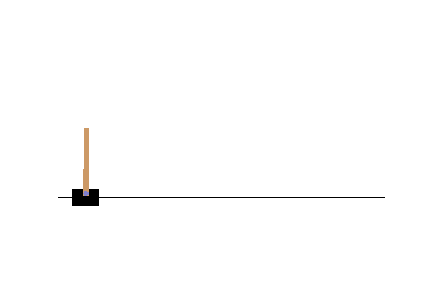
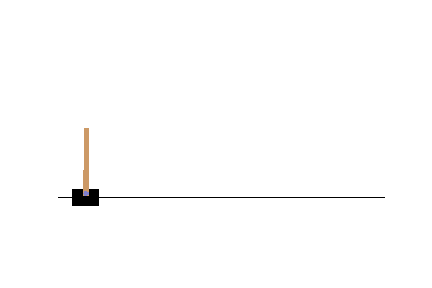
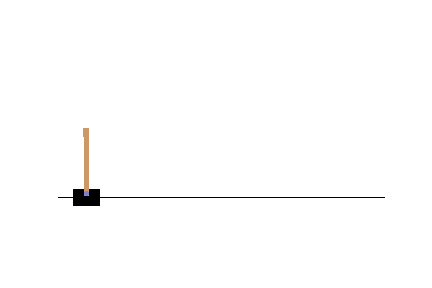
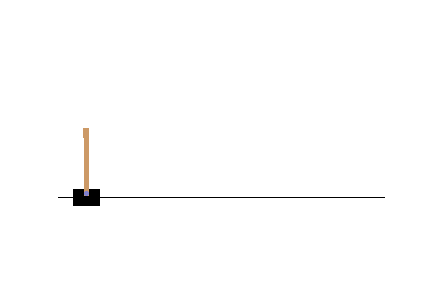
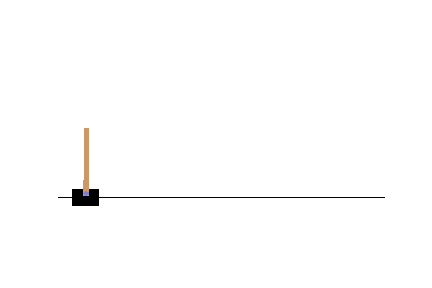
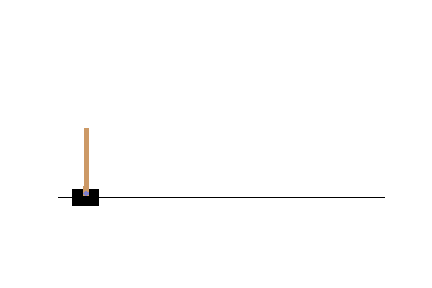
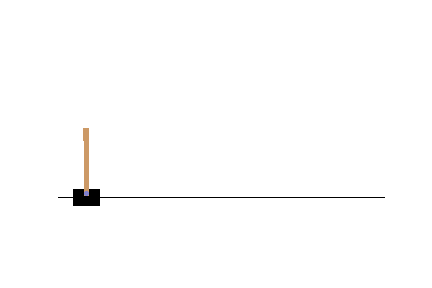
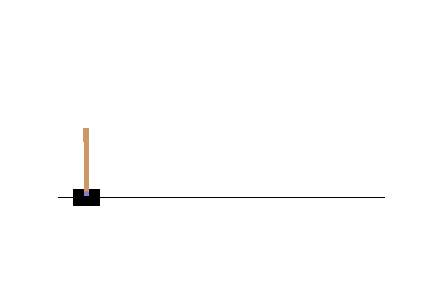
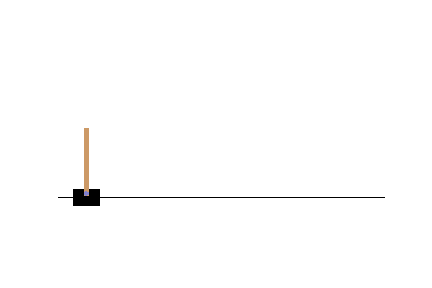
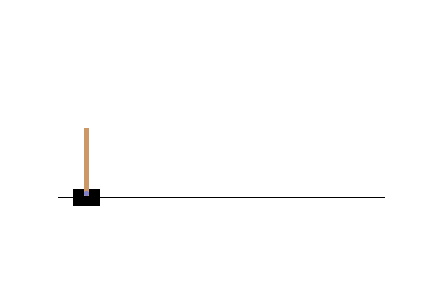
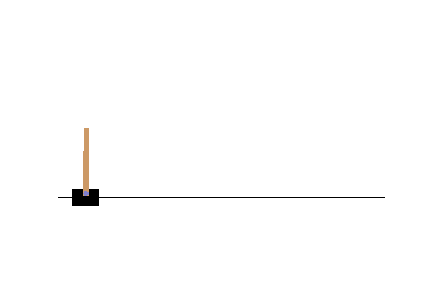
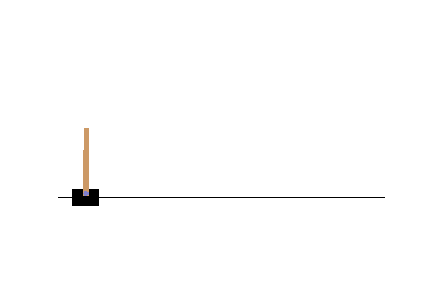
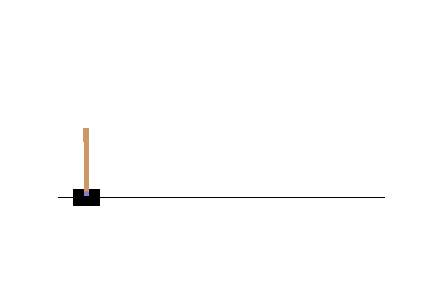
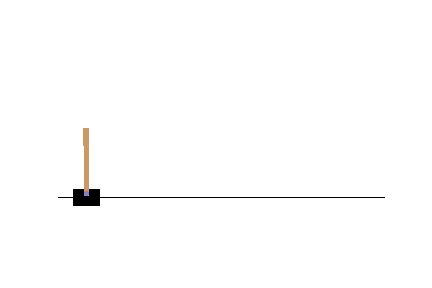
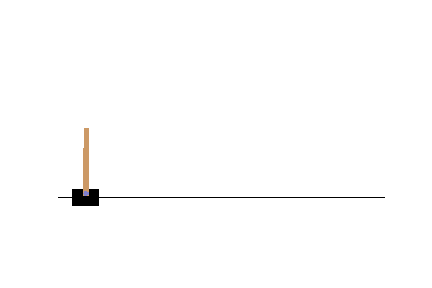
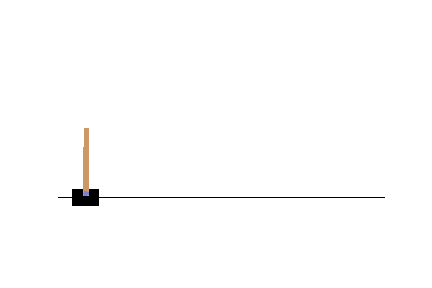
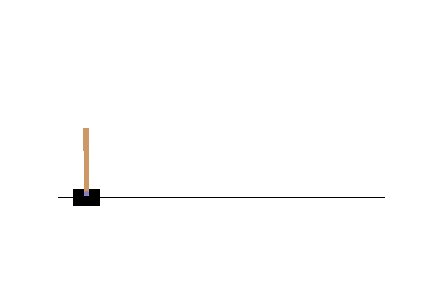
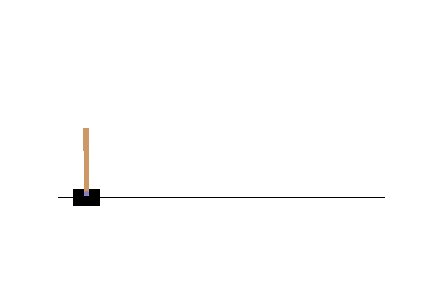
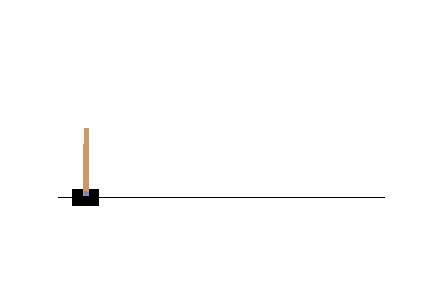
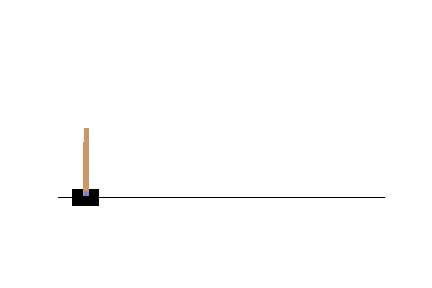
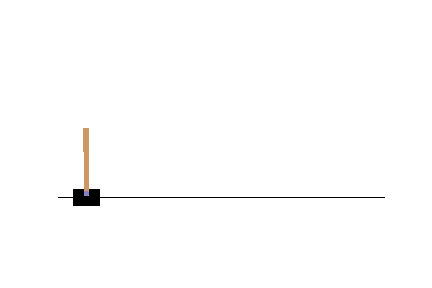
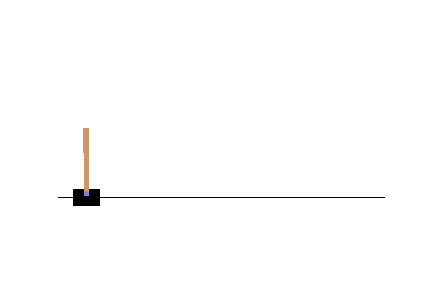
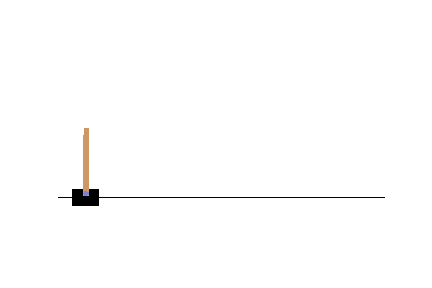
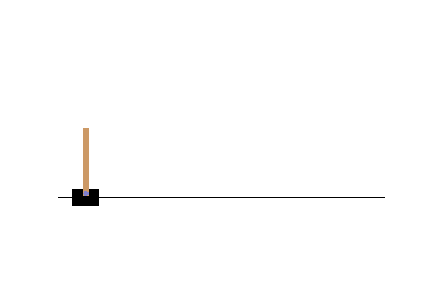
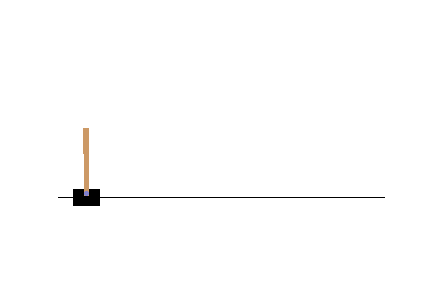
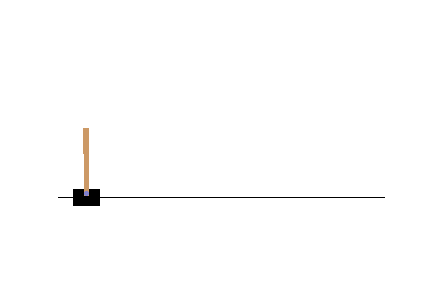
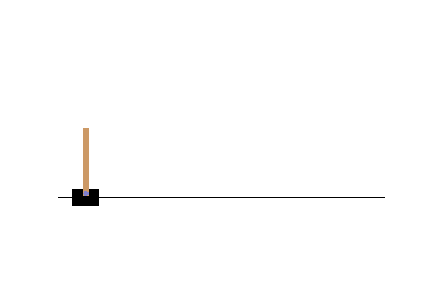
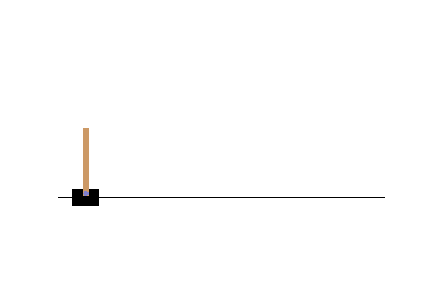
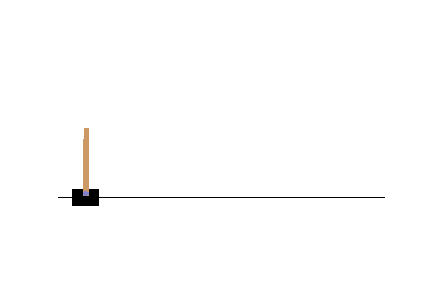
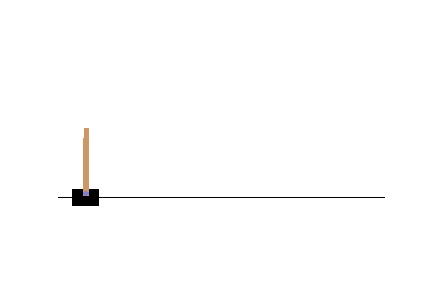
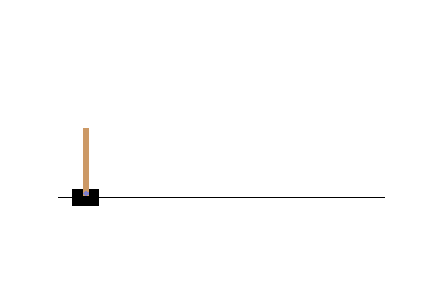
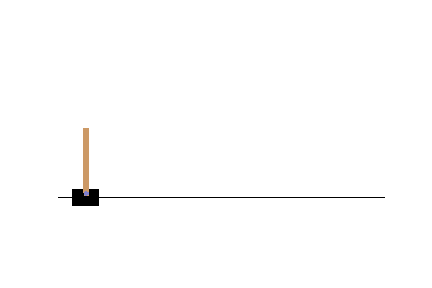
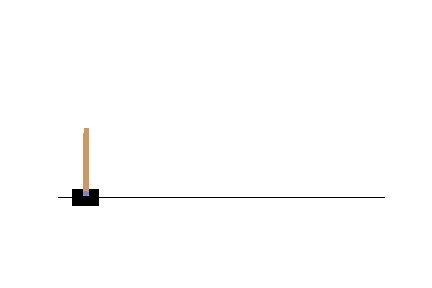
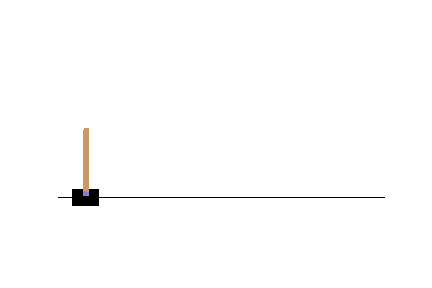
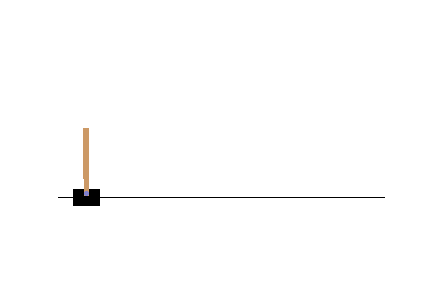
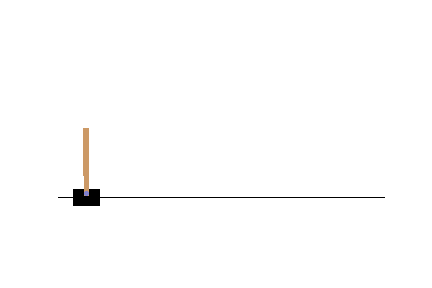
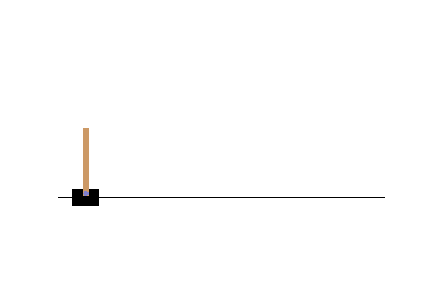
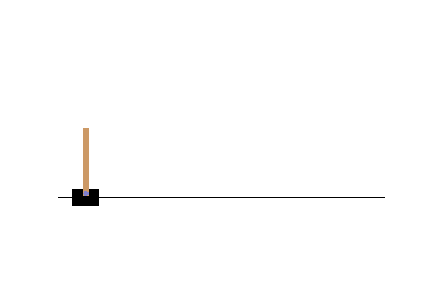
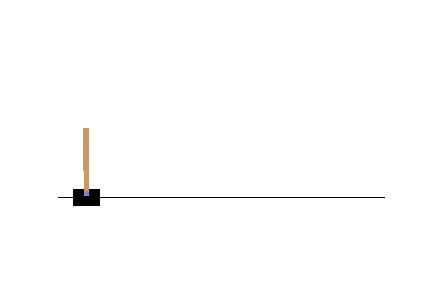
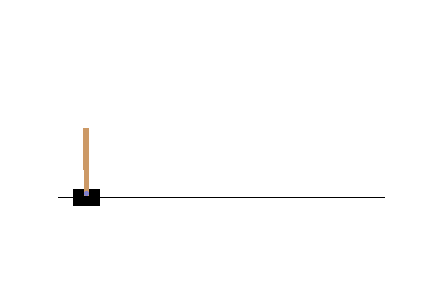
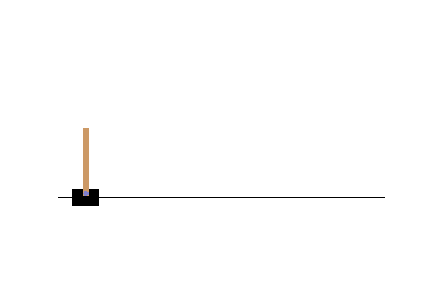
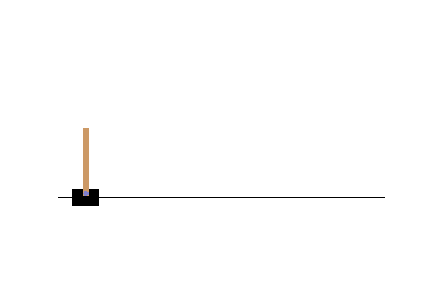
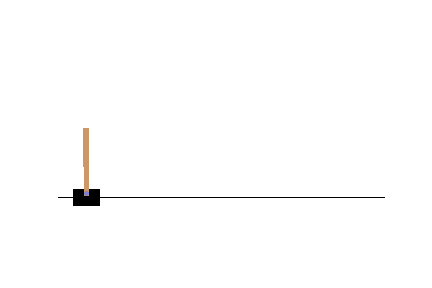
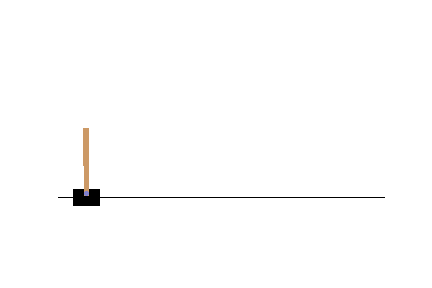
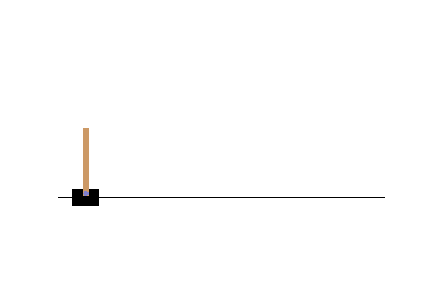
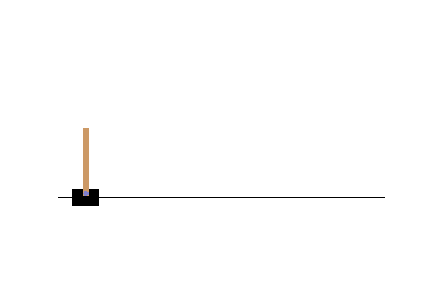
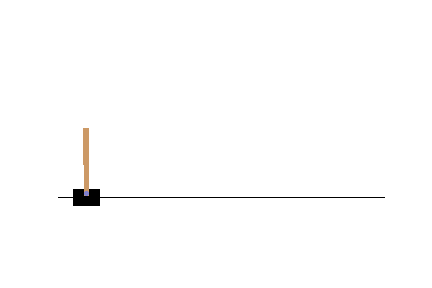
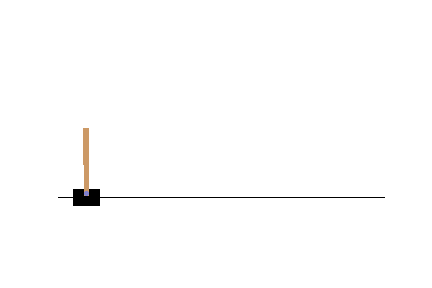
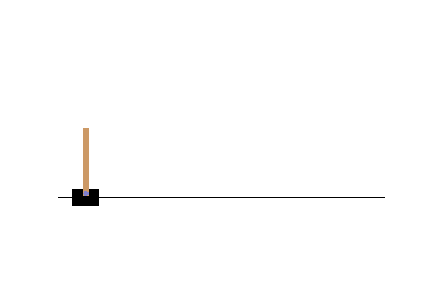
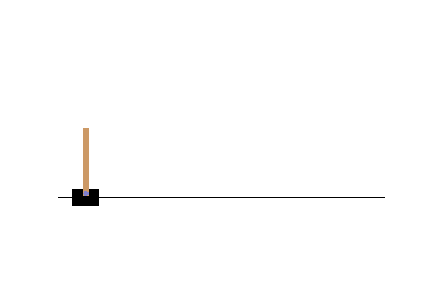
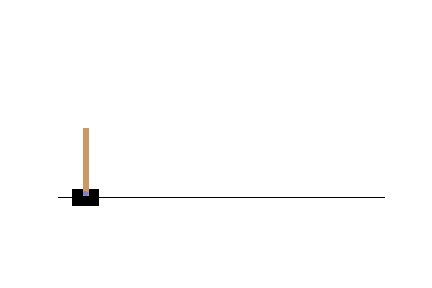
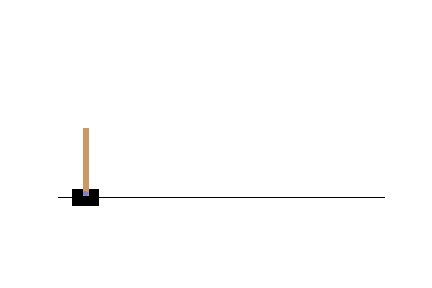
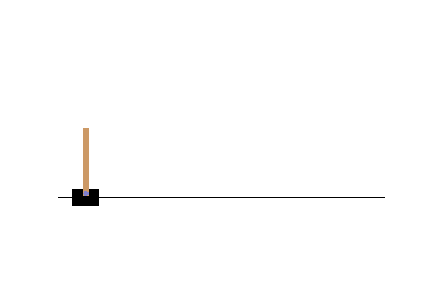
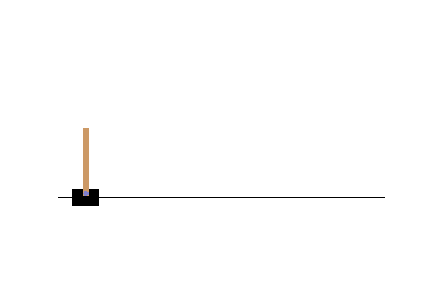
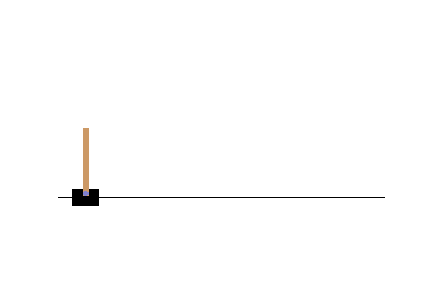
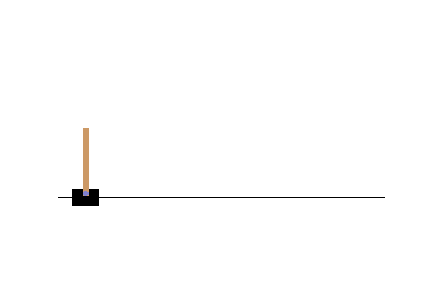
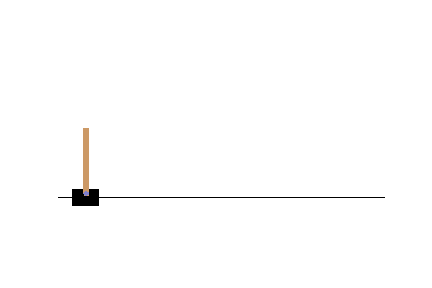
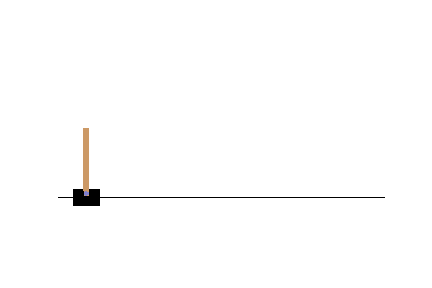
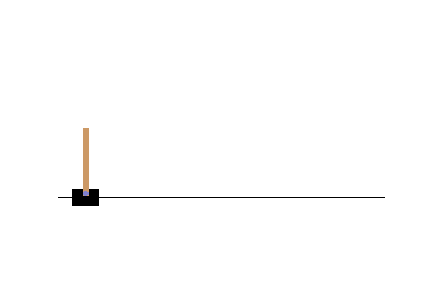
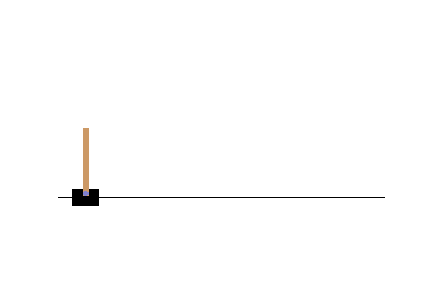
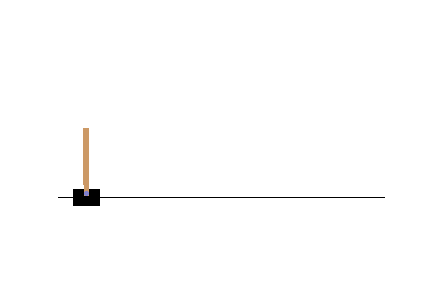
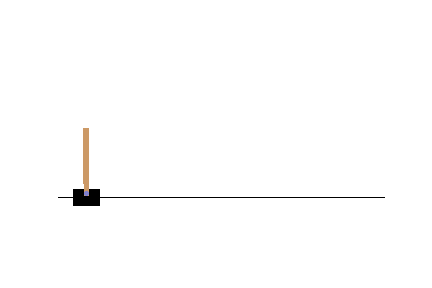
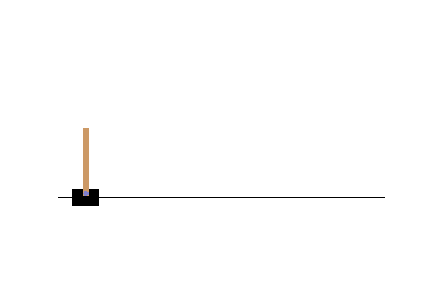
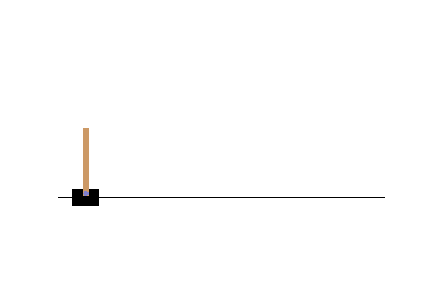
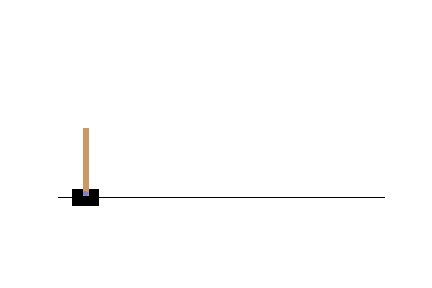
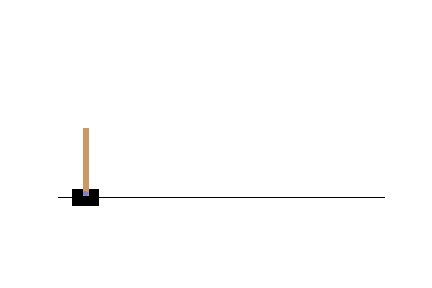
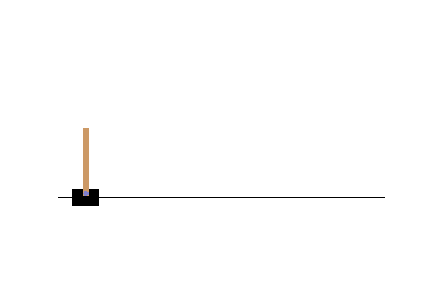
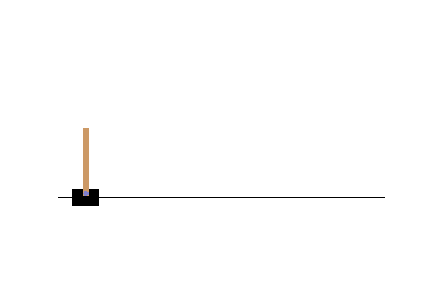
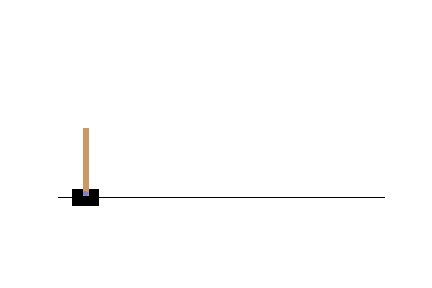
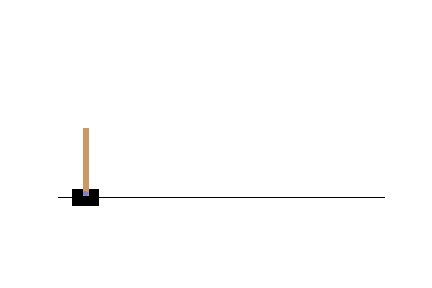
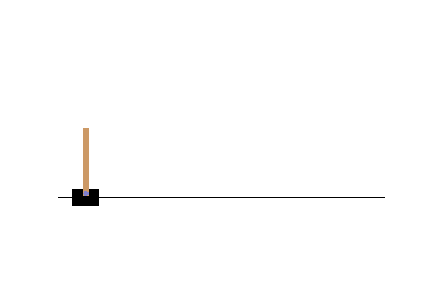
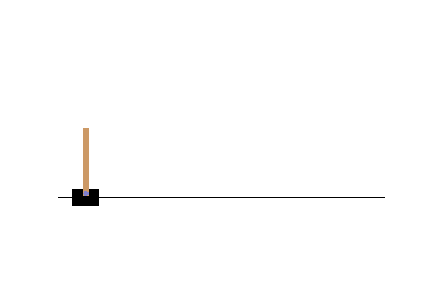
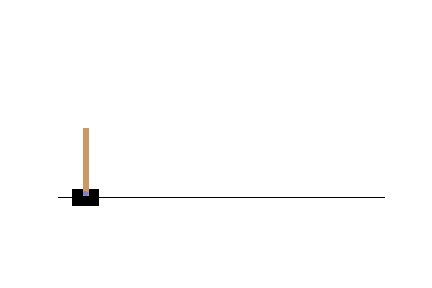
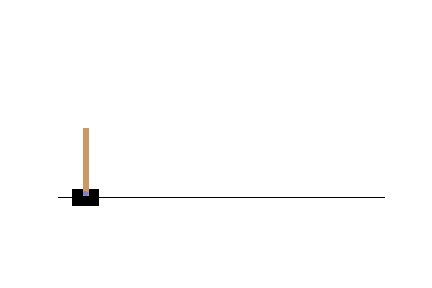
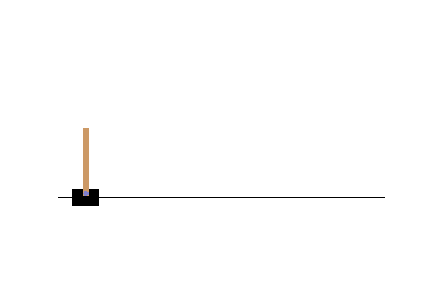
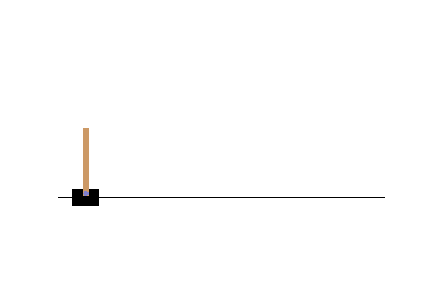
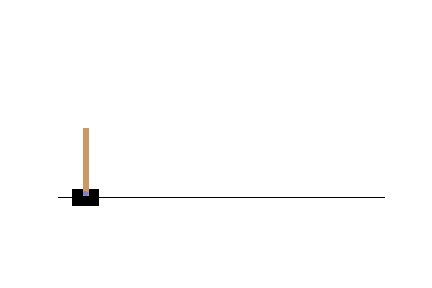
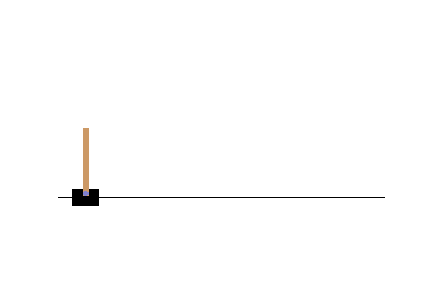
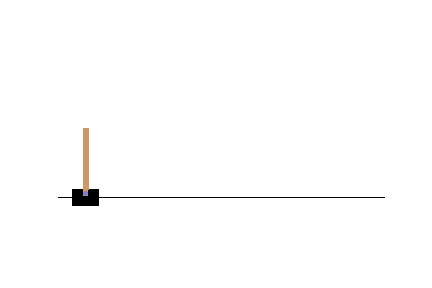
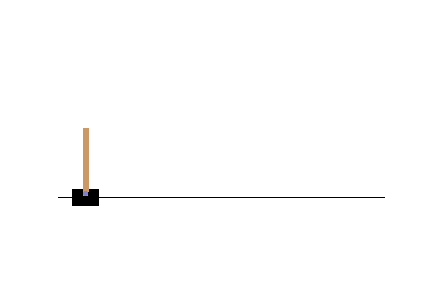
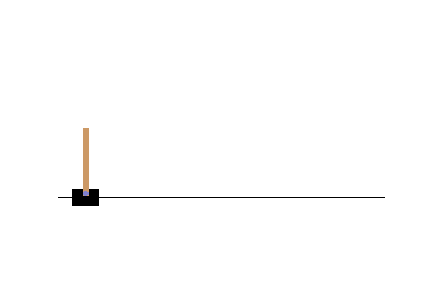
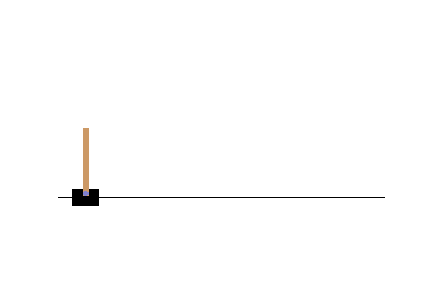
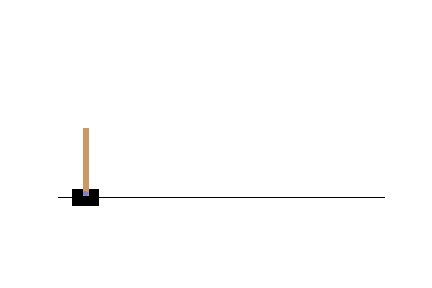
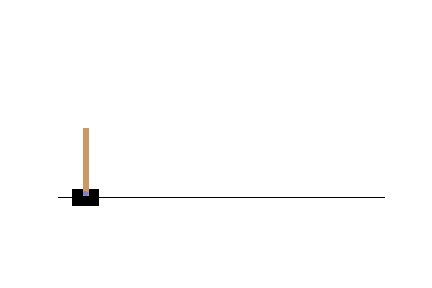
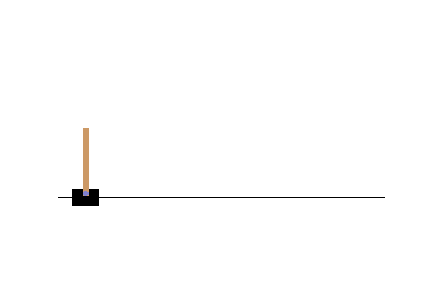
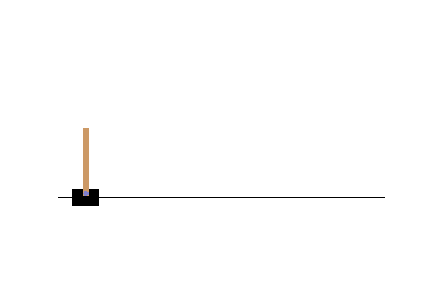
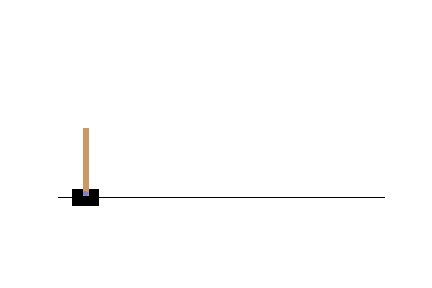
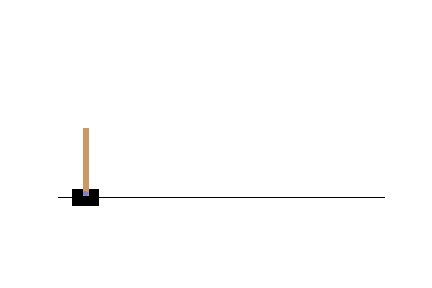
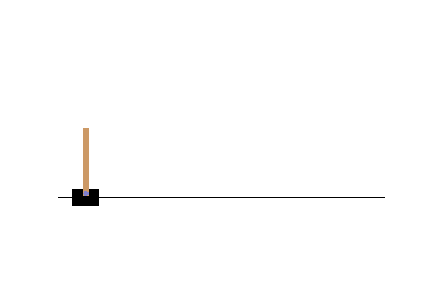
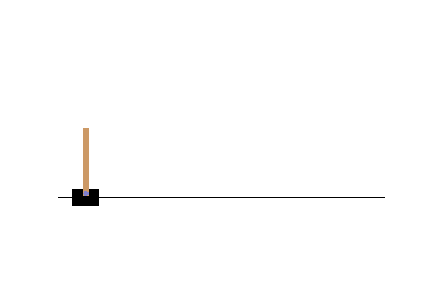
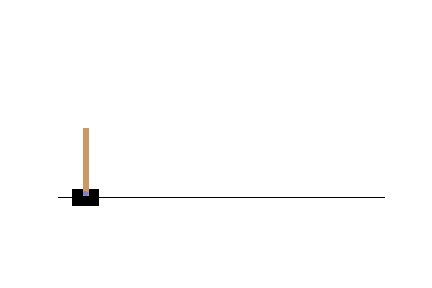
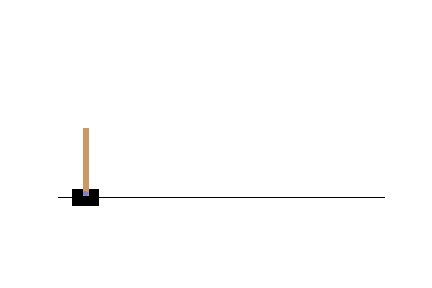
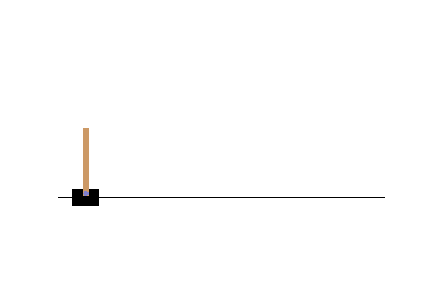
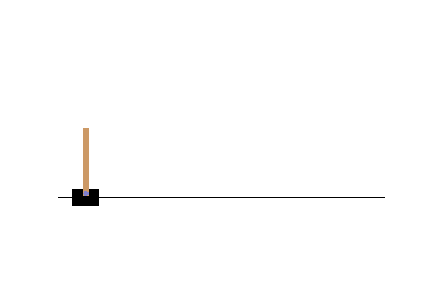
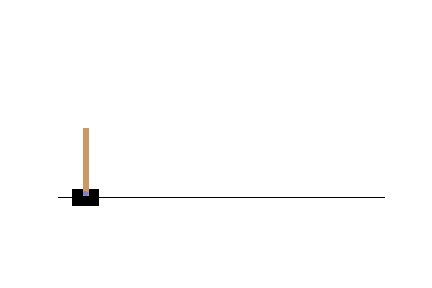
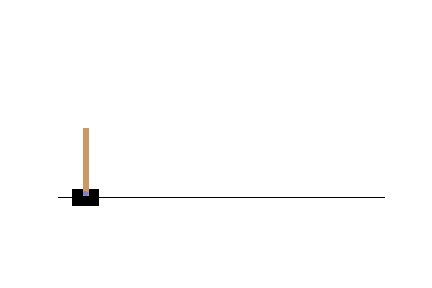
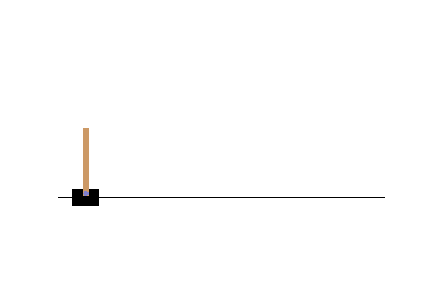
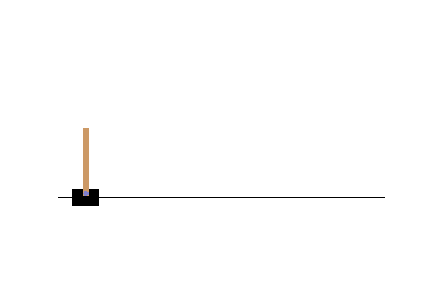
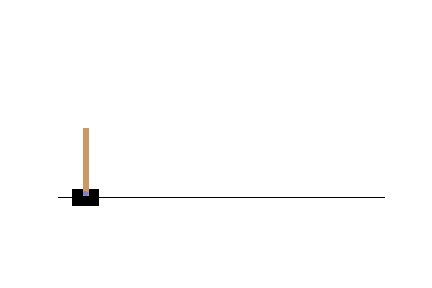
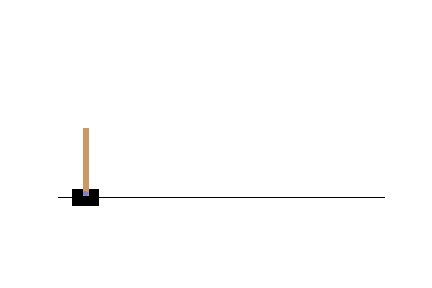
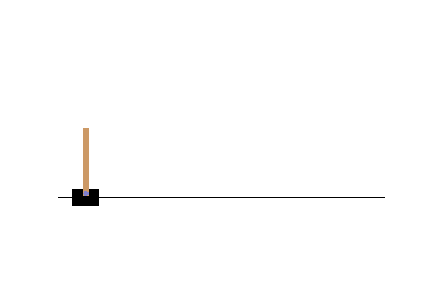
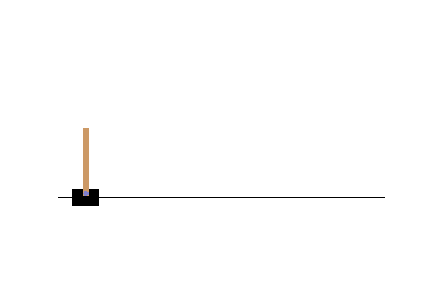
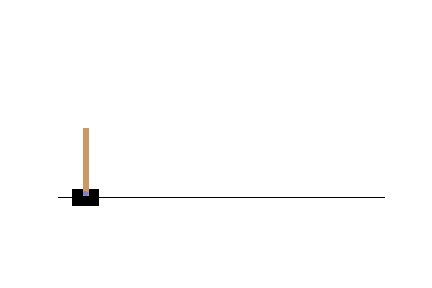
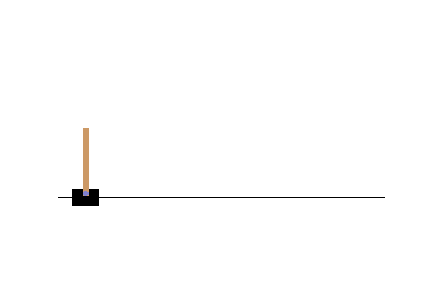
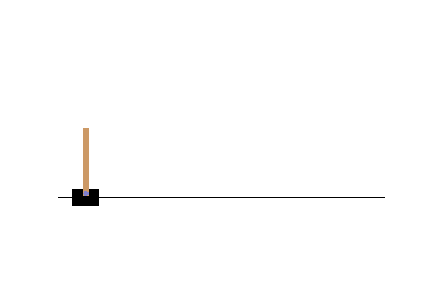
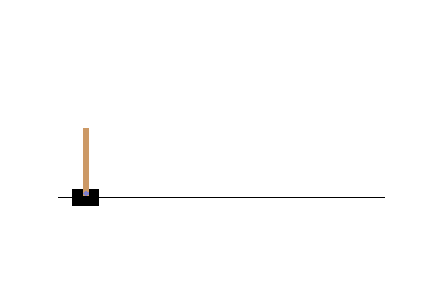
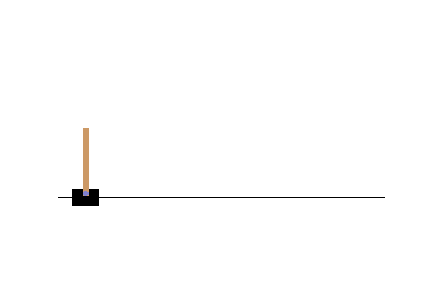
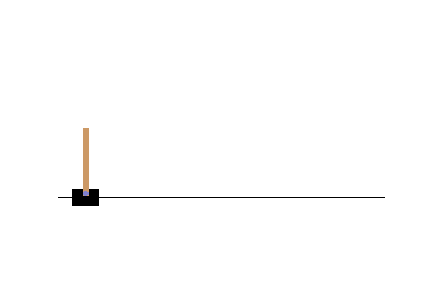
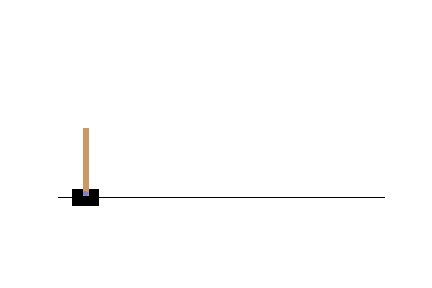
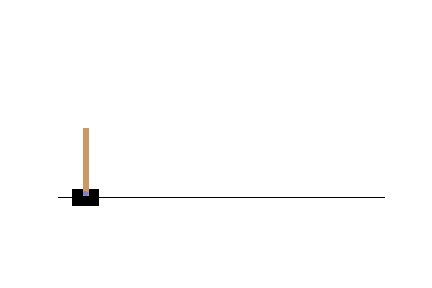
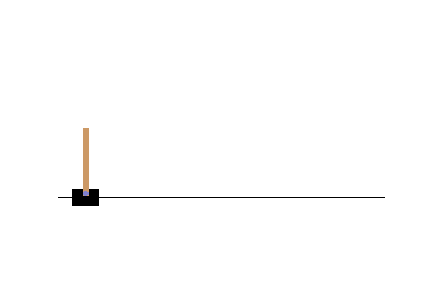
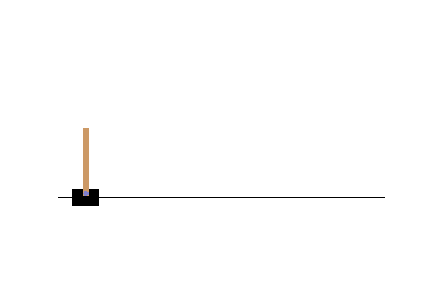
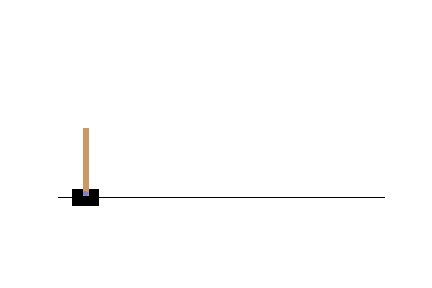
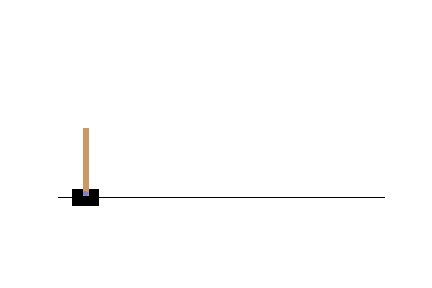
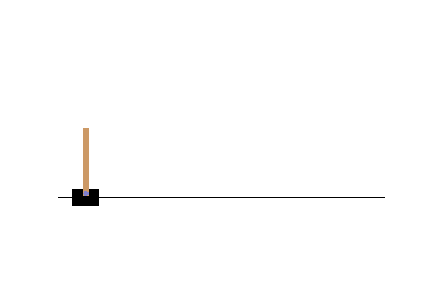
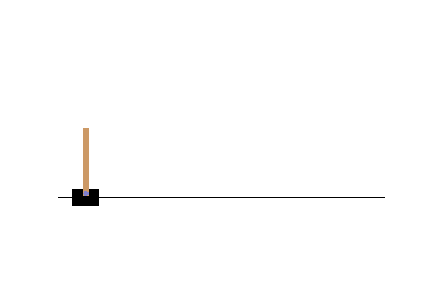
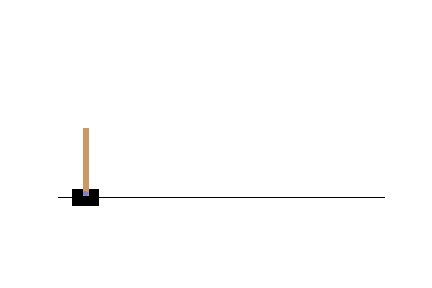
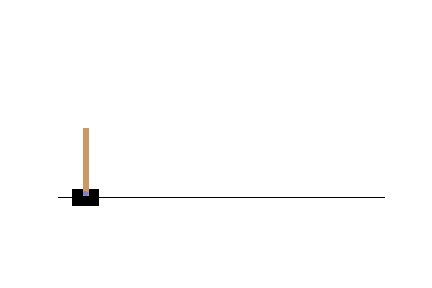
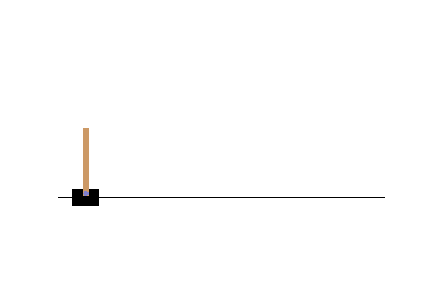
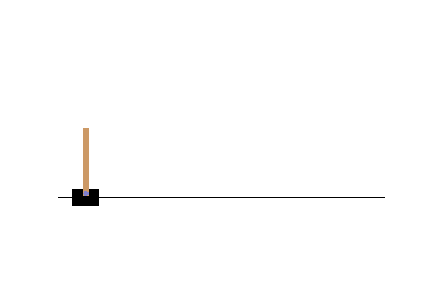
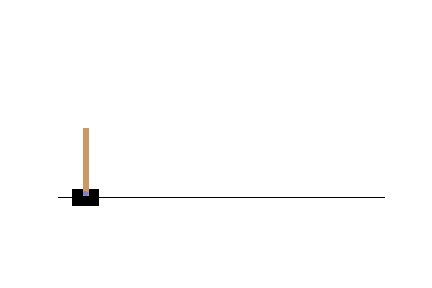
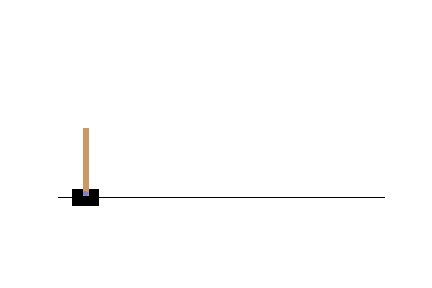
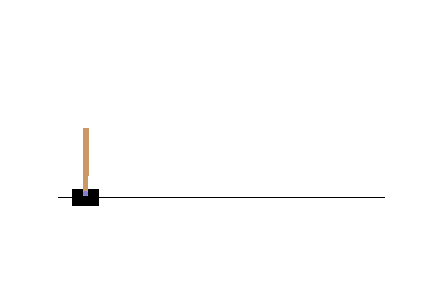
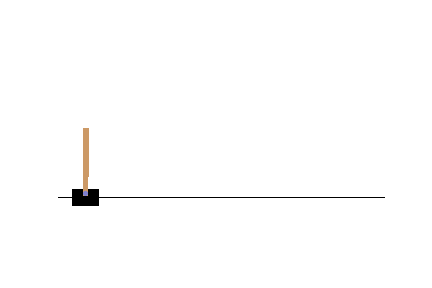
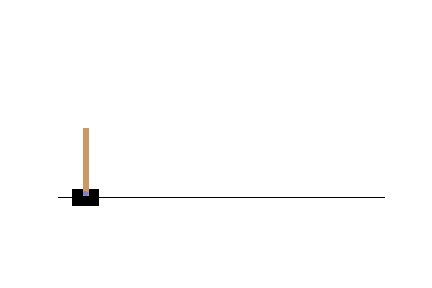
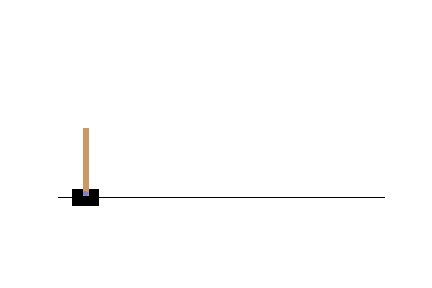
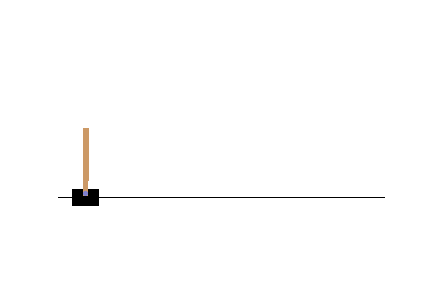
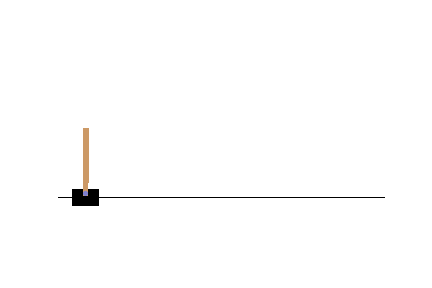
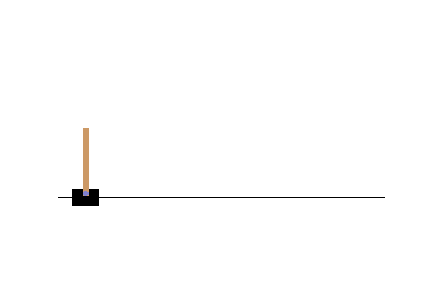
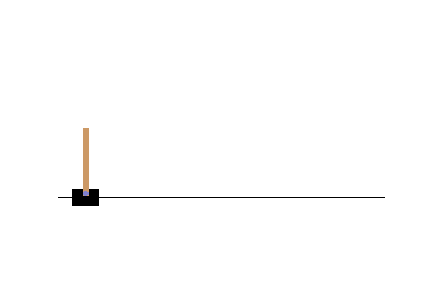
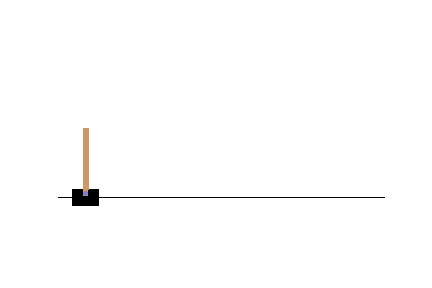
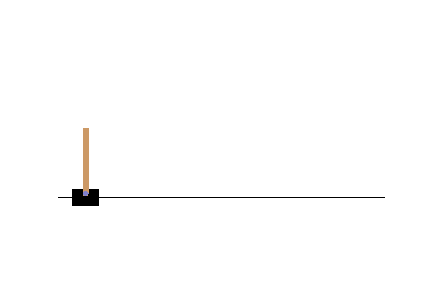
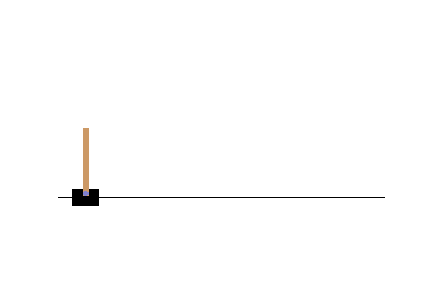
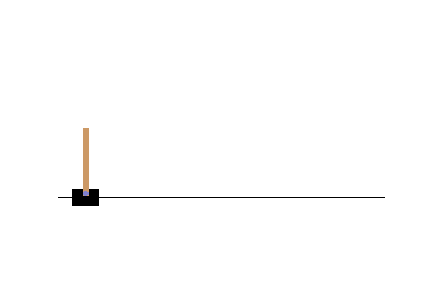
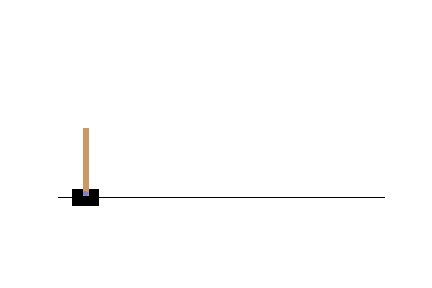
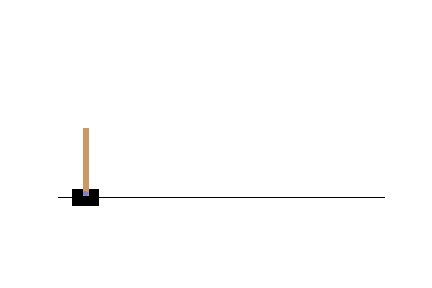
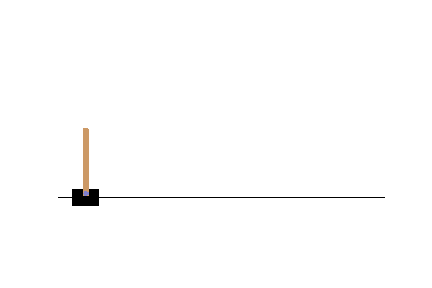
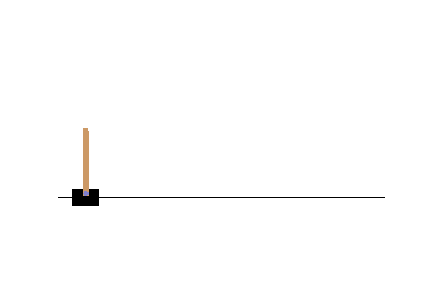
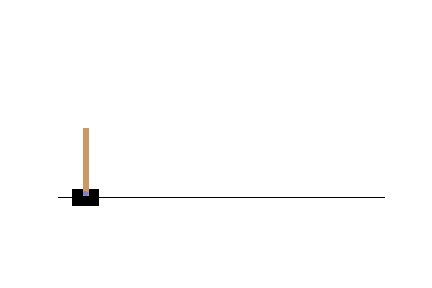
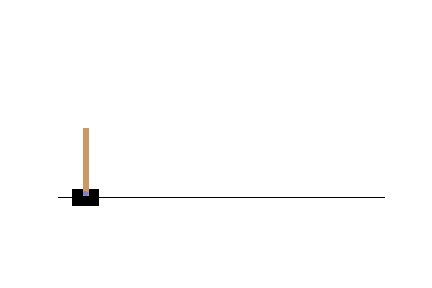
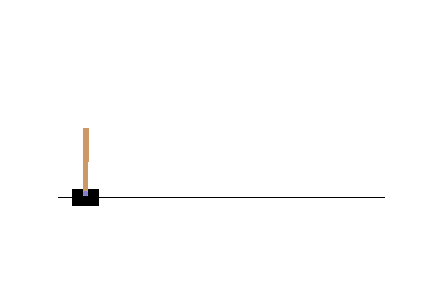
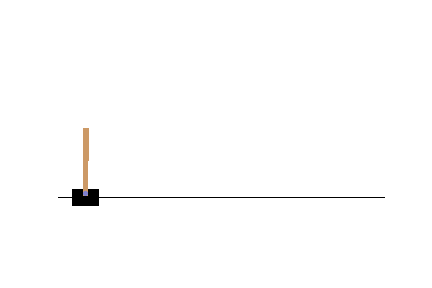
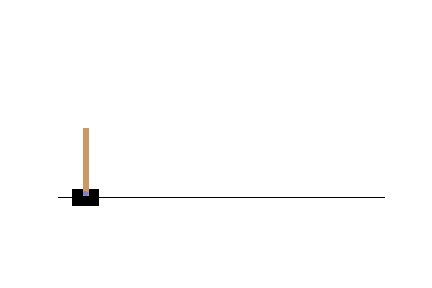
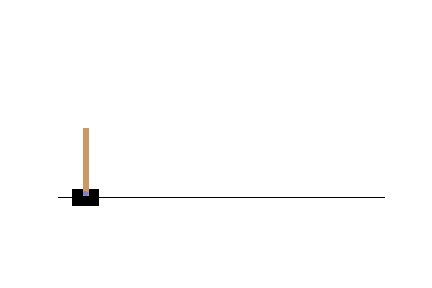
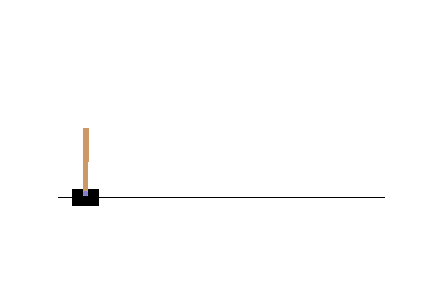
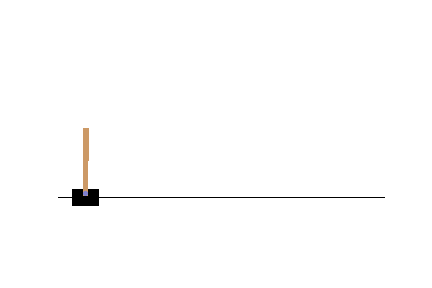
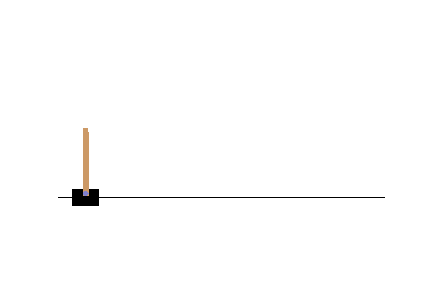
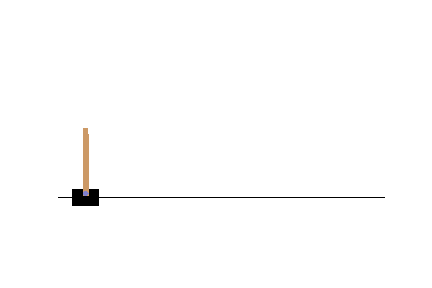
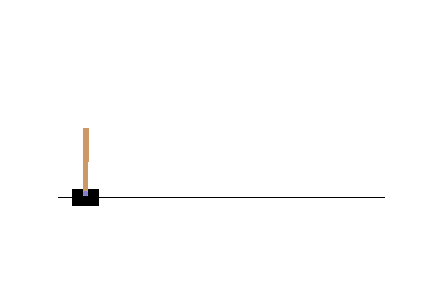
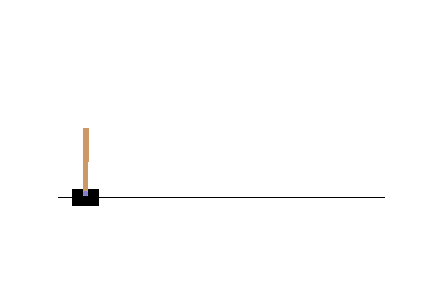
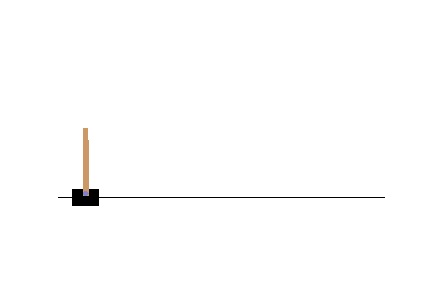
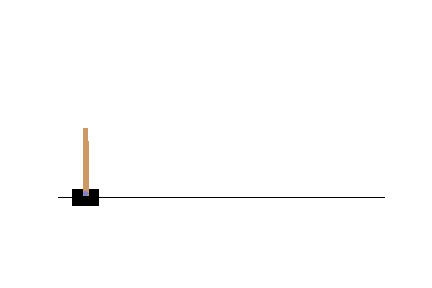
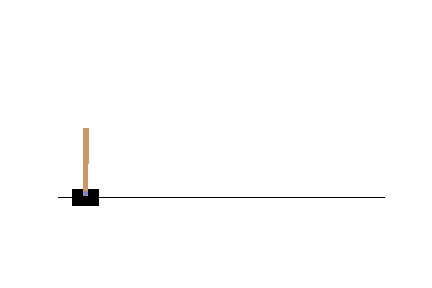
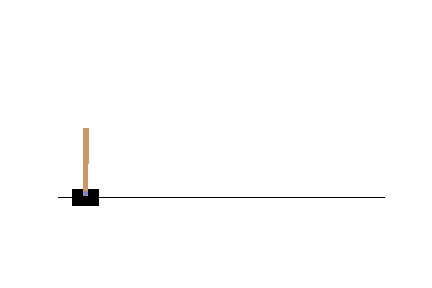
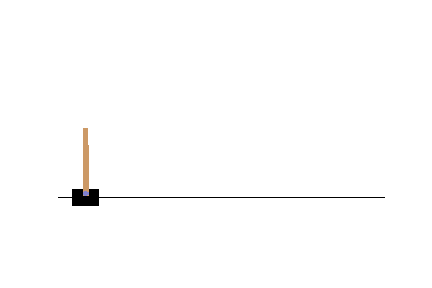
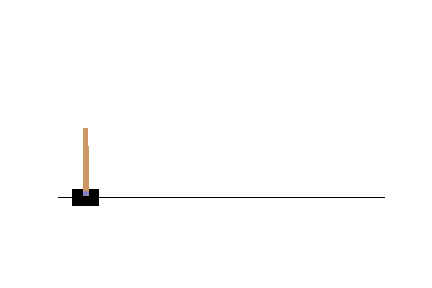
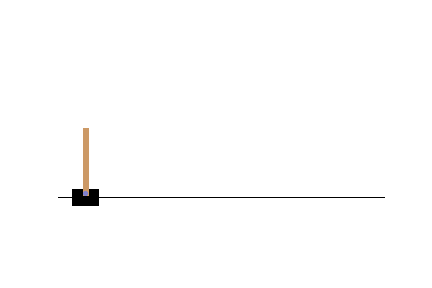
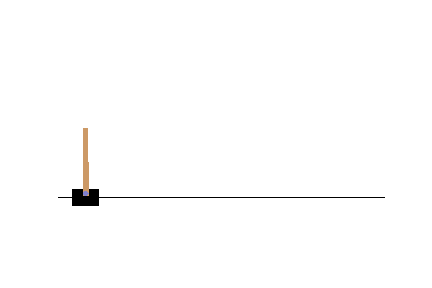
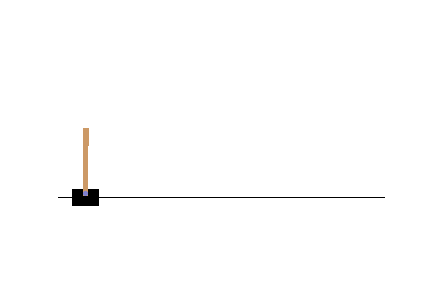
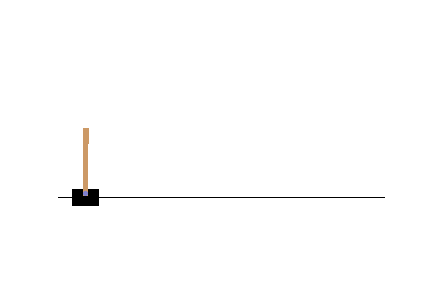
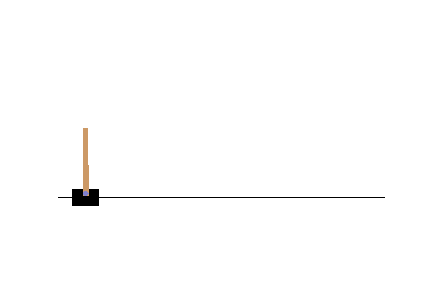
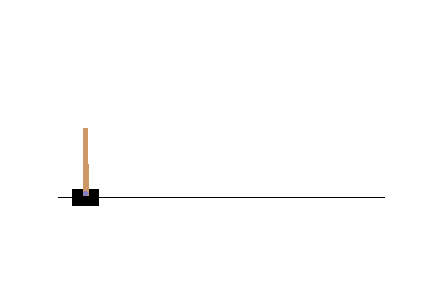
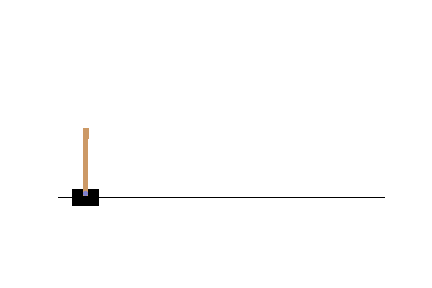
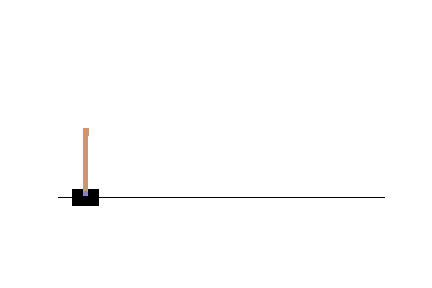
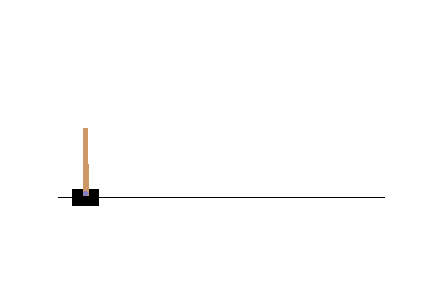
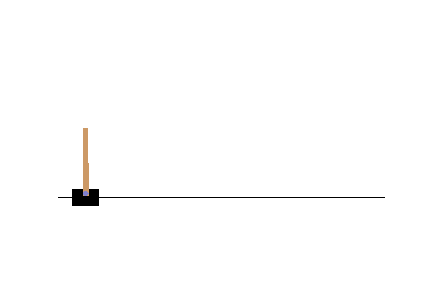
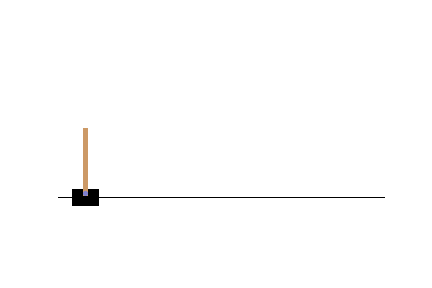
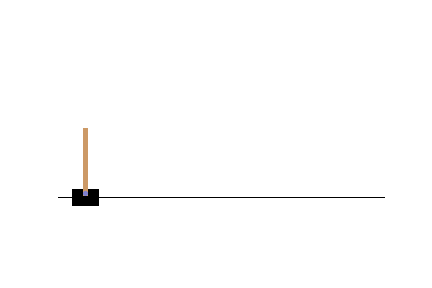
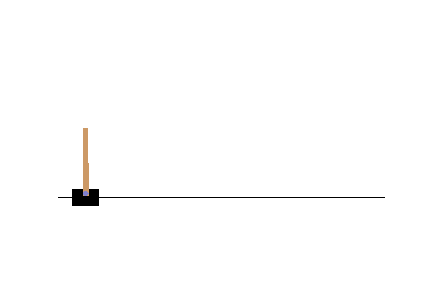
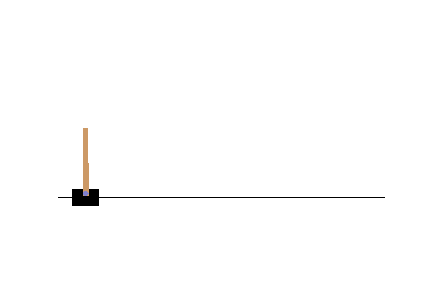
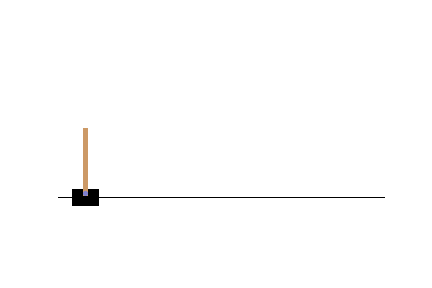
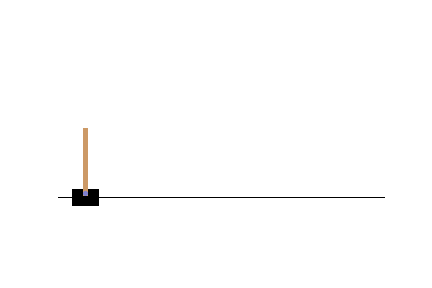
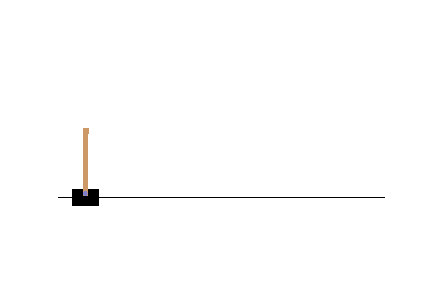
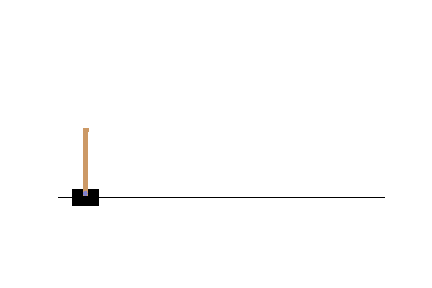
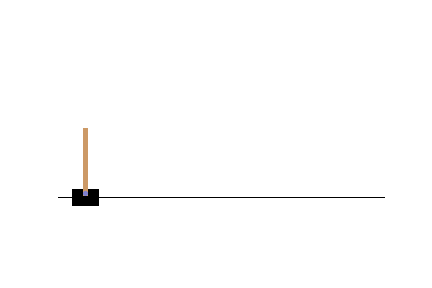
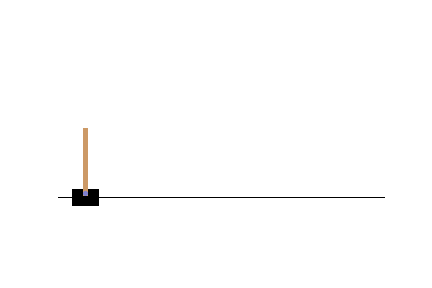
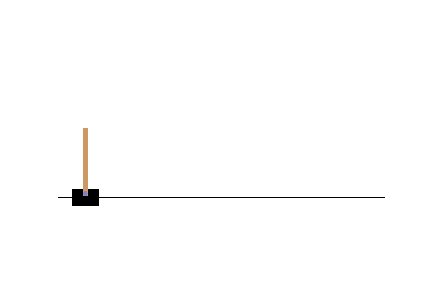
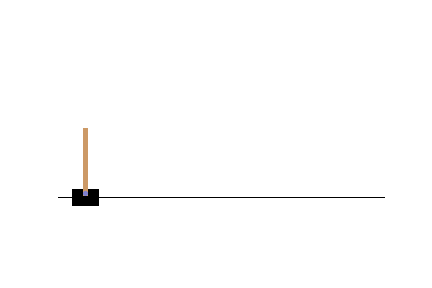
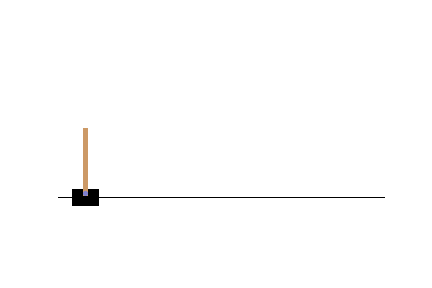
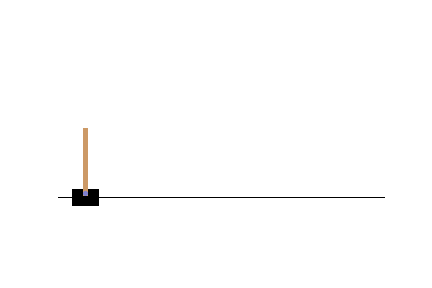
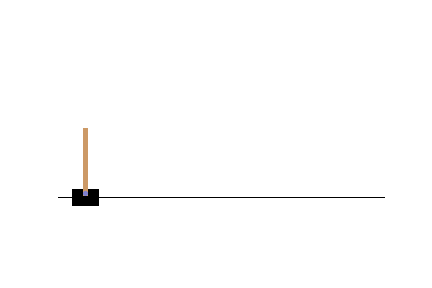
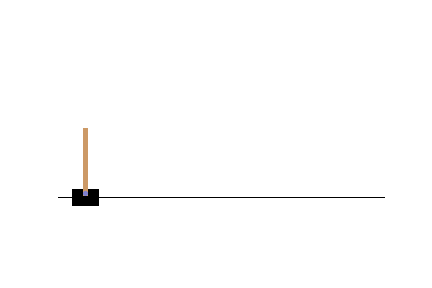
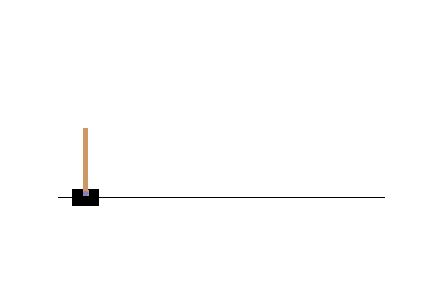
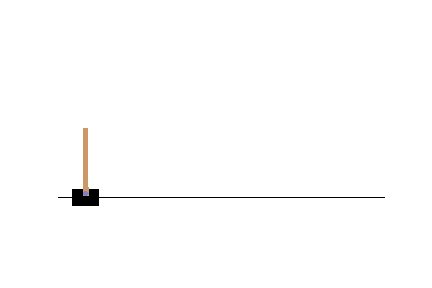
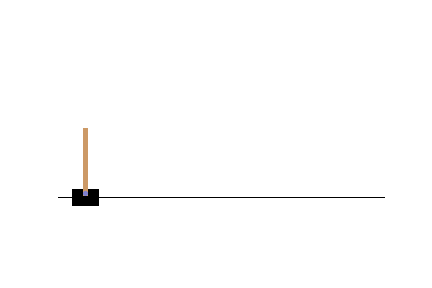
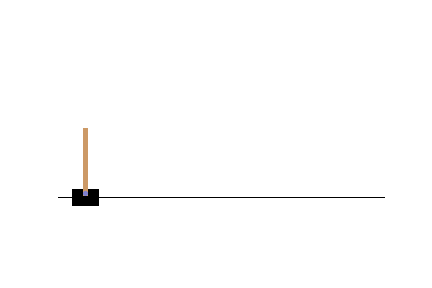
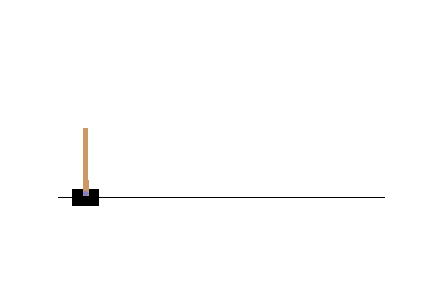
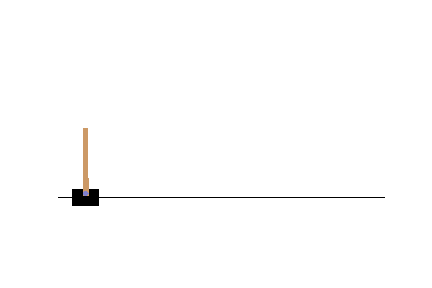
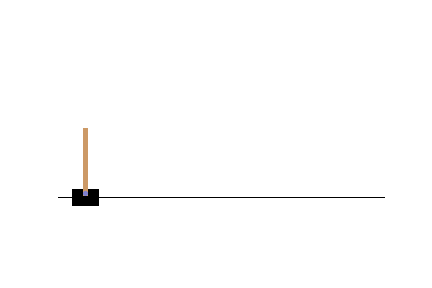
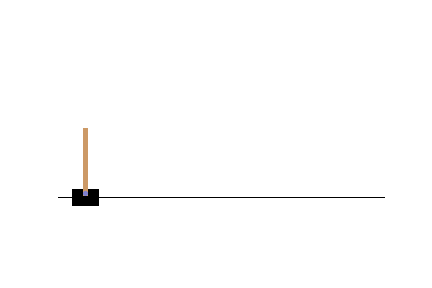
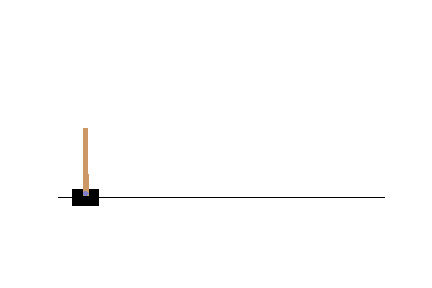
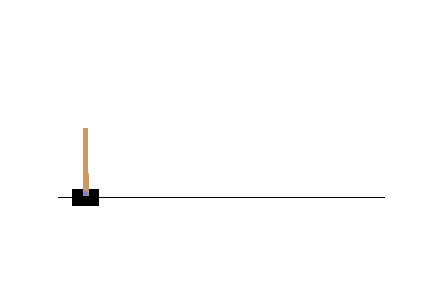
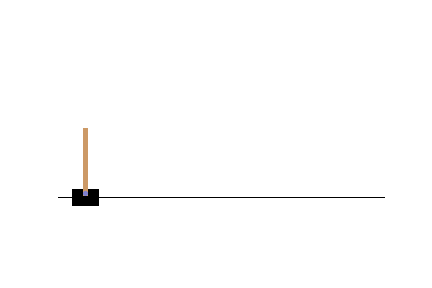
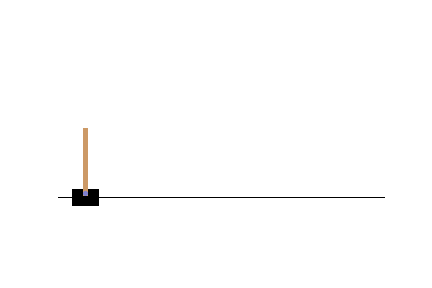
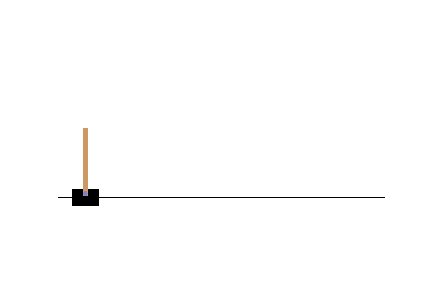
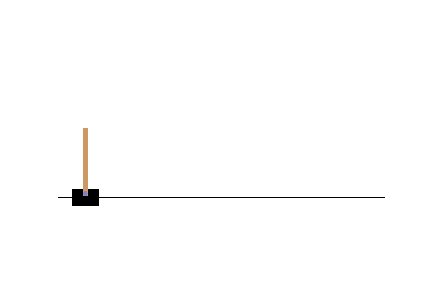
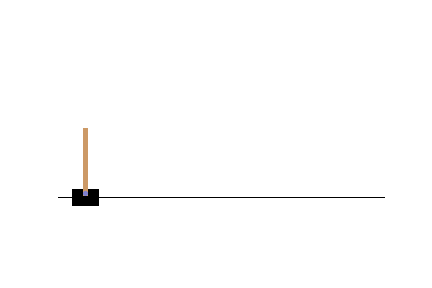
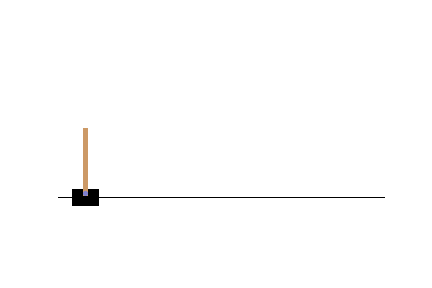
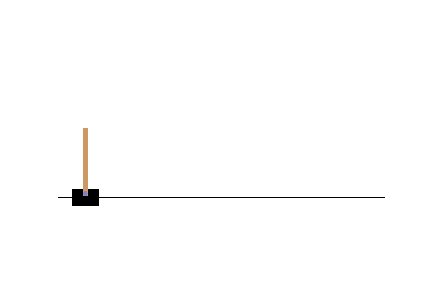
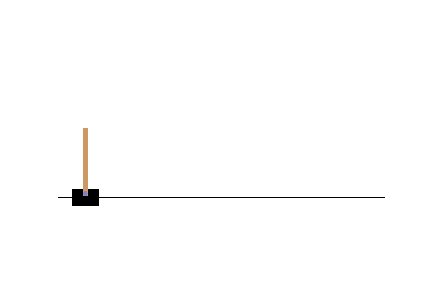
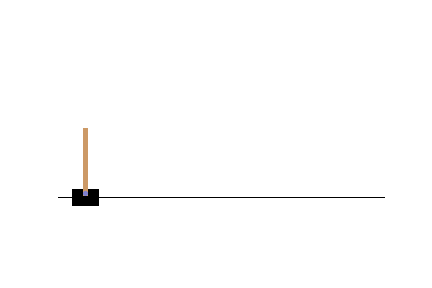
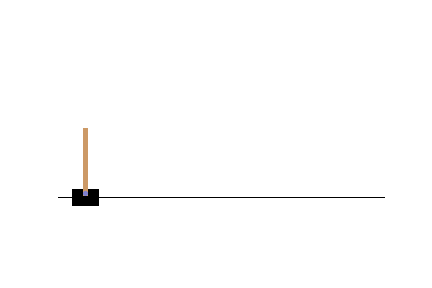
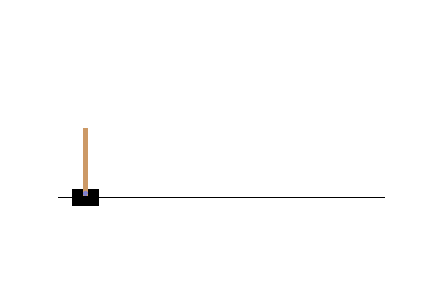
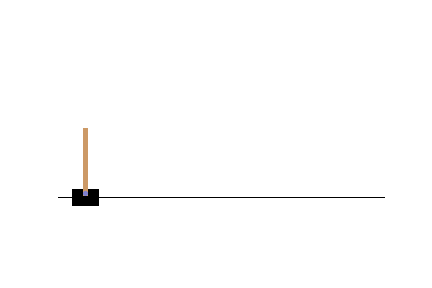
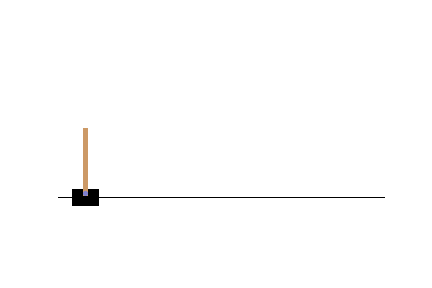
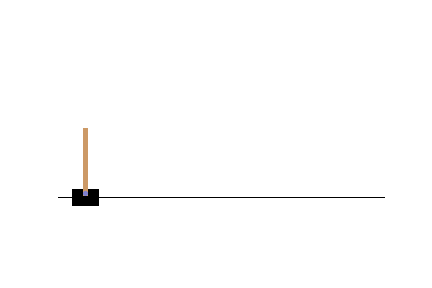
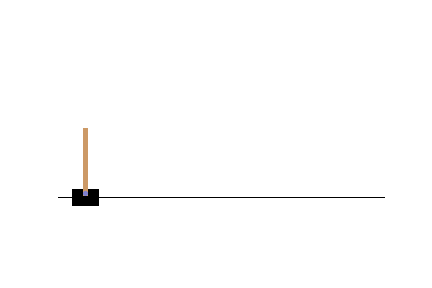
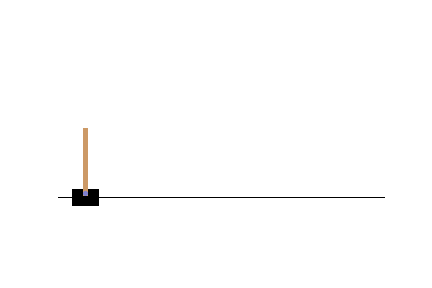
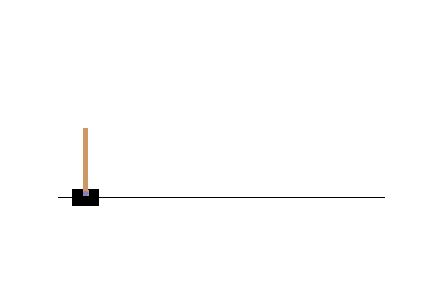
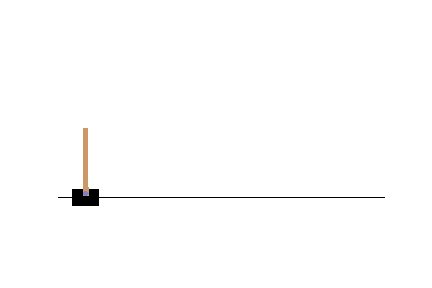
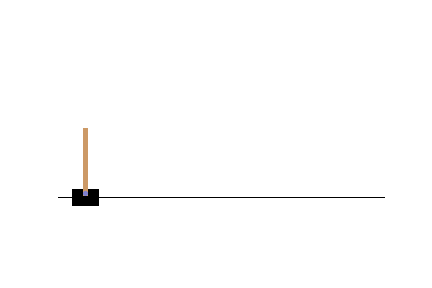
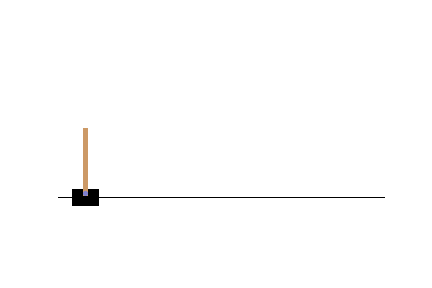
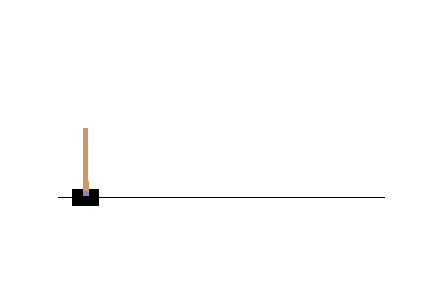
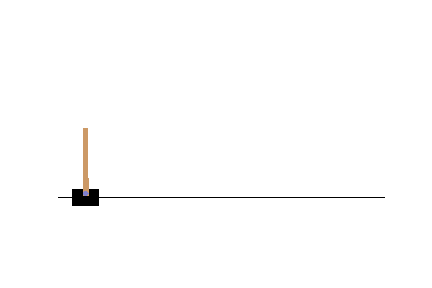
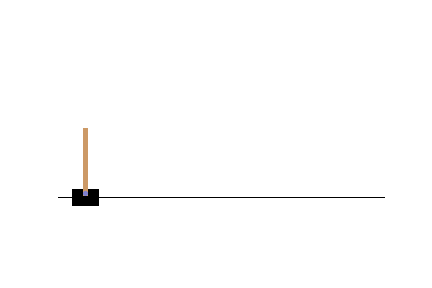
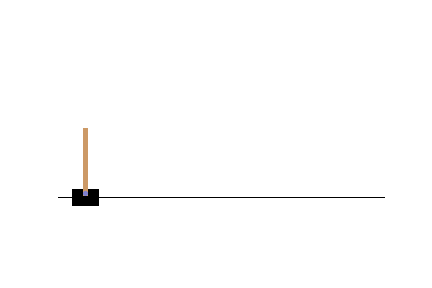
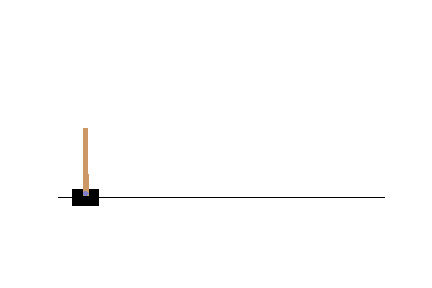
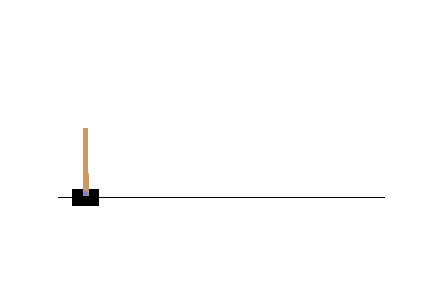
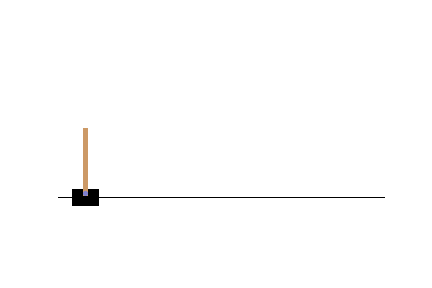
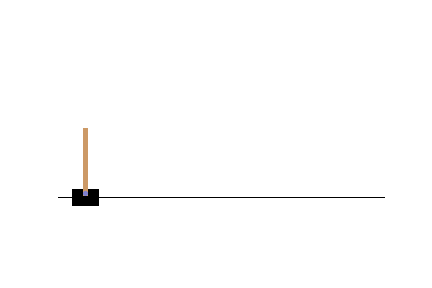
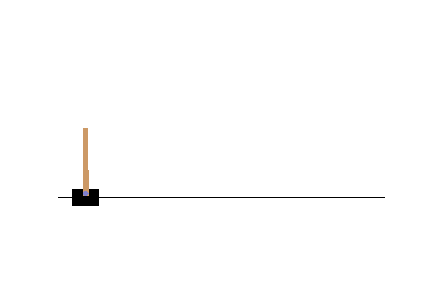
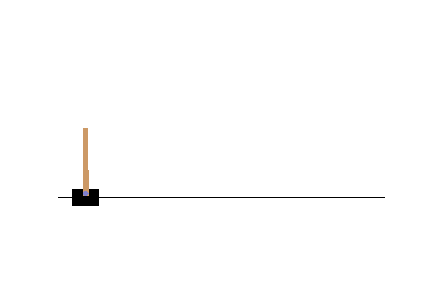
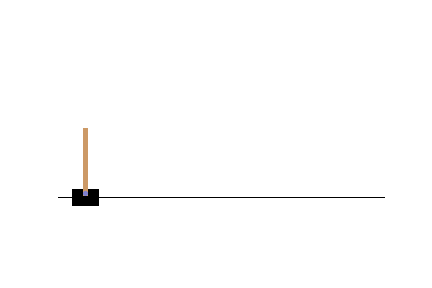
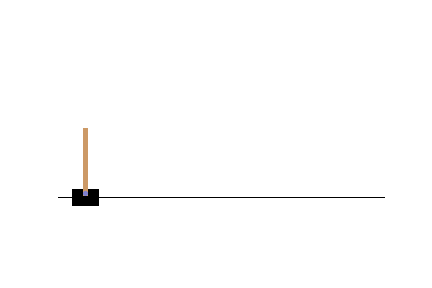
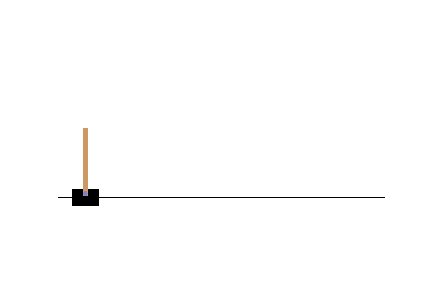
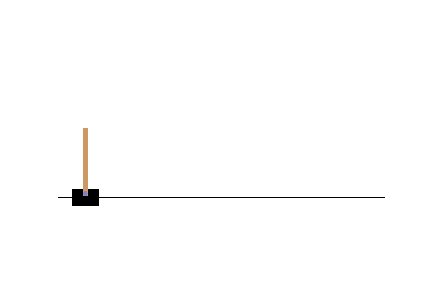
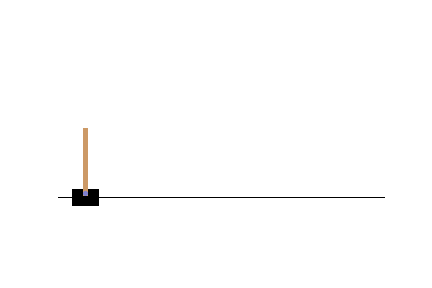
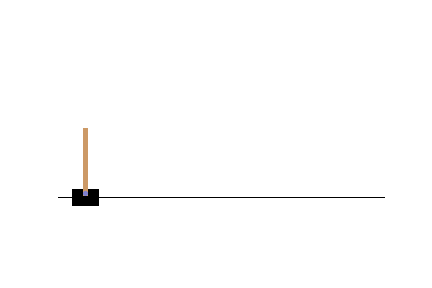
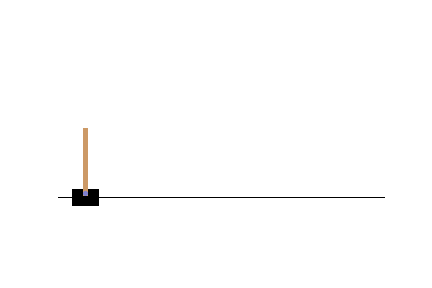
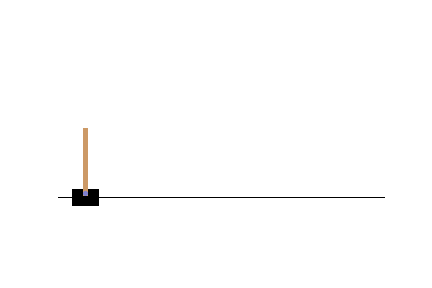
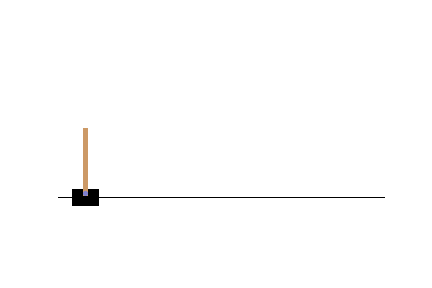
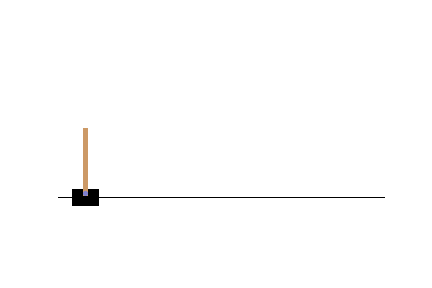
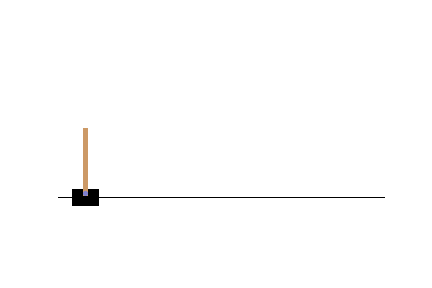
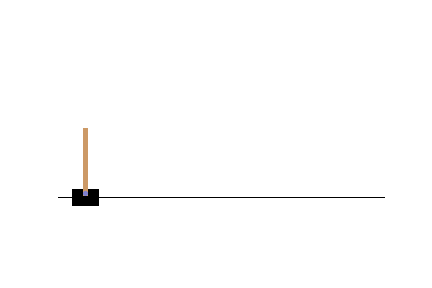
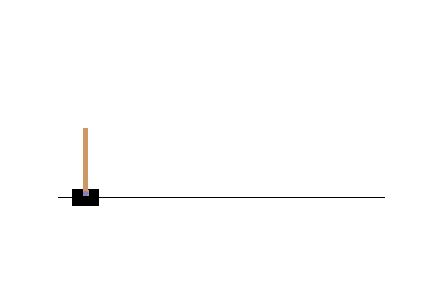
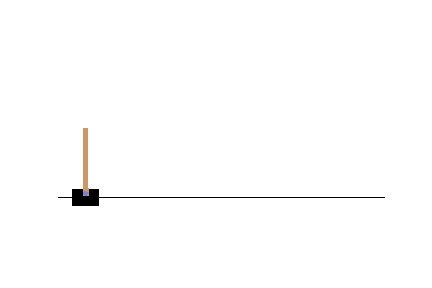
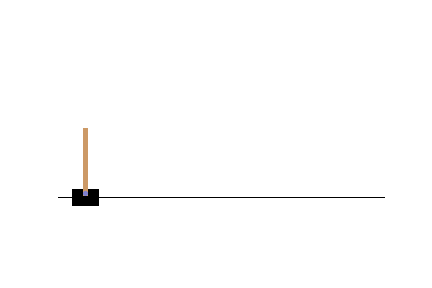
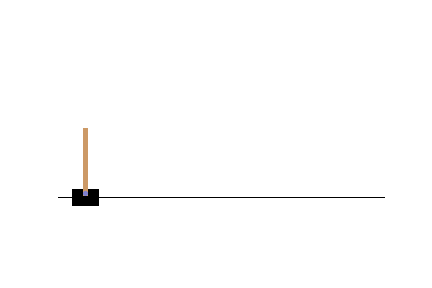
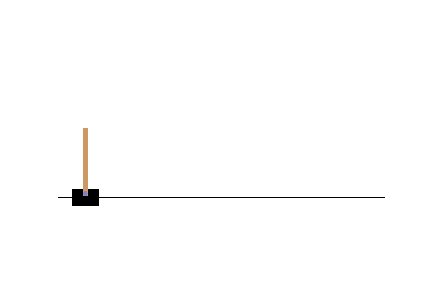
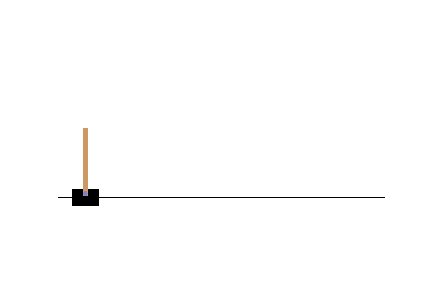
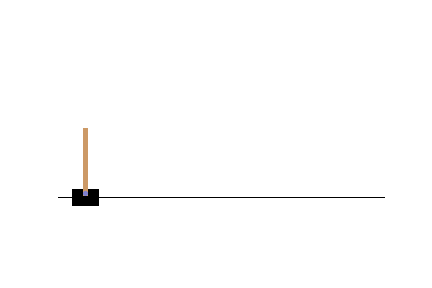
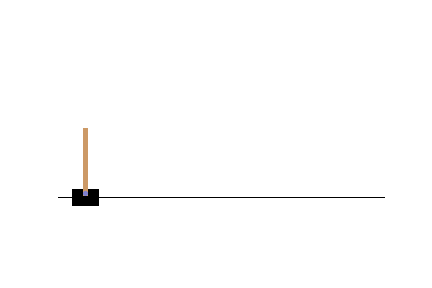
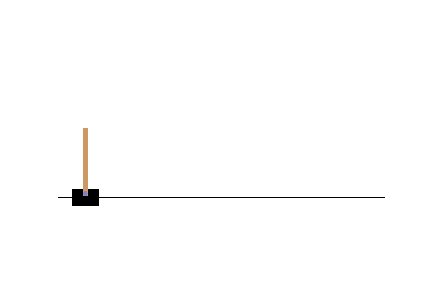
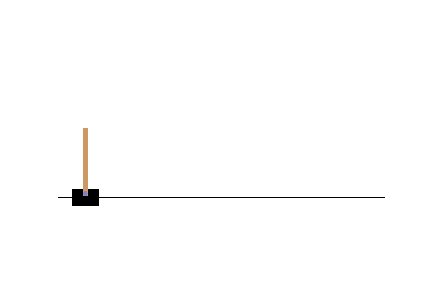
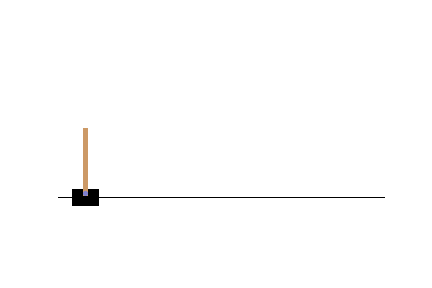
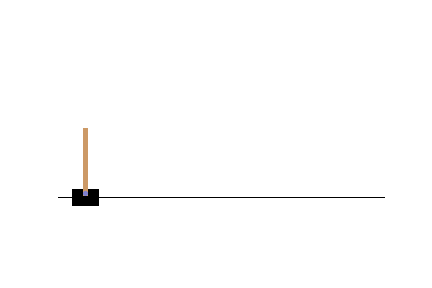
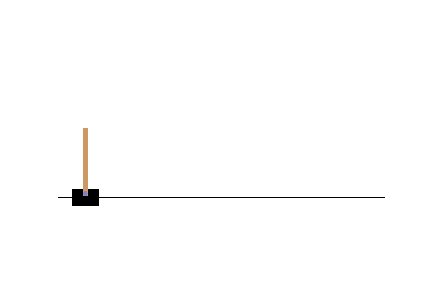
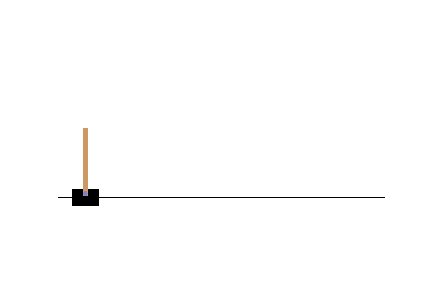
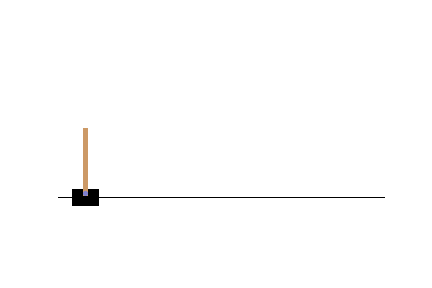
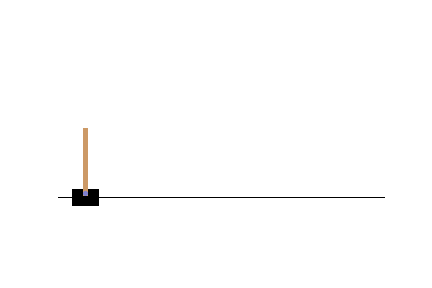
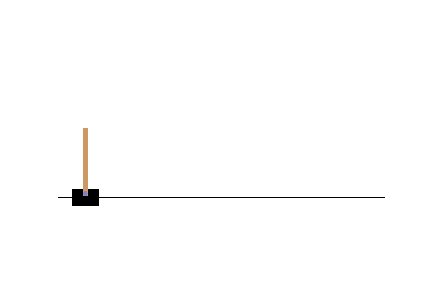
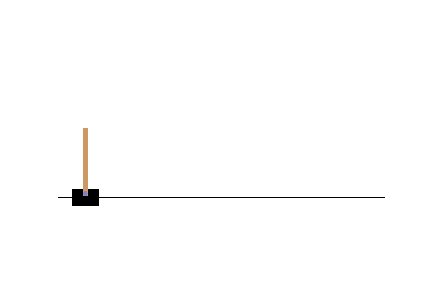
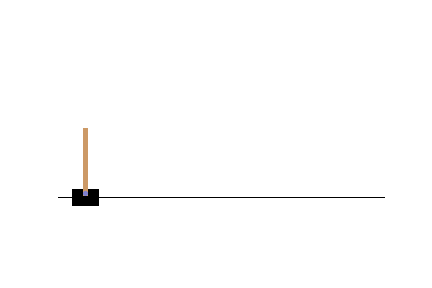
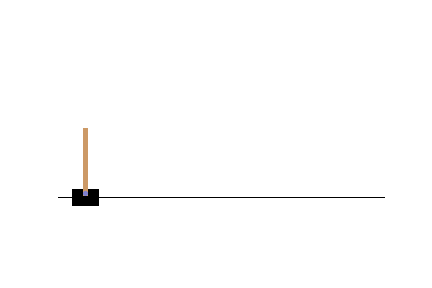
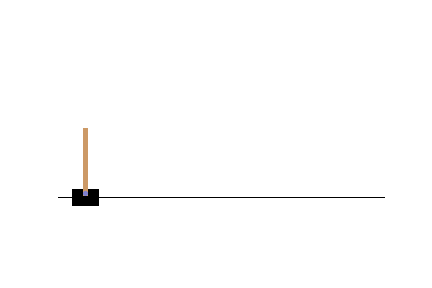
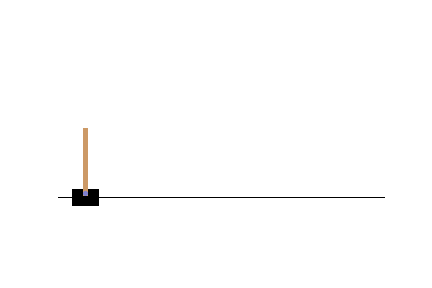
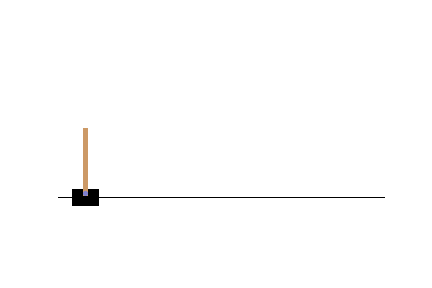
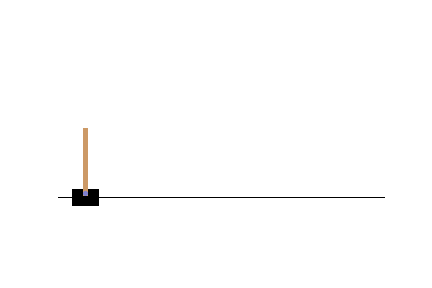
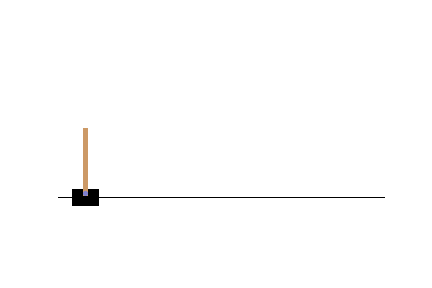
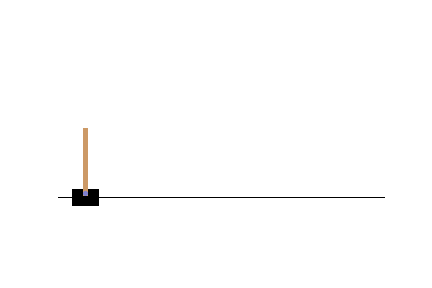
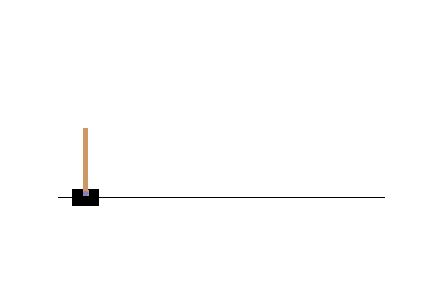
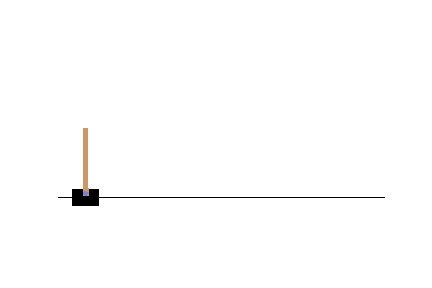
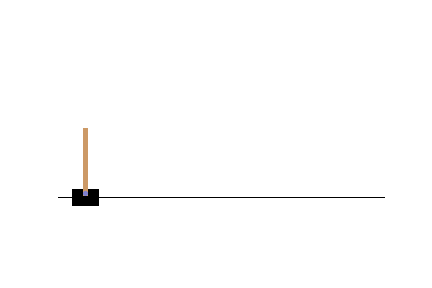
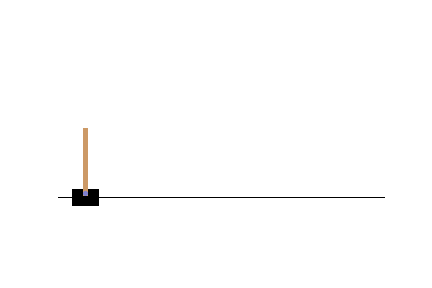
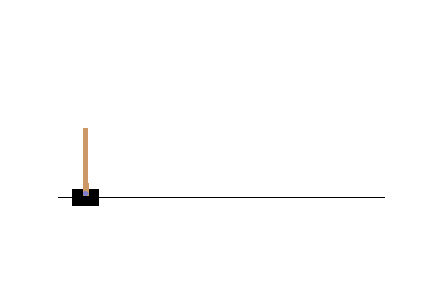
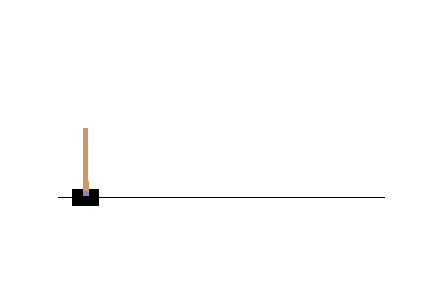
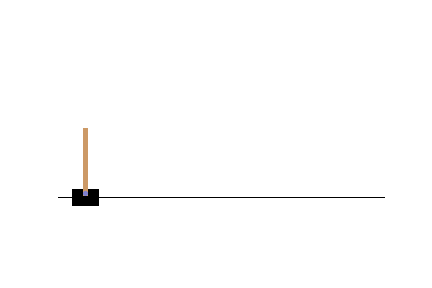
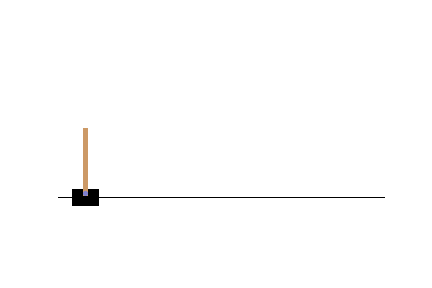
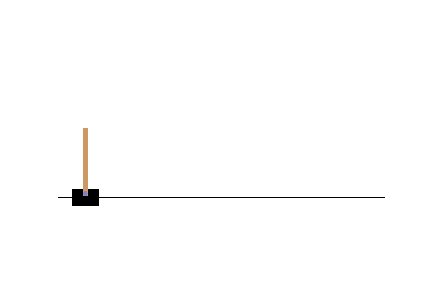
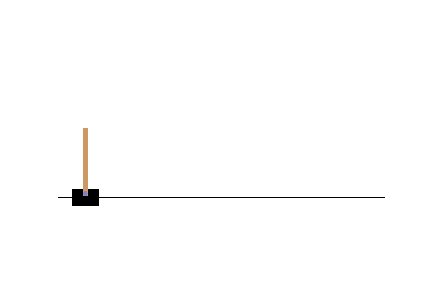
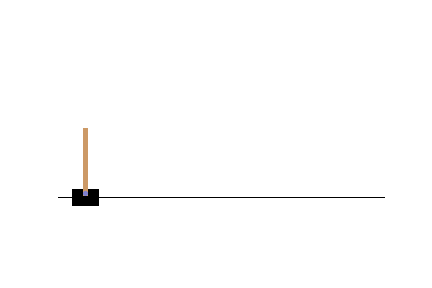
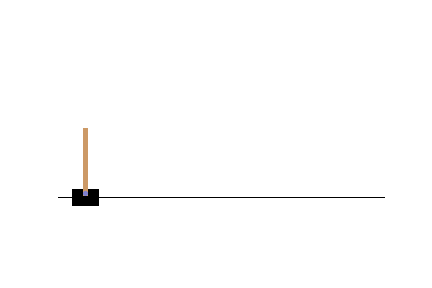
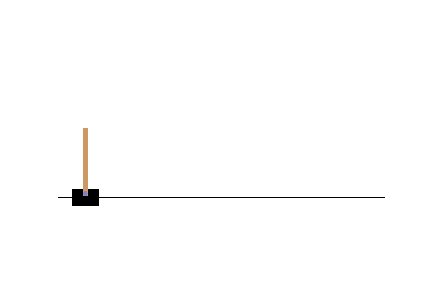
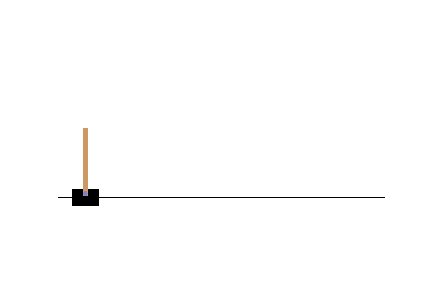
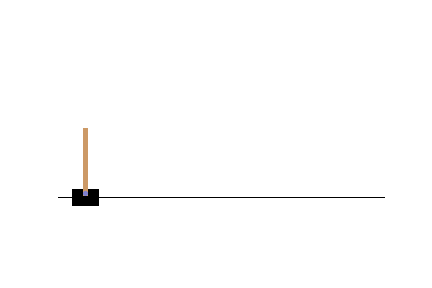
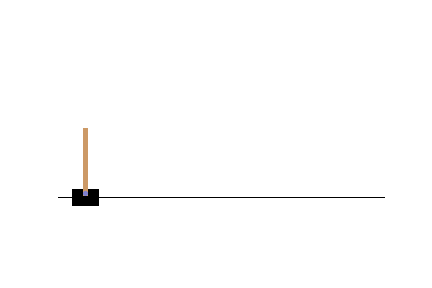
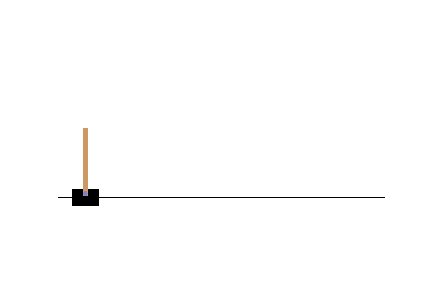
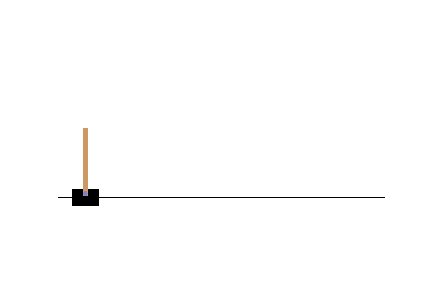
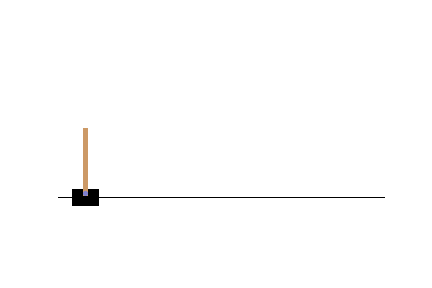
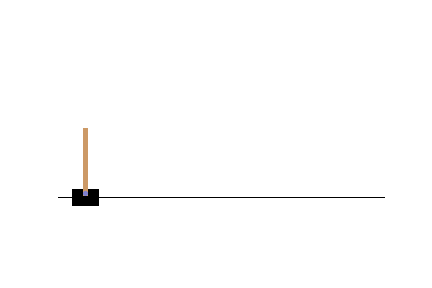
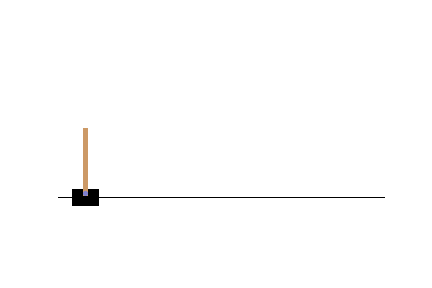
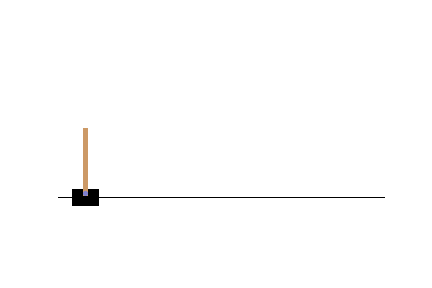
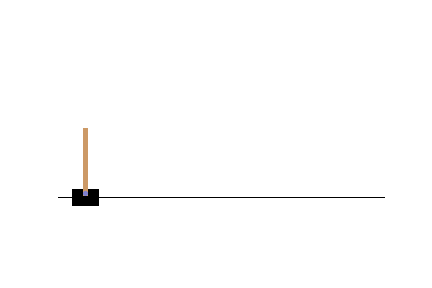
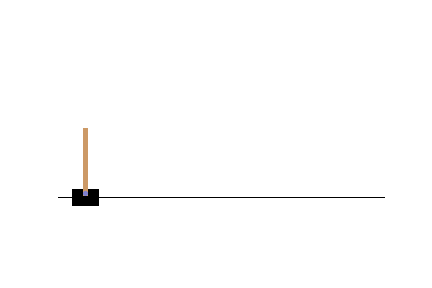
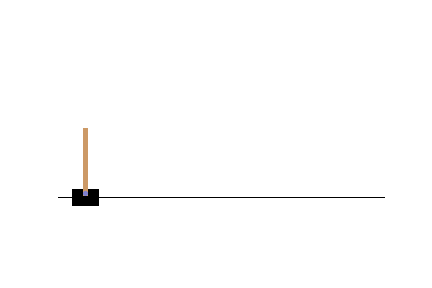
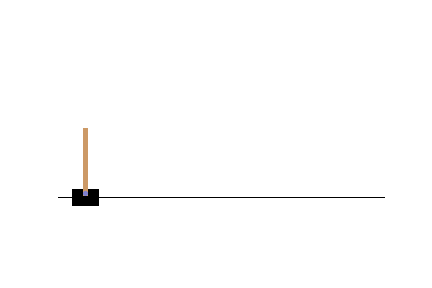
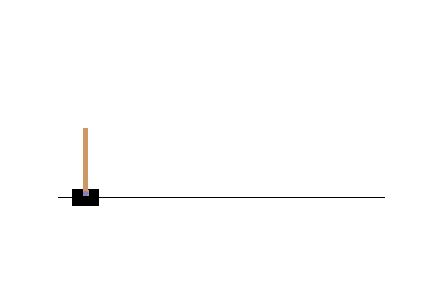
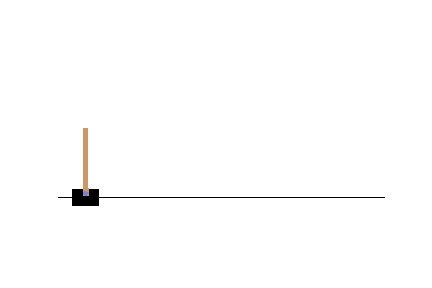
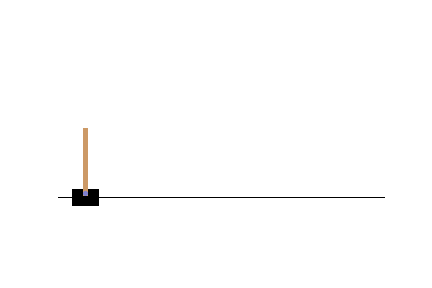
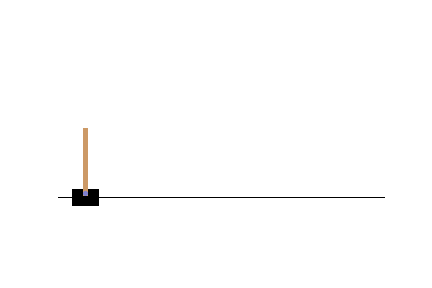
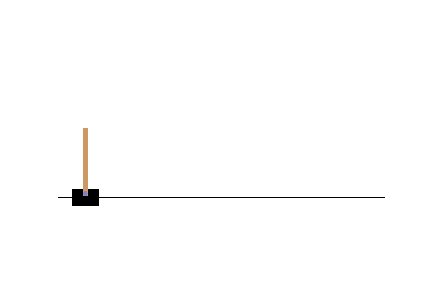
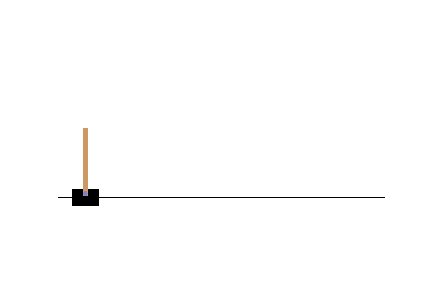
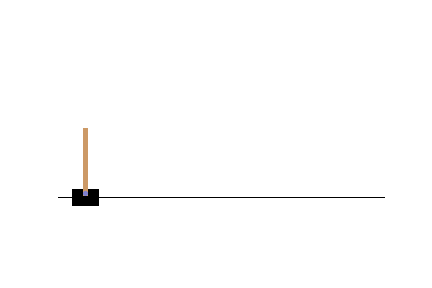
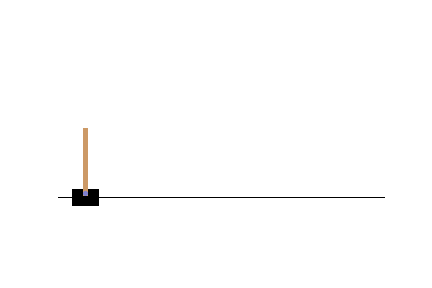
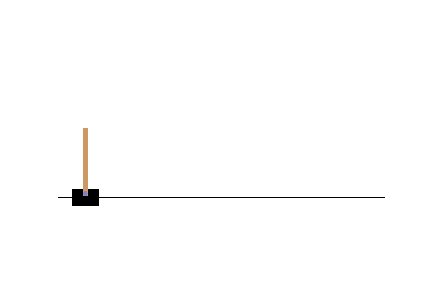
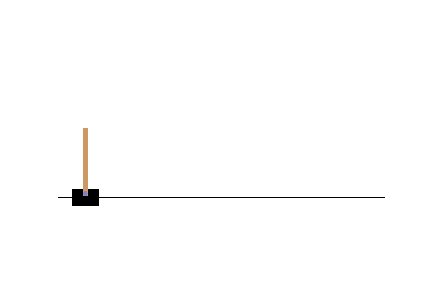
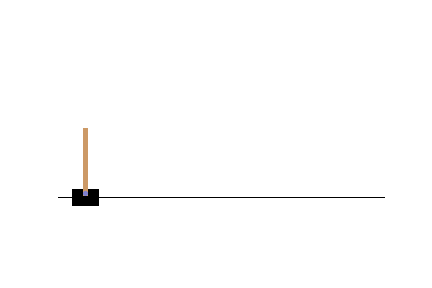
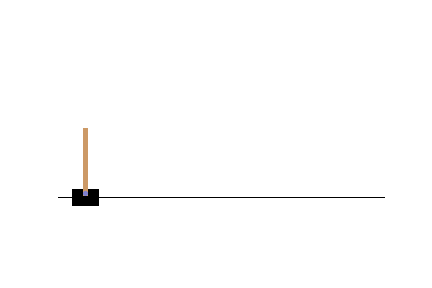
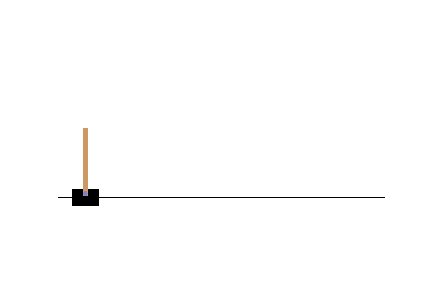
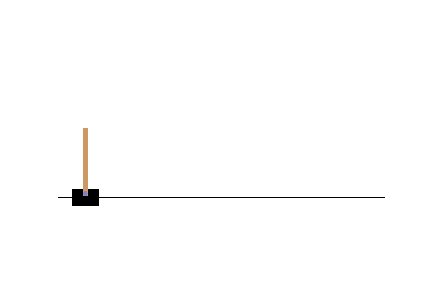
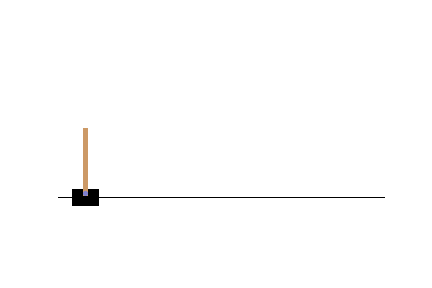
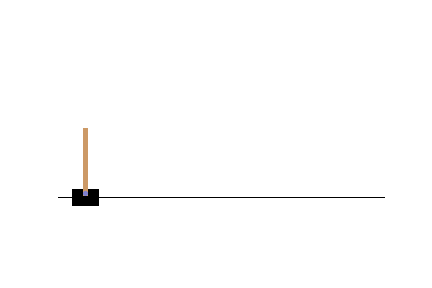
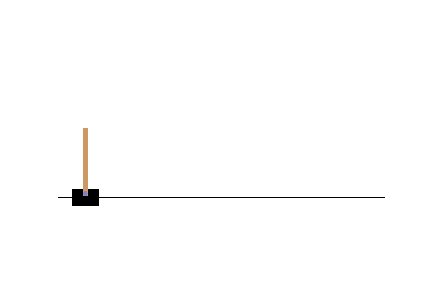
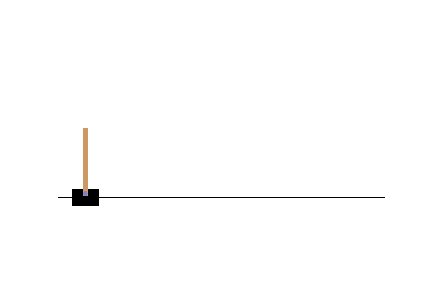
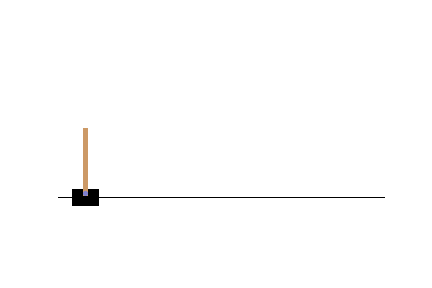
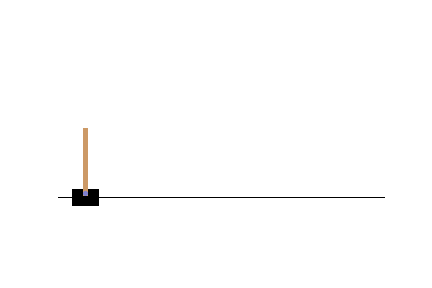
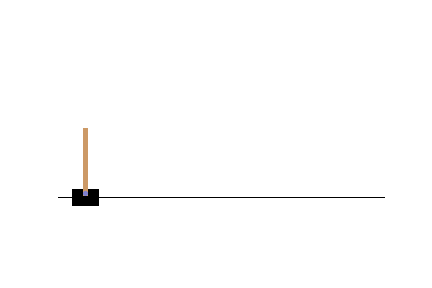
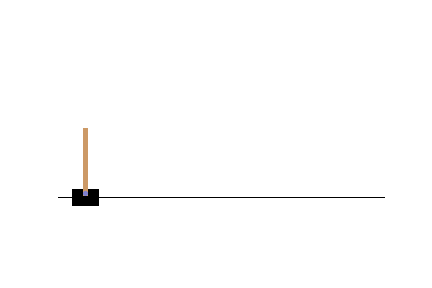
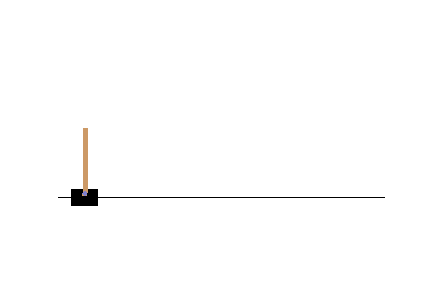
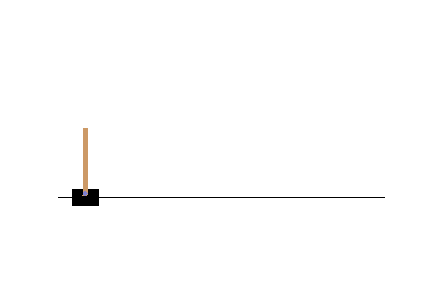
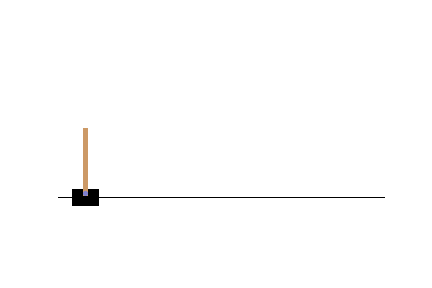
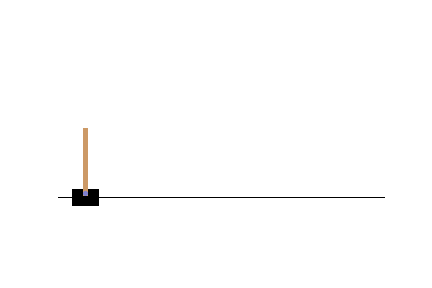
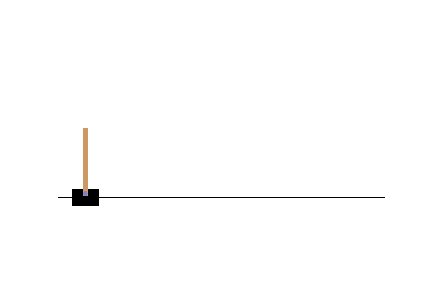
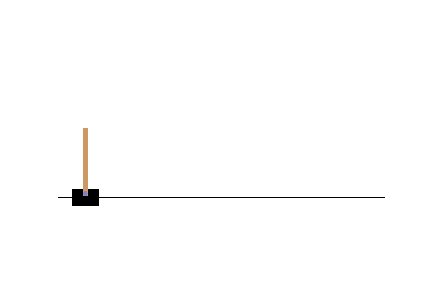
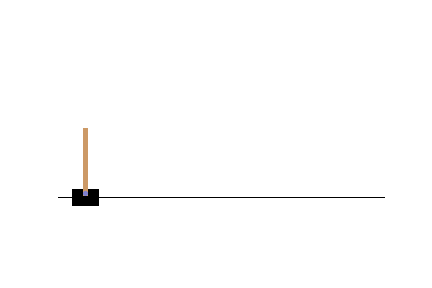
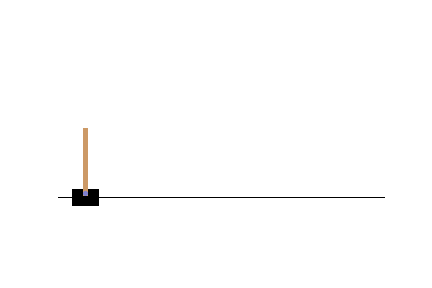
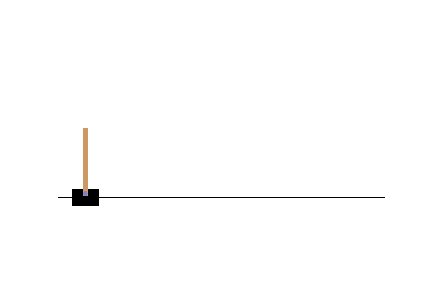
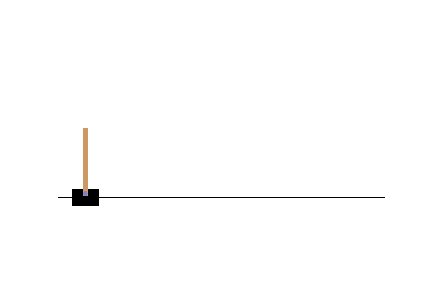
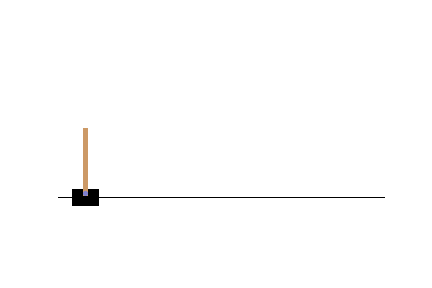
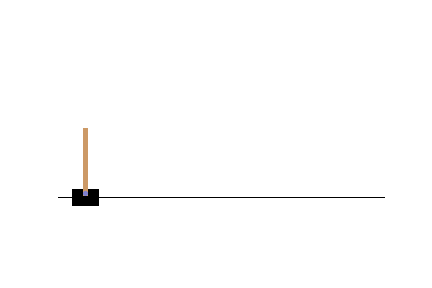
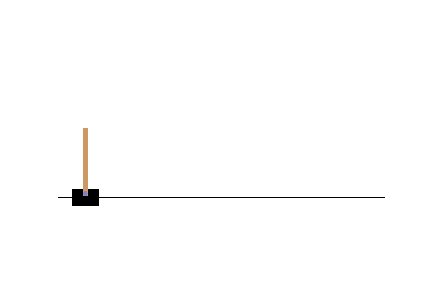
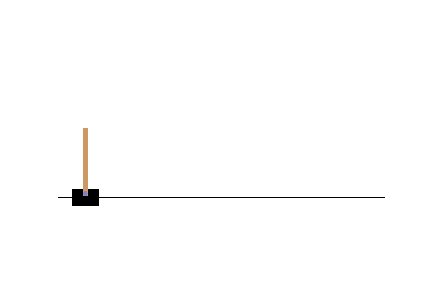
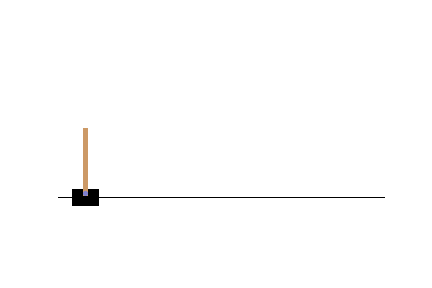
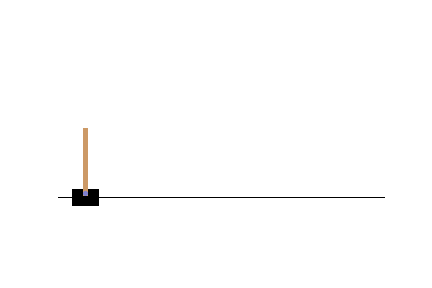
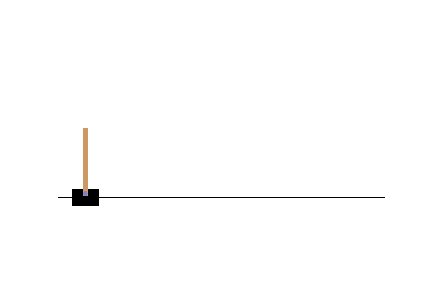
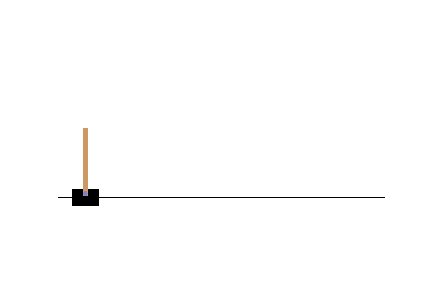
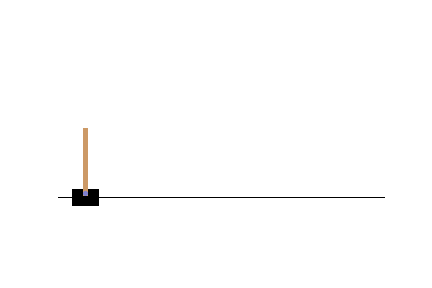
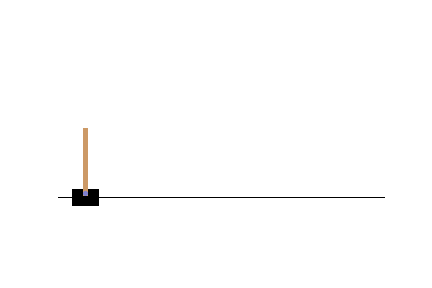
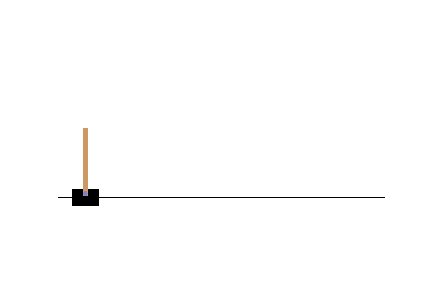
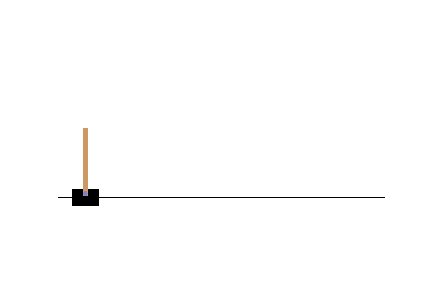
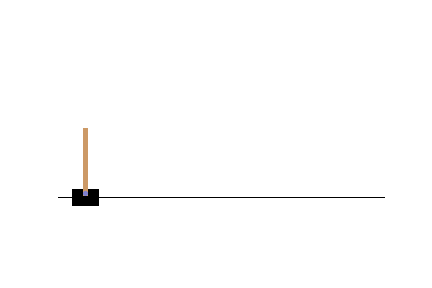
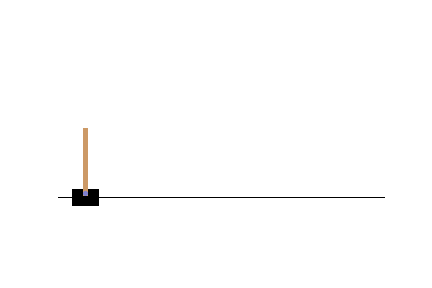
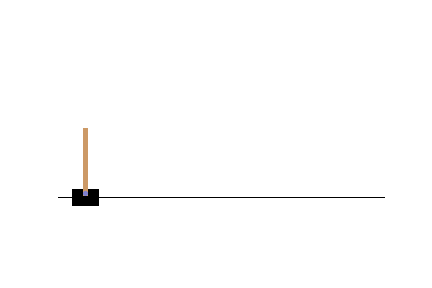
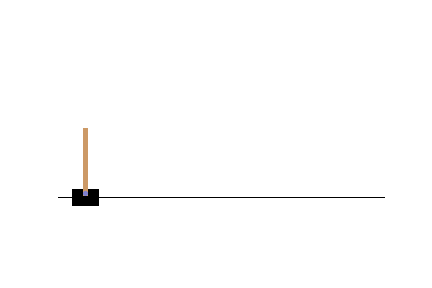
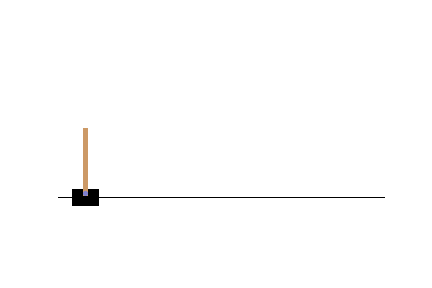
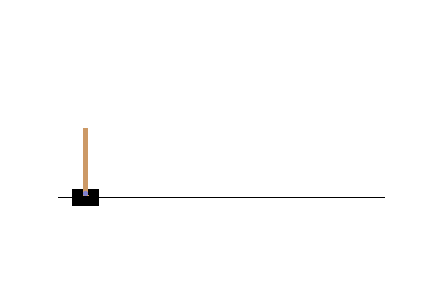
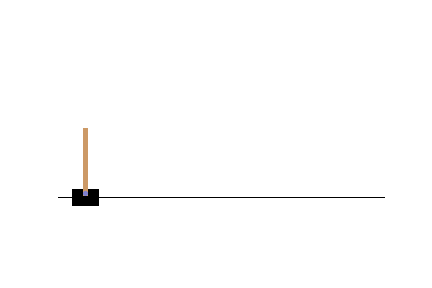
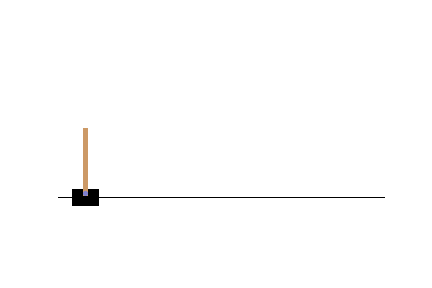
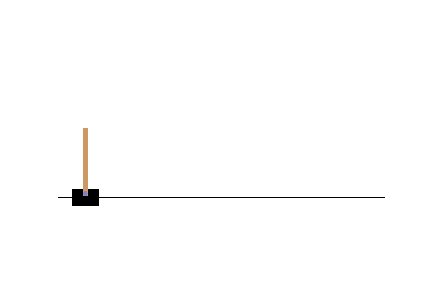
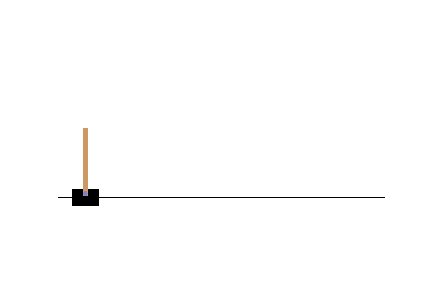
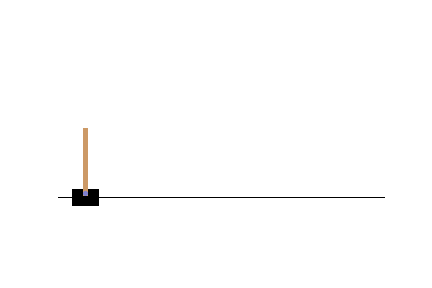
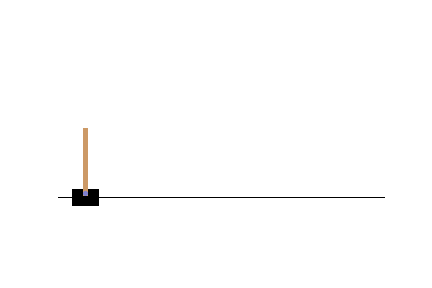
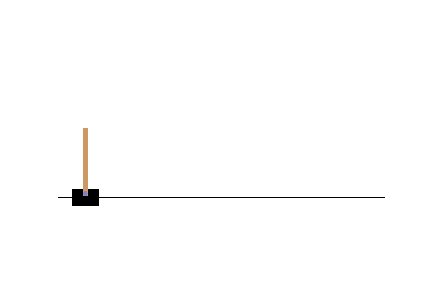
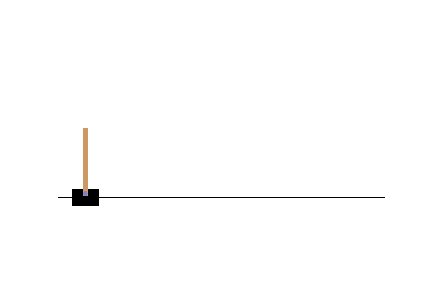
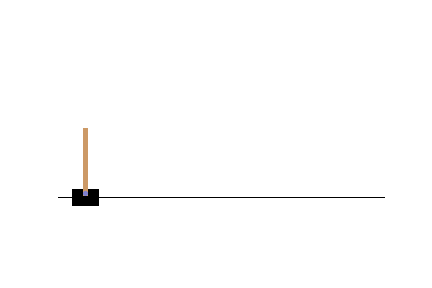
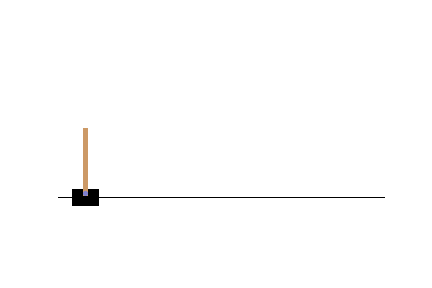
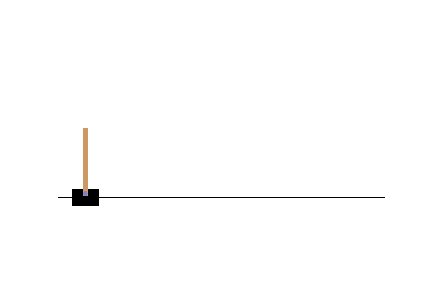
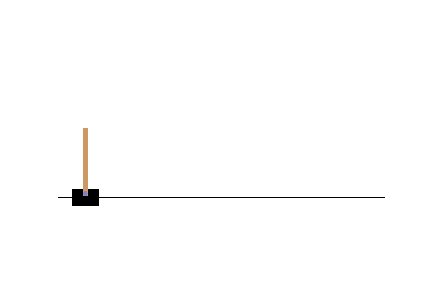
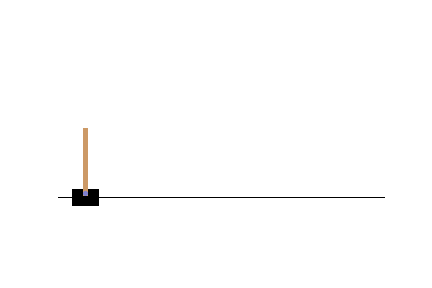
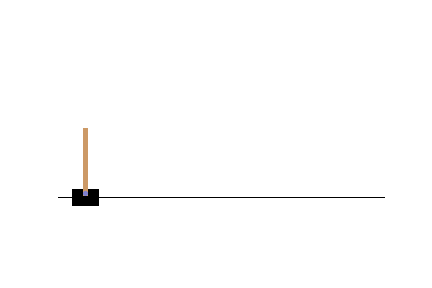
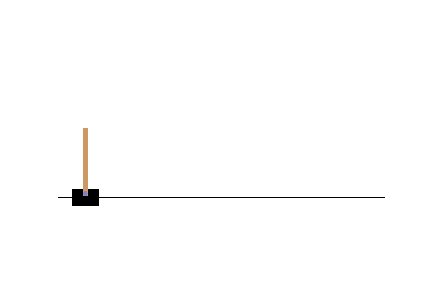
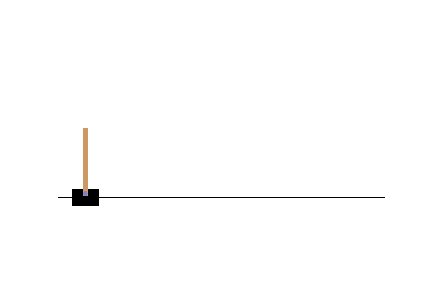
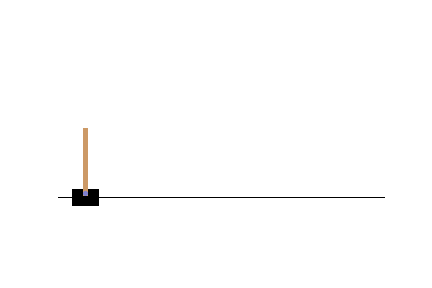
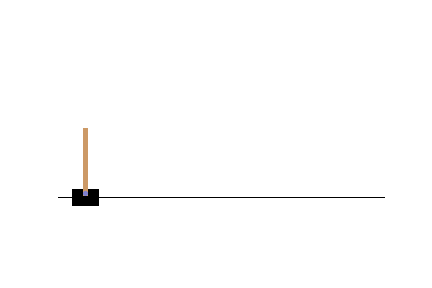
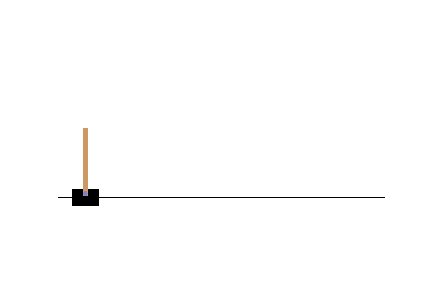
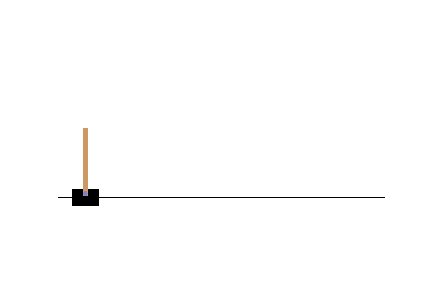
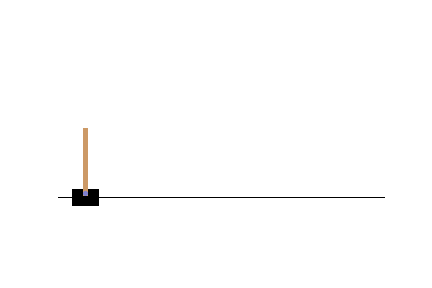
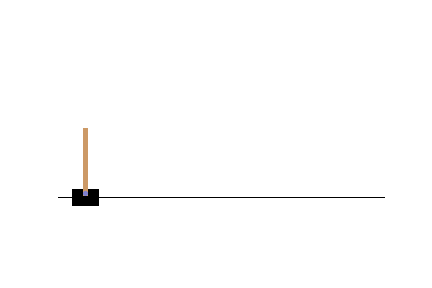
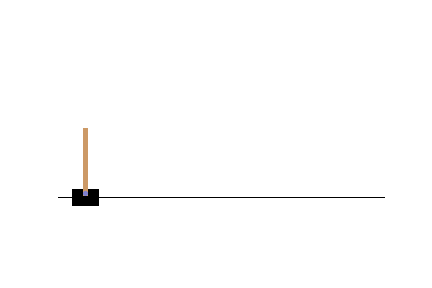
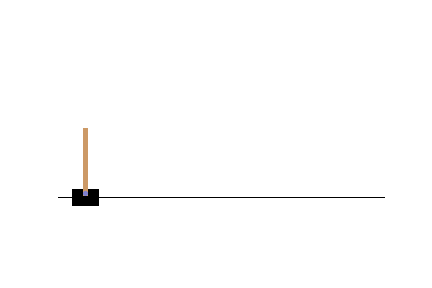
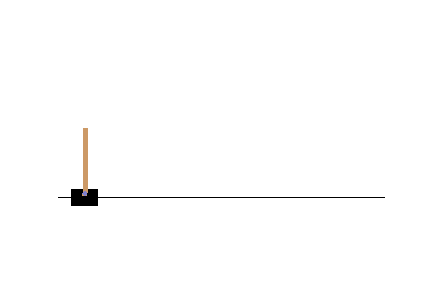
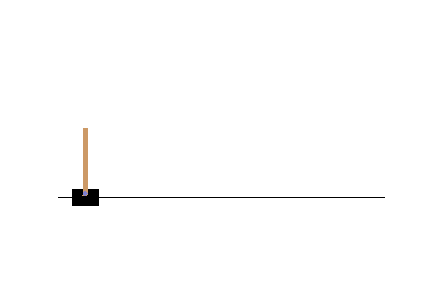
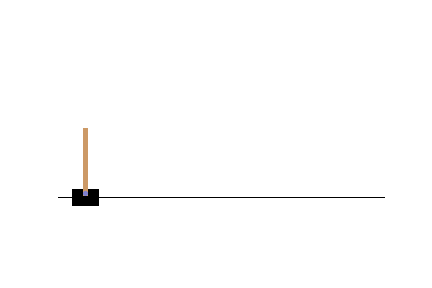
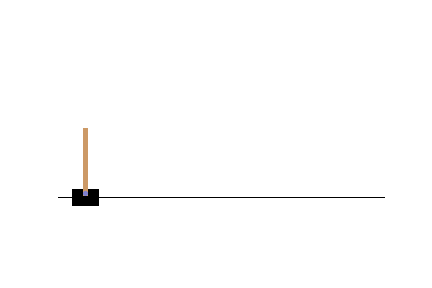
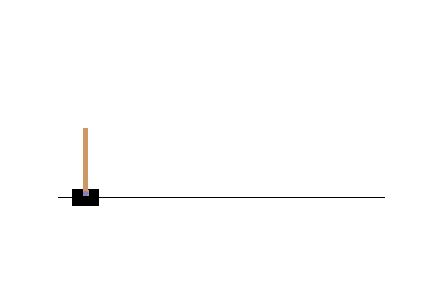
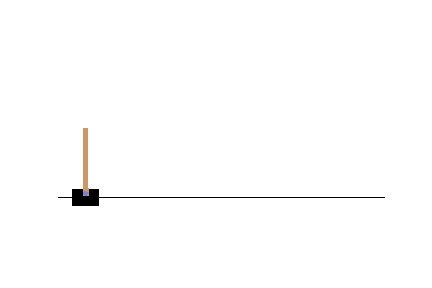
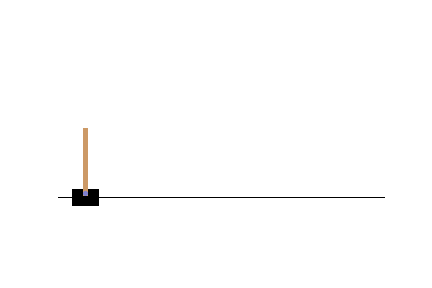
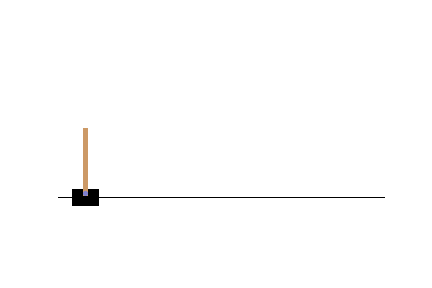
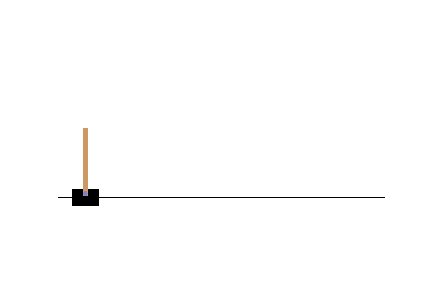
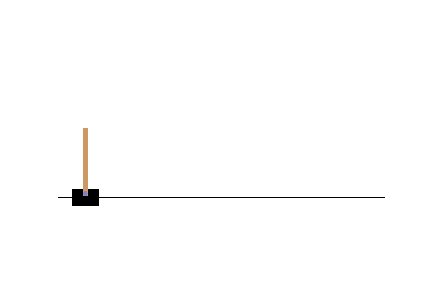
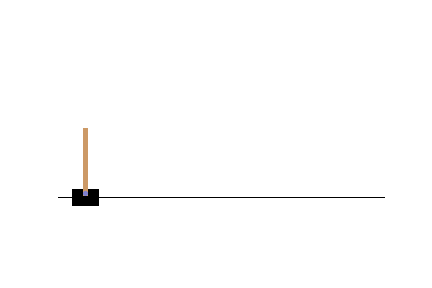
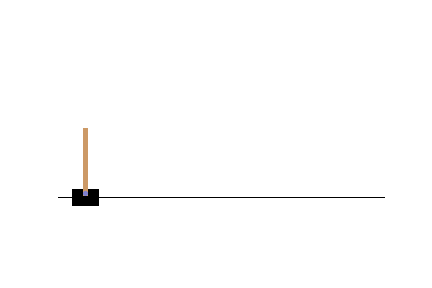
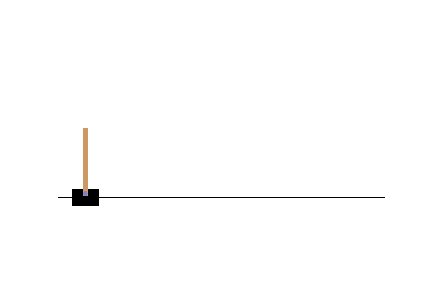
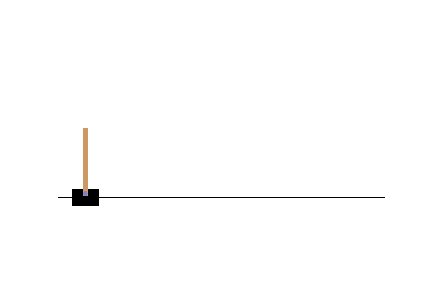
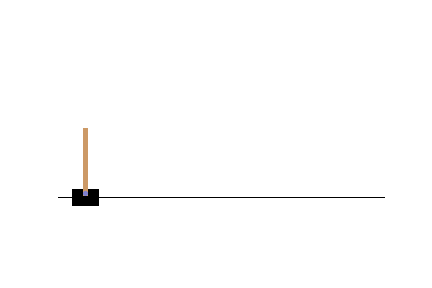
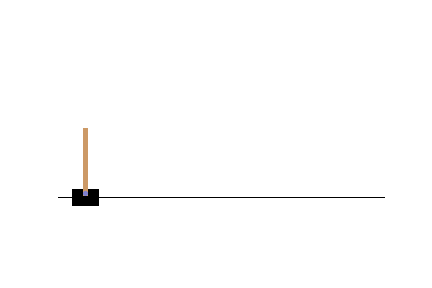
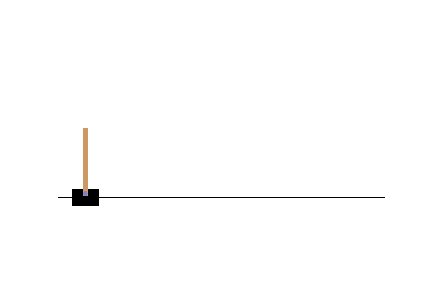
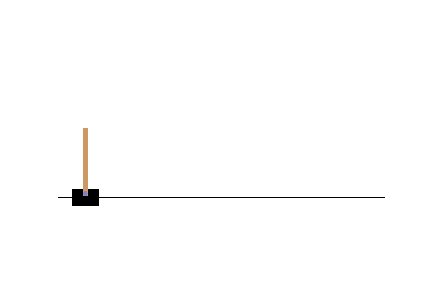
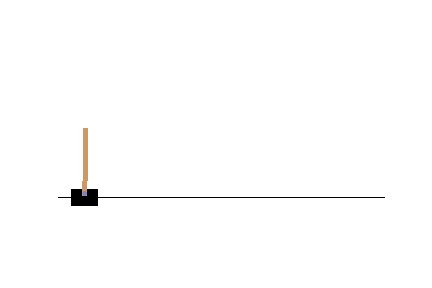
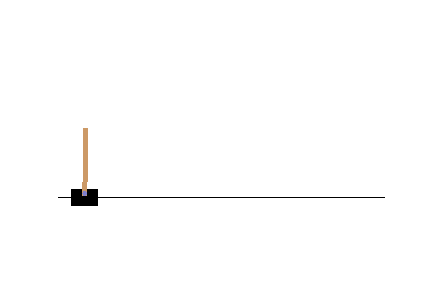
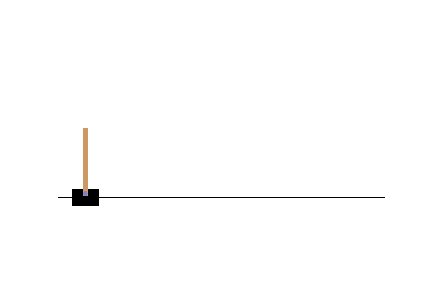
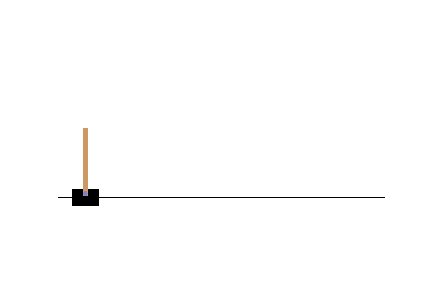
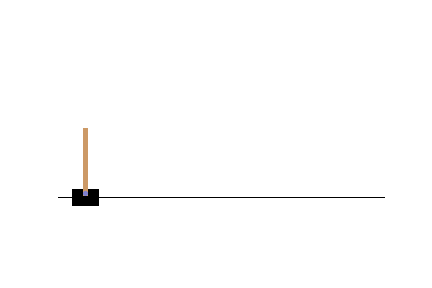
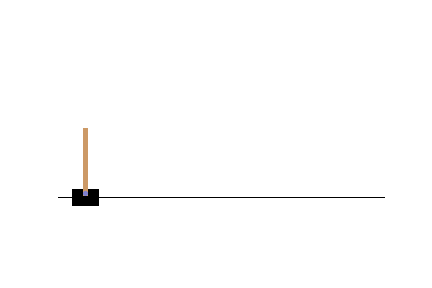
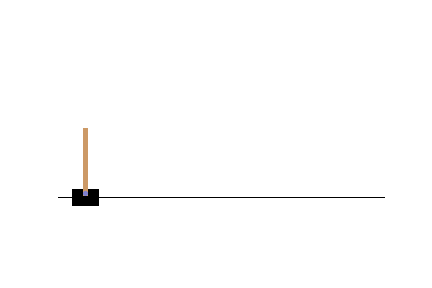
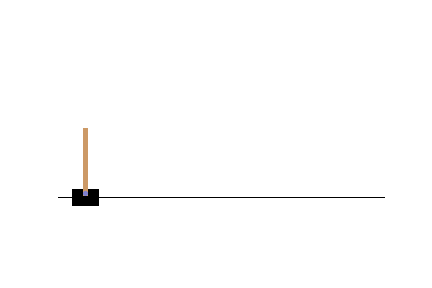
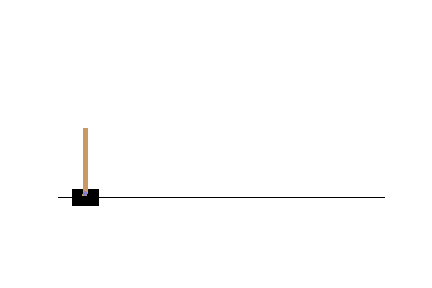
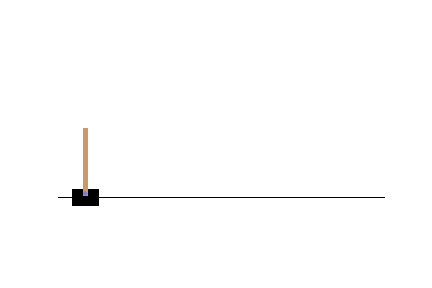
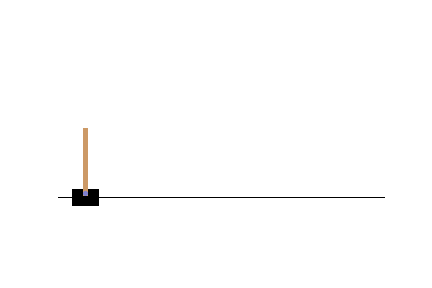
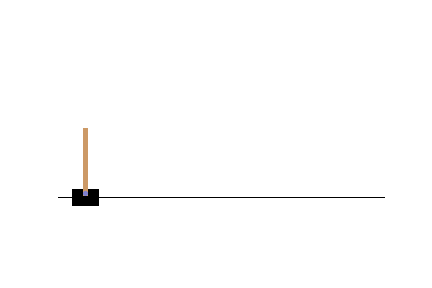
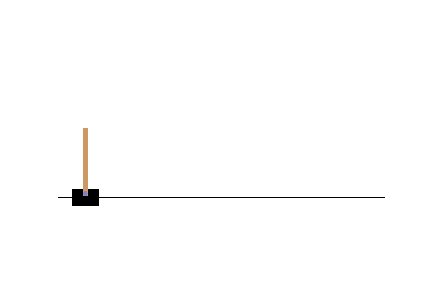
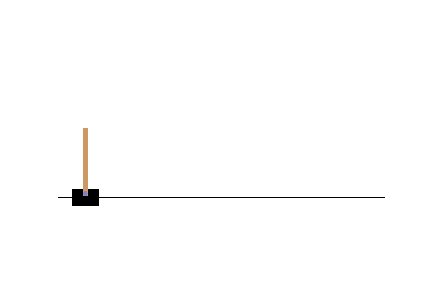
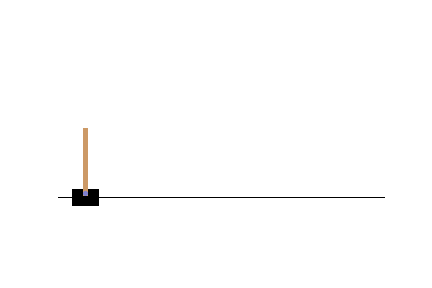
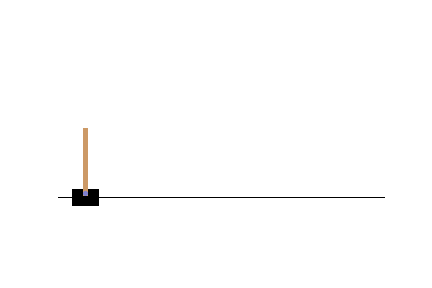
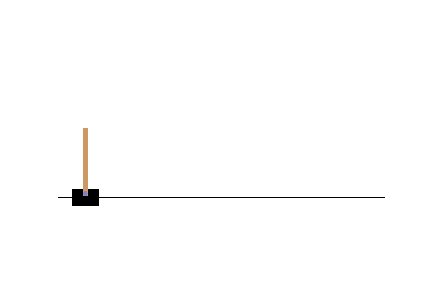
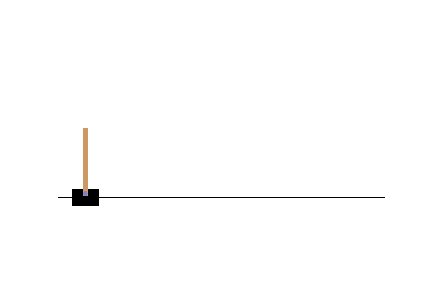

In [0]:
#record agent
frames = []
s = env.reset()
epsilon = 0
total_reward = 0
for t in range(1000):
    frames.append(env.render(mode = 'rgb_array'))
    a = get_action(s, epsilon=epsilon)       
    next_s, r, done, _ = env.step(a)
    total_reward += r
    s = next_s
    if done: break
print(t)
env.close()
display_frames_as_gif(frames)

In [0]:
# record sessions - didn't work for me in colab
# import gym.wrappers
# env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True, write_upon_reset=True)
# sessions = [generate_session(epsilon=0, train=False) for _ in range(1)]
# print(np.mean(sessions))
# env.close()
# sessions
#show video
# from IPython.display import HTML
# import os

# video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

# HTML("""
# <video width="640" height="480" controls>
#   <source src="{}" type="video/mp4">
# </video>
# """.format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices